In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gc
import glob
import os
import csv

import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras import optimizers
from keras.models import load_model
%matplotlib inline

In [3]:
SET50 = ['ADVANC', 'AOT', 'BANPU', 'BBL', 'BCP', 'BDMS',
        'BEM', 'BH', 'BJC', 'BTS', 'CENTEL', 'CPALL', 
         'CPF', 'CPN', 'DTAC', 'EGCO', 'HMPRO', 
         'INTUCH', 'IRPC', 'KBANK', 'KCE', 'KKP', 'KTB', 'LH', 'MINT', 'PTT',
        'PTTEP', 'ROBINS', 'SCB', 'SCC', 
        'TCAP', 'TISCO', 'TMB', 'TOP', 'TRUE', 'TU']

In [4]:
def load_stock_data(symbol, year_start, year_end):
    stock_data = []
    with open('../Data set/FIXED_SET50/' + symbol + '.BK.csv', 'r') as csv_file:
        file_data = csv.reader(csv_file, delimiter=',')
        file_data = list(file_data)[1:]
        temp_value = 0
        for row in file_data:
            if row[1] is '':
                continue
            elif int(row[0][0:4]) >= year_start and int(row[0][0:4]) <= year_end:
                temp = float(row[1])
                if temp_value != 0:
                    unrealize = (temp - temp_value)/ temp_value
                else:
                    unrealize = 0
                unrealize = ["{0:.4f}".format(unrealize)]
                stock_data.append(unrealize)
                temp_value = temp
                
    return stock_data

def mean_square_error(actual, predict):
    length = len(actual)
    sums_error = 0.0
    for i, j in zip(actual, predict):
        sums_error += (i - j)**2
    
    return sums_error / length

def findNewXTest(x_test, predict):
    for (index, element) in enumerate(x_test[0]):
        for i in range(len(element)):
            if i == 0:
                continue
            elif i < 29:
                element[i - 1] = element[i]
            else:
                element[i - 1] = element[i]
                element[i] = "{0:.4f}".format(predict[index])
    return x_test

In [5]:
stock_datas = [ load_stock_data(x, 2008, 2017) for x in SET50 ]

min_count = len(stock_datas[0])

In [6]:
def create_model(conv_count, fully_count):
    i = 0
    model = Sequential()
    while(i <= conv_count):
        if i == 0:
            model.add(Conv2D(64, (7, 1), input_shape=(len(stock_datas), 30, 1), padding='same'))
        else:
            model.add(Conv2D(32, (3, 1)))
            
        model.add(Activation('tanh'))
        model.add(MaxPooling2D(pool_size = (2, 1), data_format= "channels_last"))
        i += 1
        
    i = 0
    model.add(Flatten())
    
    while(i <= fully_count):
        if i == fully_count:
            model.add(Dropout(0.2))
            model.add(Dense(len(stock_datas)))
        else:
            model.add(Dense(256))  
            model.add(Activation('tanh'))
        i += 1
    
    return model

In [7]:
rounds = min_count - 30
train_index = int(rounds * 0.75)
validate_index = train_index + int(rounds * 0.05)

In [8]:
data = []
count = 0
index = 0
while index < rounds:
    temp = [i[index : index + 30] for i in stock_datas]
    data.append(temp)
    index += 1
    
x = np.asarray(data)
x_train = x[0: train_index].astype('float32')
x_validate = x[train_index: validate_index].astype('float32')
x_test = x[validate_index: rounds].astype('float32')

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2] * x_train.shape[3]))
x_validate = np.reshape(x_validate, (x_validate.shape[0], x_validate.shape[1], x_validate.shape[2] * x_validate.shape[3]))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2] * x_test.shape[3]))

# x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[2] * x_train.shape[3], x_train.shape[1]))
# x_validate = np.reshape(x_validate, (x_validate.shape[0], x_validate.shape[2] * x_validate.shape[3],x_validate.shape[1]))
# x_test = np.reshape(x_test, (x_test.shape[0] , x_test.shape[2] * x_test.shape[3] , x_test.shape[1]))

print(x_train.shape, x_validate.shape, x_test.shape)

(1811, 36, 30) (120, 36, 30) (484, 36, 30)


In [9]:
target = []
index = 0
while index < rounds:
    temp = [stock_datas[i][index + 30][0] for i in range(len(stock_datas))]
    target.append(temp)
    index += 1
    
y = np.asarray(target)
y_train = y[0: train_index].astype('float32')
y_validate = y[train_index: validate_index].astype('float32')
y_test = y[validate_index: rounds].astype('float32')

print(y_train.shape, y_validate.shape, y_test.shape)

(1811, 36) (120, 36) (484, 36)


In [62]:
neurons = 512        
activation_function = 'tanh'  
loss = 'mse'                  
optimizer = 'adam'          
dropout = 0.25                
batch_size = 128       
epochs = 10000              
# window_len = 30                     

In [63]:
def build_model(inputs, output_size, neurons, activ_func=activation_function, dropout=dropout, loss=loss, optimizer=optimizer):
    model = Sequential()
    model.add(LSTM(neurons, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2]), activation=activ_func))
    model.add(Dropout(dropout))
    model.add(LSTM(neurons, return_sequences=True, activation=activ_func))
    model.add(Dropout(dropout))
    model.add(LSTM(neurons, activation=activ_func))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer, metrics=['acc','mse'])
    model.summary()
    return model

In [64]:
model = build_model(x_train, output_size=36, neurons=neurons)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_37 (LSTM)               (None, 36, 512)           1112064   
_________________________________________________________________
dropout_37 (Dropout)         (None, 36, 512)           0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 36, 512)           2099200   
_________________________________________________________________
dropout_38 (Dropout)         (None, 36, 512)           0         
_________________________________________________________________
lstm_39 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
dropout_39 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 36)                18468     
__________

In [65]:
# model_history = model.fit(x_train, y_train, validation_data = (x_validate, y_validate), epochs = epochs, batch_size = batch_size, verbose= 1)
# model.save('LSTM_512_128_10000.h5')
# model.load('LSTM_512_128_10000.h5')

Train on 1811 samples, validate on 120 samples
Epoch 1/10000
1811/1811 [==============================] - 17s 9ms/step - loss: 7.7950e-04 - acc: 0.0398 - mean_squared_error: 7.7950e-04 - val_loss: 7.5100e-04 - val_acc: 0.0500 - val_mean_squared_error: 7.5100e-04
Epoch 2/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 7.7004e-04 - acc: 0.0353 - mean_squared_error: 7.7004e-04 - val_loss: 7.5342e-04 - val_acc: 0.0750 - val_mean_squared_error: 7.5342e-04
Epoch 3/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 7.6082e-04 - acc: 0.0514 - mean_squared_error: 7.6082e-04 - val_loss: 7.6025e-04 - val_acc: 0.0583 - val_mean_squared_error: 7.6025e-04
Epoch 4/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 7.5590e-04 - acc: 0.0486 - mean_squared_error: 7.5590e-04 - val_loss: 7.6263e-04 - val_acc: 0.0083 - val_mean_squared_error: 7.6263e-04
Epoch 5/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 7.5403e-04 - 

Epoch 39/10000
1811/1811 [==============================] - 6s 4ms/step - loss: 7.4000e-04 - acc: 0.0563 - mean_squared_error: 7.4000e-04 - val_loss: 7.5848e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.5848e-04
Epoch 40/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 7.2735e-04 - acc: 0.0536 - mean_squared_error: 7.2735e-04 - val_loss: 7.5602e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.5602e-04
Epoch 41/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 7.0788e-04 - acc: 0.0635 - mean_squared_error: 7.0788e-04 - val_loss: 7.6369e-04 - val_acc: 0.0167 - val_mean_squared_error: 7.6369e-04
Epoch 42/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.9901e-04 - acc: 0.0585 - mean_squared_error: 6.9901e-04 - val_loss: 7.8724e-04 - val_acc: 0.0500 - val_mean_squared_error: 7.8724e-04
Epoch 43/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.7988e-04 - acc: 0.0525 - mean_squared_error: 6.7988e-0

Epoch 77/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.6497e-04 - acc: 0.0547 - mean_squared_error: 6.6497e-04 - val_loss: 7.5777e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.5777e-04
Epoch 78/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.7044e-04 - acc: 0.0663 - mean_squared_error: 6.7044e-04 - val_loss: 7.5294e-04 - val_acc: 0.0167 - val_mean_squared_error: 7.5294e-04
Epoch 79/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.7392e-04 - acc: 0.0585 - mean_squared_error: 6.7392e-04 - val_loss: 7.6892e-04 - val_acc: 0.0417 - val_mean_squared_error: 7.6892e-04
Epoch 80/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.9016e-04 - acc: 0.0613 - mean_squared_error: 6.9016e-04 - val_loss: 7.4830e-04 - val_acc: 0.0500 - val_mean_squared_error: 7.4830e-04
Epoch 81/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.6000e-04 - acc: 0.0580 - mean_squared_error: 6.6000e-0

Epoch 115/10000
1811/1811 [==============================] - 6s 4ms/step - loss: 5.7651e-04 - acc: 0.0641 - mean_squared_error: 5.7651e-04 - val_loss: 7.4833e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.4833e-04
Epoch 116/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.6891e-04 - acc: 0.0607 - mean_squared_error: 5.6891e-04 - val_loss: 7.5533e-04 - val_acc: 0.0583 - val_mean_squared_error: 7.5533e-04
Epoch 117/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.7527e-04 - acc: 0.0635 - mean_squared_error: 5.7527e-04 - val_loss: 7.6931e-04 - val_acc: 0.0583 - val_mean_squared_error: 7.6931e-04
Epoch 118/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.8686e-04 - acc: 0.0602 - mean_squared_error: 5.8686e-04 - val_loss: 7.7618e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.7618e-04
Epoch 119/10000
1811/1811 [==============================] - 6s 4ms/step - loss: 6.1069e-04 - acc: 0.0718 - mean_squared_error: 6.10

Epoch 153/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.9535e-04 - acc: 0.0707 - mean_squared_error: 5.9535e-04 - val_loss: 7.4666e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.4666e-04
Epoch 154/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 7.0197e-04 - acc: 0.0652 - mean_squared_error: 7.0197e-04 - val_loss: 7.7008e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.7008e-04
Epoch 155/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.8171e-04 - acc: 0.0547 - mean_squared_error: 6.8171e-04 - val_loss: 8.0098e-04 - val_acc: 0.0500 - val_mean_squared_error: 8.0098e-04
Epoch 156/10000
1811/1811 [==============================] - 6s 4ms/step - loss: 6.0150e-04 - acc: 0.0502 - mean_squared_error: 6.0150e-04 - val_loss: 7.5445e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.5445e-04
Epoch 157/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.7549e-04 - acc: 0.0696 - mean_squared_error: 5.75

Epoch 191/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.9656e-04 - acc: 0.0917 - mean_squared_error: 4.9656e-04 - val_loss: 7.6226e-04 - val_acc: 0.0500 - val_mean_squared_error: 7.6226e-04
Epoch 192/10000
1811/1811 [==============================] - 6s 4ms/step - loss: 4.9124e-04 - acc: 0.0801 - mean_squared_error: 4.9124e-04 - val_loss: 7.5475e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.5475e-04
Epoch 193/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8861e-04 - acc: 0.0823 - mean_squared_error: 4.8861e-04 - val_loss: 7.5656e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.5656e-04
Epoch 194/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.9276e-04 - acc: 0.0845 - mean_squared_error: 4.9276e-04 - val_loss: 7.5948e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.5948e-04
Epoch 195/10000
1811/1811 [==============================] - 6s 4ms/step - loss: 4.7232e-04 - acc: 0.0801 - mean_squared_error: 4.72

Epoch 229/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.9999e-04 - acc: 0.0867 - mean_squared_error: 4.9999e-04 - val_loss: 7.6087e-04 - val_acc: 0.0500 - val_mean_squared_error: 7.6087e-04
Epoch 230/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.9733e-04 - acc: 0.0823 - mean_squared_error: 4.9733e-04 - val_loss: 7.6029e-04 - val_acc: 0.0417 - val_mean_squared_error: 7.6029e-04
Epoch 231/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.9237e-04 - acc: 0.0895 - mean_squared_error: 4.9237e-04 - val_loss: 7.5625e-04 - val_acc: 0.0500 - val_mean_squared_error: 7.5625e-04
Epoch 232/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8917e-04 - acc: 0.0872 - mean_squared_error: 4.8917e-04 - val_loss: 7.6015e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.6015e-04
Epoch 233/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8780e-04 - acc: 0.0856 - mean_squared_error: 4.87

Epoch 267/10000
1811/1811 [==============================] - 6s 4ms/step - loss: 4.6973e-04 - acc: 0.0955 - mean_squared_error: 4.6973e-04 - val_loss: 7.6349e-04 - val_acc: 0.0417 - val_mean_squared_error: 7.6349e-04
Epoch 268/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8092e-04 - acc: 0.0856 - mean_squared_error: 4.8092e-04 - val_loss: 7.5336e-04 - val_acc: 0.0667 - val_mean_squared_error: 7.5336e-04
Epoch 269/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5587e-04 - acc: 0.0911 - mean_squared_error: 4.5587e-04 - val_loss: 7.6344e-04 - val_acc: 0.0417 - val_mean_squared_error: 7.6344e-04
Epoch 270/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5481e-04 - acc: 0.0944 - mean_squared_error: 4.5481e-04 - val_loss: 7.5370e-04 - val_acc: 0.0583 - val_mean_squared_error: 7.5370e-04
Epoch 271/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5348e-04 - acc: 0.0906 - mean_squared_error: 4.53

Epoch 305/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.3348e-04 - acc: 0.1016 - mean_squared_error: 4.3348e-04 - val_loss: 7.6950e-04 - val_acc: 0.0583 - val_mean_squared_error: 7.6950e-04
Epoch 306/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.2865e-04 - acc: 0.1005 - mean_squared_error: 4.2865e-04 - val_loss: 7.6558e-04 - val_acc: 0.0500 - val_mean_squared_error: 7.6558e-04
Epoch 307/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.2180e-04 - acc: 0.0983 - mean_squared_error: 4.2180e-04 - val_loss: 7.6842e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.6842e-04
Epoch 308/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.2467e-04 - acc: 0.0917 - mean_squared_error: 4.2467e-04 - val_loss: 7.5626e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.5626e-04
Epoch 309/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.2136e-04 - acc: 0.0994 - mean_squared_error: 4.21

Epoch 343/10000
1811/1811 [==============================] - 6s 4ms/step - loss: 5.2386e-04 - acc: 0.0845 - mean_squared_error: 5.2386e-04 - val_loss: 7.5262e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.5262e-04
Epoch 344/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.8437e-04 - acc: 0.0922 - mean_squared_error: 5.8437e-04 - val_loss: 7.5678e-04 - val_acc: 0.0750 - val_mean_squared_error: 7.5678e-04
Epoch 345/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.7596e-04 - acc: 0.0928 - mean_squared_error: 5.7596e-04 - val_loss: 7.7512e-04 - val_acc: 0.0583 - val_mean_squared_error: 7.7512e-04
Epoch 346/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.3476e-04 - acc: 0.0768 - mean_squared_error: 6.3476e-04 - val_loss: 7.6186e-04 - val_acc: 0.0583 - val_mean_squared_error: 7.6186e-04
Epoch 347/10000
1811/1811 [==============================] - 6s 4ms/step - loss: 5.1877e-04 - acc: 0.0878 - mean_squared_error: 5.18

Epoch 381/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.0109e-04 - acc: 0.1198 - mean_squared_error: 4.0109e-04 - val_loss: 7.7023e-04 - val_acc: 0.0583 - val_mean_squared_error: 7.7023e-04
Epoch 382/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 3.9776e-04 - acc: 0.1198 - mean_squared_error: 3.9776e-04 - val_loss: 7.6391e-04 - val_acc: 0.0583 - val_mean_squared_error: 7.6391e-04
Epoch 383/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 3.9512e-04 - acc: 0.1182 - mean_squared_error: 3.9512e-04 - val_loss: 7.6684e-04 - val_acc: 0.0500 - val_mean_squared_error: 7.6684e-04
Epoch 384/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.0126e-04 - acc: 0.1104 - mean_squared_error: 4.0126e-04 - val_loss: 7.5758e-04 - val_acc: 0.0667 - val_mean_squared_error: 7.5758e-04
Epoch 385/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.0079e-04 - acc: 0.1088 - mean_squared_error: 4.00

Epoch 419/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.2319e-04 - acc: 0.1005 - mean_squared_error: 4.2319e-04 - val_loss: 7.6538e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.6538e-04
Epoch 420/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.1854e-04 - acc: 0.0944 - mean_squared_error: 4.1854e-04 - val_loss: 7.6463e-04 - val_acc: 0.0417 - val_mean_squared_error: 7.6463e-04
Epoch 421/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.1204e-04 - acc: 0.1022 - mean_squared_error: 4.1204e-04 - val_loss: 7.6459e-04 - val_acc: 0.0417 - val_mean_squared_error: 7.6459e-04
Epoch 422/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.0957e-04 - acc: 0.0999 - mean_squared_error: 4.0957e-04 - val_loss: 7.6027e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.6027e-04
Epoch 423/10000
1811/1811 [==============================] - 6s 4ms/step - loss: 4.1990e-04 - acc: 0.1022 - mean_squared_error: 4.19

Epoch 457/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 3.9054e-04 - acc: 0.1176 - mean_squared_error: 3.9054e-04 - val_loss: 7.6864e-04 - val_acc: 0.0500 - val_mean_squared_error: 7.6864e-04
Epoch 458/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 3.8686e-04 - acc: 0.1154 - mean_squared_error: 3.8686e-04 - val_loss: 7.6564e-04 - val_acc: 0.0917 - val_mean_squared_error: 7.6564e-04
Epoch 459/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 3.8407e-04 - acc: 0.1298 - mean_squared_error: 3.8407e-04 - val_loss: 7.8797e-04 - val_acc: 0.0667 - val_mean_squared_error: 7.8797e-04
Epoch 460/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 3.9113e-04 - acc: 0.1143 - mean_squared_error: 3.9113e-04 - val_loss: 7.6657e-04 - val_acc: 0.0417 - val_mean_squared_error: 7.6657e-04
Epoch 461/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 3.8652e-04 - acc: 0.1160 - mean_squared_error: 3.86

Epoch 495/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.1798e-04 - acc: 0.1231 - mean_squared_error: 4.1798e-04 - val_loss: 7.7202e-04 - val_acc: 0.0667 - val_mean_squared_error: 7.7202e-04
Epoch 496/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 3.9116e-04 - acc: 0.1193 - mean_squared_error: 3.9116e-04 - val_loss: 7.9921e-04 - val_acc: 0.0667 - val_mean_squared_error: 7.9921e-04
Epoch 497/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.4650e-04 - acc: 0.1182 - mean_squared_error: 4.4650e-04 - val_loss: 7.7832e-04 - val_acc: 0.0500 - val_mean_squared_error: 7.7832e-04
Epoch 498/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.4784e-04 - acc: 0.1033 - mean_squared_error: 4.4784e-04 - val_loss: 7.6657e-04 - val_acc: 0.0417 - val_mean_squared_error: 7.6657e-04
Epoch 499/10000
1811/1811 [==============================] - 6s 4ms/step - loss: 6.4166e-04 - acc: 0.0939 - mean_squared_error: 6.41

Epoch 533/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 3.7421e-04 - acc: 0.1287 - mean_squared_error: 3.7421e-04 - val_loss: 7.7462e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.7462e-04
Epoch 534/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 3.7534e-04 - acc: 0.1336 - mean_squared_error: 3.7534e-04 - val_loss: 7.6796e-04 - val_acc: 0.0667 - val_mean_squared_error: 7.6796e-04
Epoch 535/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 3.7415e-04 - acc: 0.1270 - mean_squared_error: 3.7415e-04 - val_loss: 7.6247e-04 - val_acc: 0.0417 - val_mean_squared_error: 7.6247e-04
Epoch 536/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 3.7336e-04 - acc: 0.1270 - mean_squared_error: 3.7336e-04 - val_loss: 7.6725e-04 - val_acc: 0.0583 - val_mean_squared_error: 7.6725e-04
Epoch 537/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 3.7113e-04 - acc: 0.1369 - mean_squared_error: 3.71

Epoch 571/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 3.6156e-04 - acc: 0.1342 - mean_squared_error: 3.6156e-04 - val_loss: 7.7458e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.7458e-04
Epoch 572/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 3.5896e-04 - acc: 0.1347 - mean_squared_error: 3.5896e-04 - val_loss: 7.8012e-04 - val_acc: 0.0583 - val_mean_squared_error: 7.8012e-04
Epoch 573/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 3.6460e-04 - acc: 0.1281 - mean_squared_error: 3.6460e-04 - val_loss: 7.7301e-04 - val_acc: 0.0583 - val_mean_squared_error: 7.7301e-04
Epoch 574/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 3.6638e-04 - acc: 0.1358 - mean_squared_error: 3.6638e-04 - val_loss: 7.8174e-04 - val_acc: 0.0417 - val_mean_squared_error: 7.8174e-04
Epoch 575/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 3.6300e-04 - acc: 0.1276 - mean_squared_error: 3.63

Epoch 609/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.4055e-04 - acc: 0.0917 - mean_squared_error: 4.4055e-04 - val_loss: 7.5869e-04 - val_acc: 0.0417 - val_mean_squared_error: 7.5869e-04
Epoch 610/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.2661e-04 - acc: 0.0933 - mean_squared_error: 4.2661e-04 - val_loss: 7.7442e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.7442e-04
Epoch 611/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7934e-04 - acc: 0.0966 - mean_squared_error: 4.7934e-04 - val_loss: 7.5713e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.5713e-04
Epoch 612/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.2215e-04 - acc: 0.0950 - mean_squared_error: 4.2215e-04 - val_loss: 7.5938e-04 - val_acc: 0.0417 - val_mean_squared_error: 7.5938e-04
Epoch 613/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.0971e-04 - acc: 0.0961 - mean_squared_error: 4.09

Epoch 647/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 3.6292e-04 - acc: 0.1309 - mean_squared_error: 3.6292e-04 - val_loss: 7.8206e-04 - val_acc: 0.0750 - val_mean_squared_error: 7.8206e-04
Epoch 648/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 3.6511e-04 - acc: 0.1204 - mean_squared_error: 3.6511e-04 - val_loss: 7.7118e-04 - val_acc: 0.0750 - val_mean_squared_error: 7.7118e-04
Epoch 649/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 3.6500e-04 - acc: 0.1276 - mean_squared_error: 3.6500e-04 - val_loss: 7.8260e-04 - val_acc: 0.0417 - val_mean_squared_error: 7.8260e-04
Epoch 650/10000
1811/1811 [==============================] - 6s 4ms/step - loss: 3.6045e-04 - acc: 0.1276 - mean_squared_error: 3.6045e-04 - val_loss: 7.8629e-04 - val_acc: 0.0750 - val_mean_squared_error: 7.8629e-04
Epoch 651/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 3.5971e-04 - acc: 0.1270 - mean_squared_error: 3.59

Epoch 685/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.4720e-04 - acc: 0.0983 - mean_squared_error: 4.4720e-04 - val_loss: 7.5920e-04 - val_acc: 0.1000 - val_mean_squared_error: 7.5920e-04
Epoch 686/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5723e-04 - acc: 0.0955 - mean_squared_error: 4.5723e-04 - val_loss: 7.7622e-04 - val_acc: 0.0583 - val_mean_squared_error: 7.7622e-04
Epoch 687/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.3603e-04 - acc: 0.1060 - mean_squared_error: 4.3603e-04 - val_loss: 7.8269e-04 - val_acc: 0.0417 - val_mean_squared_error: 7.8269e-04
Epoch 688/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 3.9664e-04 - acc: 0.1093 - mean_squared_error: 3.9664e-04 - val_loss: 7.6430e-04 - val_acc: 0.0583 - val_mean_squared_error: 7.6430e-04
Epoch 689/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.2354e-04 - acc: 0.1005 - mean_squared_error: 4.23

Epoch 723/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 3.4325e-04 - acc: 0.1342 - mean_squared_error: 3.4325e-04 - val_loss: 7.8036e-04 - val_acc: 0.0500 - val_mean_squared_error: 7.8036e-04
Epoch 724/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 3.3467e-04 - acc: 0.1287 - mean_squared_error: 3.3467e-04 - val_loss: 7.7675e-04 - val_acc: 0.0500 - val_mean_squared_error: 7.7675e-04
Epoch 725/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 3.2923e-04 - acc: 0.1309 - mean_squared_error: 3.2923e-04 - val_loss: 7.6911e-04 - val_acc: 0.0667 - val_mean_squared_error: 7.6911e-04
Epoch 726/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 3.2365e-04 - acc: 0.1320 - mean_squared_error: 3.2365e-04 - val_loss: 7.9542e-04 - val_acc: 0.0750 - val_mean_squared_error: 7.9542e-04
Epoch 727/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 3.2781e-04 - acc: 0.1502 - mean_squared_error: 3.27

Epoch 761/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6171e-04 - acc: 0.0939 - mean_squared_error: 4.6171e-04 - val_loss: 7.5845e-04 - val_acc: 0.0167 - val_mean_squared_error: 7.5845e-04
Epoch 762/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6722e-04 - acc: 0.1044 - mean_squared_error: 4.6722e-04 - val_loss: 7.6938e-04 - val_acc: 0.0417 - val_mean_squared_error: 7.6938e-04
Epoch 763/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8271e-04 - acc: 0.0773 - mean_squared_error: 4.8271e-04 - val_loss: 7.6467e-04 - val_acc: 0.0500 - val_mean_squared_error: 7.6467e-04
Epoch 764/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5771e-04 - acc: 0.0939 - mean_squared_error: 4.5771e-04 - val_loss: 7.6305e-04 - val_acc: 0.0083 - val_mean_squared_error: 7.6305e-04
Epoch 765/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5373e-04 - acc: 0.1154 - mean_squared_error: 4.53

Epoch 799/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 3.3049e-04 - acc: 0.1231 - mean_squared_error: 3.3049e-04 - val_loss: 7.8021e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.8021e-04
Epoch 800/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 3.2442e-04 - acc: 0.1347 - mean_squared_error: 3.2442e-04 - val_loss: 7.7481e-04 - val_acc: 0.0583 - val_mean_squared_error: 7.7481e-04
Epoch 801/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 3.2695e-04 - acc: 0.1474 - mean_squared_error: 3.2695e-04 - val_loss: 7.9340e-04 - val_acc: 0.0417 - val_mean_squared_error: 7.9340e-04
Epoch 802/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 3.2423e-04 - acc: 0.1386 - mean_squared_error: 3.2423e-04 - val_loss: 7.7299e-04 - val_acc: 0.0667 - val_mean_squared_error: 7.7299e-04
Epoch 803/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 3.2173e-04 - acc: 0.1314 - mean_squared_error: 3.21

Epoch 837/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 3.1095e-04 - acc: 0.1491 - mean_squared_error: 3.1095e-04 - val_loss: 7.6964e-04 - val_acc: 0.0500 - val_mean_squared_error: 7.6964e-04
Epoch 838/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 3.1033e-04 - acc: 0.1458 - mean_squared_error: 3.1033e-04 - val_loss: 7.8248e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.8248e-04
Epoch 839/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 3.1276e-04 - acc: 0.1601 - mean_squared_error: 3.1276e-04 - val_loss: 7.8569e-04 - val_acc: 0.0750 - val_mean_squared_error: 7.8569e-04
Epoch 840/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 3.0868e-04 - acc: 0.1546 - mean_squared_error: 3.0868e-04 - val_loss: 7.9401e-04 - val_acc: 0.0417 - val_mean_squared_error: 7.9401e-04
Epoch 841/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 3.1044e-04 - acc: 0.1485 - mean_squared_error: 3.10

Epoch 875/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.9204e-04 - acc: 0.1563 - mean_squared_error: 2.9204e-04 - val_loss: 7.7850e-04 - val_acc: 0.0750 - val_mean_squared_error: 7.7850e-04
Epoch 876/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.9442e-04 - acc: 0.1480 - mean_squared_error: 2.9442e-04 - val_loss: 7.8373e-04 - val_acc: 0.0500 - val_mean_squared_error: 7.8373e-04
Epoch 877/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.9626e-04 - acc: 0.1695 - mean_squared_error: 2.9626e-04 - val_loss: 7.8182e-04 - val_acc: 0.0583 - val_mean_squared_error: 7.8182e-04
Epoch 878/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.9788e-04 - acc: 0.1524 - mean_squared_error: 2.9788e-04 - val_loss: 7.8820e-04 - val_acc: 0.0583 - val_mean_squared_error: 7.8820e-04
Epoch 879/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.9446e-04 - acc: 0.1530 - mean_squared_error: 2.94

Epoch 913/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.8455e-04 - acc: 0.1789 - mean_squared_error: 2.8455e-04 - val_loss: 7.7616e-04 - val_acc: 0.0417 - val_mean_squared_error: 7.7616e-04
Epoch 914/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.8586e-04 - acc: 0.1618 - mean_squared_error: 2.8586e-04 - val_loss: 7.7829e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.7829e-04
Epoch 915/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.8104e-04 - acc: 0.1668 - mean_squared_error: 2.8104e-04 - val_loss: 7.8741e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.8741e-04
Epoch 916/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.7875e-04 - acc: 0.1723 - mean_squared_error: 2.7875e-04 - val_loss: 7.9592e-04 - val_acc: 0.0500 - val_mean_squared_error: 7.9592e-04
Epoch 917/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.8269e-04 - acc: 0.1657 - mean_squared_error: 2.82

Epoch 951/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.7268e-04 - acc: 0.1773 - mean_squared_error: 2.7268e-04 - val_loss: 7.9016e-04 - val_acc: 0.0417 - val_mean_squared_error: 7.9016e-04
Epoch 952/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.7173e-04 - acc: 0.1784 - mean_squared_error: 2.7173e-04 - val_loss: 7.8061e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.8061e-04
Epoch 953/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.7100e-04 - acc: 0.1817 - mean_squared_error: 2.7100e-04 - val_loss: 7.7915e-04 - val_acc: 0.0750 - val_mean_squared_error: 7.7915e-04
Epoch 954/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.6800e-04 - acc: 0.1795 - mean_squared_error: 2.6800e-04 - val_loss: 7.9658e-04 - val_acc: 0.0500 - val_mean_squared_error: 7.9658e-04
Epoch 955/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.6792e-04 - acc: 0.1828 - mean_squared_error: 2.67

Epoch 989/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.6237e-04 - acc: 0.2032 - mean_squared_error: 2.6237e-04 - val_loss: 7.8498e-04 - val_acc: 0.0667 - val_mean_squared_error: 7.8498e-04
Epoch 990/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.5972e-04 - acc: 0.2038 - mean_squared_error: 2.5972e-04 - val_loss: 7.9534e-04 - val_acc: 0.0417 - val_mean_squared_error: 7.9534e-04
Epoch 991/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.5794e-04 - acc: 0.1949 - mean_squared_error: 2.5794e-04 - val_loss: 7.8716e-04 - val_acc: 0.0667 - val_mean_squared_error: 7.8716e-04
Epoch 992/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.5940e-04 - acc: 0.2109 - mean_squared_error: 2.5940e-04 - val_loss: 7.8840e-04 - val_acc: 0.0417 - val_mean_squared_error: 7.8840e-04
Epoch 993/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.6831e-04 - acc: 0.1922 - mean_squared_error: 2.68

Epoch 1027/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.4956e-04 - acc: 0.2098 - mean_squared_error: 2.4956e-04 - val_loss: 8.0132e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0132e-04
Epoch 1028/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.5125e-04 - acc: 0.2120 - mean_squared_error: 2.5125e-04 - val_loss: 7.8784e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.8784e-04
Epoch 1029/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.4853e-04 - acc: 0.2120 - mean_squared_error: 2.4853e-04 - val_loss: 7.9529e-04 - val_acc: 0.0500 - val_mean_squared_error: 7.9529e-04
Epoch 1030/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.4814e-04 - acc: 0.2154 - mean_squared_error: 2.4814e-04 - val_loss: 7.9099e-04 - val_acc: 0.0500 - val_mean_squared_error: 7.9099e-04
Epoch 1031/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.5287e-04 - acc: 0.2154 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 2.3119e-04 - acc: 0.2374 - mean_squared_error: 2.3119e-04 - val_loss: 7.8675e-04 - val_acc: 0.0500 - val_mean_squared_error: 7.8675e-04
Epoch 1065/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.3124e-04 - acc: 0.2330 - mean_squared_error: 2.3124e-04 - val_loss: 7.9646e-04 - val_acc: 0.0500 - val_mean_squared_error: 7.9646e-04
Epoch 1066/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.2790e-04 - acc: 0.2540 - mean_squared_error: 2.2790e-04 - val_loss: 8.0351e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0351e-04
Epoch 1067/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.2998e-04 - acc: 0.2369 - mean_squared_error: 2.2998e-04 - val_loss: 7.9984e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.9984e-04
Epoch 1068/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.2863e-04 - acc: 0.2413 - mean_squared_error: 2.2863e-04 - val

Epoch 1102/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.2121e-04 - acc: 0.2617 - mean_squared_error: 2.2121e-04 - val_loss: 8.0747e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.0747e-04
Epoch 1103/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.1781e-04 - acc: 0.2728 - mean_squared_error: 2.1781e-04 - val_loss: 8.0446e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0446e-04
Epoch 1104/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.1734e-04 - acc: 0.2667 - mean_squared_error: 2.1734e-04 - val_loss: 8.0260e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0260e-04
Epoch 1105/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.1542e-04 - acc: 0.2805 - mean_squared_error: 2.1542e-04 - val_loss: 7.9812e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.9812e-04
Epoch 1106/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.1589e-04 - acc: 0.2656 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 2.0882e-04 - acc: 0.2916 - mean_squared_error: 2.0882e-04 - val_loss: 8.1479e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.1479e-04
Epoch 1140/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.0548e-04 - acc: 0.2993 - mean_squared_error: 2.0548e-04 - val_loss: 8.1054e-04 - val_acc: 0.0500 - val_mean_squared_error: 8.1054e-04
Epoch 1141/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.0654e-04 - acc: 0.2816 - mean_squared_error: 2.0654e-04 - val_loss: 8.0517e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0517e-04
Epoch 1142/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.0379e-04 - acc: 0.2927 - mean_squared_error: 2.0379e-04 - val_loss: 7.9768e-04 - val_acc: 0.0417 - val_mean_squared_error: 7.9768e-04
Epoch 1143/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.0151e-04 - acc: 0.2910 - mean_squared_error: 2.0151e-04 - val

Epoch 1177/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.6559e-04 - acc: 0.0652 - mean_squared_error: 6.6559e-04 - val_loss: 7.6558e-04 - val_acc: 0.0500 - val_mean_squared_error: 7.6558e-04
Epoch 1178/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.4212e-04 - acc: 0.0740 - mean_squared_error: 6.4212e-04 - val_loss: 7.6261e-04 - val_acc: 0.0167 - val_mean_squared_error: 7.6261e-04
Epoch 1179/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.5329e-04 - acc: 0.0712 - mean_squared_error: 5.5329e-04 - val_loss: 7.4864e-04 - val_acc: 0.0500 - val_mean_squared_error: 7.4864e-04
Epoch 1180/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.2583e-04 - acc: 0.0663 - mean_squared_error: 5.2583e-04 - val_loss: 7.4352e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.4352e-04
Epoch 1181/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.0841e-04 - acc: 0.0646 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 2.6686e-04 - acc: 0.1977 - mean_squared_error: 2.6686e-04 - val_loss: 8.0740e-04 - val_acc: 0.0583 - val_mean_squared_error: 8.0740e-04
Epoch 1215/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.6873e-04 - acc: 0.1966 - mean_squared_error: 2.6873e-04 - val_loss: 8.0590e-04 - val_acc: 0.0833 - val_mean_squared_error: 8.0590e-04
Epoch 1216/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.6706e-04 - acc: 0.1977 - mean_squared_error: 2.6706e-04 - val_loss: 8.0496e-04 - val_acc: 0.0667 - val_mean_squared_error: 8.0496e-04
Epoch 1217/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.6126e-04 - acc: 0.2043 - mean_squared_error: 2.6126e-04 - val_loss: 8.1248e-04 - val_acc: 0.0667 - val_mean_squared_error: 8.1248e-04
Epoch 1218/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.5888e-04 - acc: 0.2115 - mean_squared_error: 2.5888e-04 - val

Epoch 1252/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.0989e-04 - acc: 0.2855 - mean_squared_error: 2.0989e-04 - val_loss: 8.1422e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.1422e-04
Epoch 1253/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.0794e-04 - acc: 0.2695 - mean_squared_error: 2.0794e-04 - val_loss: 8.1403e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.1403e-04
Epoch 1254/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.0786e-04 - acc: 0.2976 - mean_squared_error: 2.0786e-04 - val_loss: 8.0621e-04 - val_acc: 0.0500 - val_mean_squared_error: 8.0621e-04
Epoch 1255/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.0832e-04 - acc: 0.2910 - mean_squared_error: 2.0832e-04 - val_loss: 8.1231e-04 - val_acc: 0.0417 - val_mean_squared_error: 8.1231e-04
Epoch 1256/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.0623e-04 - acc: 0.2855 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 1.8698e-04 - acc: 0.3335 - mean_squared_error: 1.8698e-04 - val_loss: 8.1311e-04 - val_acc: 0.0500 - val_mean_squared_error: 8.1311e-04
Epoch 1290/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 1.8694e-04 - acc: 0.3236 - mean_squared_error: 1.8694e-04 - val_loss: 8.0294e-04 - val_acc: 0.0500 - val_mean_squared_error: 8.0294e-04
Epoch 1291/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 1.8748e-04 - acc: 0.3440 - mean_squared_error: 1.8748e-04 - val_loss: 8.1090e-04 - val_acc: 0.0583 - val_mean_squared_error: 8.1090e-04
Epoch 1292/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 1.8465e-04 - acc: 0.3158 - mean_squared_error: 1.8465e-04 - val_loss: 8.1613e-04 - val_acc: 0.0417 - val_mean_squared_error: 8.1613e-04
Epoch 1293/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 1.8272e-04 - acc: 0.3363 - mean_squared_error: 1.8272e-04 - val

Epoch 1327/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 1.7020e-04 - acc: 0.3666 - mean_squared_error: 1.7020e-04 - val_loss: 8.2005e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.2005e-04
Epoch 1328/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 1.6790e-04 - acc: 0.3639 - mean_squared_error: 1.6790e-04 - val_loss: 8.1972e-04 - val_acc: 0.0583 - val_mean_squared_error: 8.1972e-04
Epoch 1329/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 1.6653e-04 - acc: 0.3683 - mean_squared_error: 1.6653e-04 - val_loss: 8.3059e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.3059e-04
Epoch 1330/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 1.7351e-04 - acc: 0.3738 - mean_squared_error: 1.7351e-04 - val_loss: 8.2037e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.2037e-04
Epoch 1331/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 1.7006e-04 - acc: 0.3661 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 1.5202e-04 - acc: 0.4202 - mean_squared_error: 1.5202e-04 - val_loss: 8.2721e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.2721e-04
Epoch 1365/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 1.5225e-04 - acc: 0.4086 - mean_squared_error: 1.5225e-04 - val_loss: 8.1349e-04 - val_acc: 0.0417 - val_mean_squared_error: 8.1349e-04
Epoch 1366/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 1.5333e-04 - acc: 0.4301 - mean_squared_error: 1.5333e-04 - val_loss: 8.3178e-04 - val_acc: 0.0417 - val_mean_squared_error: 8.3178e-04
Epoch 1367/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 1.5457e-04 - acc: 0.4130 - mean_squared_error: 1.5457e-04 - val_loss: 8.3989e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.3989e-04
Epoch 1368/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 1.5421e-04 - acc: 0.4241 - mean_squared_error: 1.5421e-04 - val

Epoch 1402/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 1.3859e-04 - acc: 0.4522 - mean_squared_error: 1.3859e-04 - val_loss: 8.2552e-04 - val_acc: 0.0417 - val_mean_squared_error: 8.2552e-04
Epoch 1403/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 1.3933e-04 - acc: 0.4533 - mean_squared_error: 1.3933e-04 - val_loss: 8.3648e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.3648e-04
Epoch 1404/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 1.4067e-04 - acc: 0.4495 - mean_squared_error: 1.4067e-04 - val_loss: 8.3490e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.3490e-04
Epoch 1405/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 1.4019e-04 - acc: 0.4478 - mean_squared_error: 1.4019e-04 - val_loss: 8.3611e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.3611e-04
Epoch 1406/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 1.3793e-04 - acc: 0.4583 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 1.6460e-04 - acc: 0.3810 - mean_squared_error: 1.6460e-04 - val_loss: 8.3159e-04 - val_acc: 0.0833 - val_mean_squared_error: 8.3159e-04
Epoch 1440/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 1.6383e-04 - acc: 0.3893 - mean_squared_error: 1.6383e-04 - val_loss: 8.3665e-04 - val_acc: 0.0667 - val_mean_squared_error: 8.3665e-04
Epoch 1441/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 1.6154e-04 - acc: 0.4070 - mean_squared_error: 1.6154e-04 - val_loss: 8.4264e-04 - val_acc: 0.0667 - val_mean_squared_error: 8.4264e-04
Epoch 1442/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 1.5788e-04 - acc: 0.4086 - mean_squared_error: 1.5788e-04 - val_loss: 8.3938e-04 - val_acc: 0.0583 - val_mean_squared_error: 8.3938e-04
Epoch 1443/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 1.5563e-04 - acc: 0.4053 - mean_squared_error: 1.5563e-04 - val

Epoch 1477/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 3.1268e-04 - acc: 0.2954 - mean_squared_error: 3.1268e-04 - val_loss: 8.3683e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.3683e-04
Epoch 1478/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.4927e-04 - acc: 0.2927 - mean_squared_error: 2.4927e-04 - val_loss: 8.7509e-04 - val_acc: 0.0583 - val_mean_squared_error: 8.7509e-04
Epoch 1479/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.9177e-04 - acc: 0.2606 - mean_squared_error: 2.9177e-04 - val_loss: 8.0806e-04 - val_acc: 0.0583 - val_mean_squared_error: 8.0806e-04
Epoch 1480/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.7035e-04 - acc: 0.2590 - mean_squared_error: 2.7035e-04 - val_loss: 8.2162e-04 - val_acc: 0.0500 - val_mean_squared_error: 8.2162e-04
Epoch 1481/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.2774e-04 - acc: 0.3037 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 1.2147e-04 - acc: 0.5213 - mean_squared_error: 1.2147e-04 - val_loss: 8.4904e-04 - val_acc: 0.0417 - val_mean_squared_error: 8.4904e-04
Epoch 1515/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 1.2301e-04 - acc: 0.5086 - mean_squared_error: 1.2301e-04 - val_loss: 8.4353e-04 - val_acc: 0.0583 - val_mean_squared_error: 8.4353e-04
Epoch 1516/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 1.2275e-04 - acc: 0.5152 - mean_squared_error: 1.2275e-04 - val_loss: 8.3975e-04 - val_acc: 0.0500 - val_mean_squared_error: 8.3975e-04
Epoch 1517/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 1.2210e-04 - acc: 0.4997 - mean_squared_error: 1.2210e-04 - val_loss: 8.3896e-04 - val_acc: 0.0583 - val_mean_squared_error: 8.3896e-04
Epoch 1518/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 1.2246e-04 - acc: 0.5113 - mean_squared_error: 1.2246e-04 - val

Epoch 1552/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 1.0931e-04 - acc: 0.5483 - mean_squared_error: 1.0931e-04 - val_loss: 8.6062e-04 - val_acc: 0.0417 - val_mean_squared_error: 8.6062e-04
Epoch 1553/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 1.0881e-04 - acc: 0.5583 - mean_squared_error: 1.0881e-04 - val_loss: 8.5465e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.5465e-04
Epoch 1554/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 1.0786e-04 - acc: 0.5445 - mean_squared_error: 1.0786e-04 - val_loss: 8.5705e-04 - val_acc: 0.0417 - val_mean_squared_error: 8.5705e-04
Epoch 1555/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 1.0826e-04 - acc: 0.5555 - mean_squared_error: 1.0826e-04 - val_loss: 8.5181e-04 - val_acc: 0.0583 - val_mean_squared_error: 8.5181e-04
Epoch 1556/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 1.0671e-04 - acc: 0.5621 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 1.0092e-04 - acc: 0.5875 - mean_squared_error: 1.0092e-04 - val_loss: 8.5804e-04 - val_acc: 0.0500 - val_mean_squared_error: 8.5804e-04
Epoch 1590/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 9.9193e-05 - acc: 0.5903 - mean_squared_error: 9.9193e-05 - val_loss: 8.6605e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.6605e-04
Epoch 1591/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 9.8718e-05 - acc: 0.6068 - mean_squared_error: 9.8718e-05 - val_loss: 8.5797e-04 - val_acc: 0.0417 - val_mean_squared_error: 8.5797e-04
Epoch 1592/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 9.9572e-05 - acc: 0.5892 - mean_squared_error: 9.9572e-05 - val_loss: 8.5167e-04 - val_acc: 0.0417 - val_mean_squared_error: 8.5167e-04
Epoch 1593/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 9.8567e-05 - acc: 0.5936 - mean_squared_error: 9.8567e-05 - val

Epoch 1627/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 9.0651e-05 - acc: 0.6350 - mean_squared_error: 9.0651e-05 - val_loss: 8.7559e-04 - val_acc: 0.0500 - val_mean_squared_error: 8.7559e-04
Epoch 1628/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 9.1025e-05 - acc: 0.6256 - mean_squared_error: 9.1025e-05 - val_loss: 8.6650e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.6650e-04
Epoch 1629/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 9.2490e-05 - acc: 0.6289 - mean_squared_error: 9.2490e-05 - val_loss: 8.7901e-04 - val_acc: 0.0417 - val_mean_squared_error: 8.7901e-04
Epoch 1630/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 9.2653e-05 - acc: 0.6251 - mean_squared_error: 9.2653e-05 - val_loss: 8.7908e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.7908e-04
Epoch 1631/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 9.2578e-05 - acc: 0.6361 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 8.3919e-05 - acc: 0.6692 - mean_squared_error: 8.3919e-05 - val_loss: 8.6564e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.6564e-04
Epoch 1665/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 8.4520e-05 - acc: 0.6505 - mean_squared_error: 8.4520e-05 - val_loss: 8.6184e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.6184e-04
Epoch 1666/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 8.5114e-05 - acc: 0.6565 - mean_squared_error: 8.5114e-05 - val_loss: 8.6550e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.6550e-04
Epoch 1667/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 8.3653e-05 - acc: 0.6582 - mean_squared_error: 8.3653e-05 - val_loss: 8.7831e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.7831e-04
Epoch 1668/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 8.4289e-05 - acc: 0.6466 - mean_squared_error: 8.4289e-05 - val

Epoch 1702/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 8.0364e-05 - acc: 0.6759 - mean_squared_error: 8.0364e-05 - val_loss: 8.7755e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.7755e-04
Epoch 1703/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 8.0652e-05 - acc: 0.6588 - mean_squared_error: 8.0652e-05 - val_loss: 8.8429e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.8429e-04
Epoch 1704/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 8.0103e-05 - acc: 0.6687 - mean_squared_error: 8.0103e-05 - val_loss: 8.6750e-04 - val_acc: 0.0417 - val_mean_squared_error: 8.6750e-04
Epoch 1705/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 8.1309e-05 - acc: 0.6698 - mean_squared_error: 8.1309e-05 - val_loss: 8.6566e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.6566e-04
Epoch 1706/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 8.1768e-05 - acc: 0.6698 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 7.7045e-05 - acc: 0.6957 - mean_squared_error: 7.7045e-05 - val_loss: 8.7526e-04 - val_acc: 0.0417 - val_mean_squared_error: 8.7526e-04
Epoch 1740/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 7.7526e-05 - acc: 0.6980 - mean_squared_error: 7.7526e-05 - val_loss: 8.7045e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.7045e-04
Epoch 1741/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 7.5737e-05 - acc: 0.7029 - mean_squared_error: 7.5737e-05 - val_loss: 8.8350e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.8350e-04
Epoch 1742/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 7.6396e-05 - acc: 0.6974 - mean_squared_error: 7.6396e-05 - val_loss: 8.6779e-04 - val_acc: 0.0417 - val_mean_squared_error: 8.6779e-04
Epoch 1743/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 7.4972e-05 - acc: 0.7079 - mean_squared_error: 7.4972e-05 - val

Epoch 1777/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 7.2026e-05 - acc: 0.7200 - mean_squared_error: 7.2026e-05 - val_loss: 8.6536e-04 - val_acc: 0.0417 - val_mean_squared_error: 8.6536e-04
Epoch 1778/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 7.4163e-05 - acc: 0.6941 - mean_squared_error: 7.4163e-05 - val_loss: 8.6080e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.6080e-04
Epoch 1779/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 7.3238e-05 - acc: 0.7145 - mean_squared_error: 7.3238e-05 - val_loss: 8.7466e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.7466e-04
Epoch 1780/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 7.2010e-05 - acc: 0.7140 - mean_squared_error: 7.2010e-05 - val_loss: 8.7189e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.7189e-04
Epoch 1781/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 7.2363e-05 - acc: 0.7350 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 6.6478e-04 - acc: 0.0624 - mean_squared_error: 6.6478e-04 - val_loss: 7.5717e-04 - val_acc: 0.0417 - val_mean_squared_error: 7.5717e-04
Epoch 1815/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.3793e-04 - acc: 0.0933 - mean_squared_error: 6.3793e-04 - val_loss: 7.4977e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.4977e-04
Epoch 1816/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.1923e-04 - acc: 0.0950 - mean_squared_error: 6.1923e-04 - val_loss: 7.7861e-04 - val_acc: 0.0167 - val_mean_squared_error: 7.7861e-04
Epoch 1817/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.5630e-04 - acc: 0.1022 - mean_squared_error: 5.5630e-04 - val_loss: 7.6318e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.6318e-04
Epoch 1818/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.3250e-04 - acc: 0.0839 - mean_squared_error: 5.3250e-04 - val

Epoch 1852/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 1.7049e-04 - acc: 0.3766 - mean_squared_error: 1.7049e-04 - val_loss: 8.2642e-04 - val_acc: 0.0417 - val_mean_squared_error: 8.2642e-04
Epoch 1853/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 1.6589e-04 - acc: 0.3744 - mean_squared_error: 1.6589e-04 - val_loss: 8.3307e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.3307e-04
Epoch 1854/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 1.6229e-04 - acc: 0.3998 - mean_squared_error: 1.6229e-04 - val_loss: 8.3165e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.3165e-04
Epoch 1855/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 1.5707e-04 - acc: 0.4125 - mean_squared_error: 1.5707e-04 - val_loss: 8.3294e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.3294e-04
Epoch 1856/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 1.5466e-04 - acc: 0.4301 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 9.2955e-05 - acc: 0.6311 - mean_squared_error: 9.2955e-05 - val_loss: 8.6072e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.6072e-04
Epoch 1890/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 9.0986e-05 - acc: 0.6289 - mean_squared_error: 9.0986e-05 - val_loss: 8.5167e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.5167e-04
Epoch 1891/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 9.0683e-05 - acc: 0.6251 - mean_squared_error: 9.0683e-05 - val_loss: 8.5643e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.5643e-04
Epoch 1892/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 9.2207e-05 - acc: 0.6234 - mean_squared_error: 9.2207e-05 - val_loss: 8.5550e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.5550e-04
Epoch 1893/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 9.0064e-05 - acc: 0.6449 - mean_squared_error: 9.0064e-05 - val

Epoch 1927/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 7.5859e-05 - acc: 0.6902 - mean_squared_error: 7.5859e-05 - val_loss: 8.6426e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.6426e-04
Epoch 1928/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 7.5663e-05 - acc: 0.6941 - mean_squared_error: 7.5663e-05 - val_loss: 8.5888e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.5888e-04
Epoch 1929/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 7.5128e-05 - acc: 0.6974 - mean_squared_error: 7.5128e-05 - val_loss: 8.5961e-04 - val_acc: 0.0417 - val_mean_squared_error: 8.5961e-04
Epoch 1930/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 7.5327e-05 - acc: 0.7162 - mean_squared_error: 7.5327e-05 - val_loss: 8.5924e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.5924e-04
Epoch 1931/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 7.6991e-05 - acc: 0.6980 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 7.1514e-05 - acc: 0.7322 - mean_squared_error: 7.1514e-05 - val_loss: 8.5989e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.5989e-04
Epoch 1965/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 7.2125e-05 - acc: 0.7289 - mean_squared_error: 7.2125e-05 - val_loss: 8.6475e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.6475e-04
Epoch 1966/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 7.1154e-05 - acc: 0.7305 - mean_squared_error: 7.1154e-05 - val_loss: 8.5531e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.5531e-04
Epoch 1967/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 7.0108e-05 - acc: 0.7250 - mean_squared_error: 7.0108e-05 - val_loss: 8.6880e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.6880e-04
Epoch 1968/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.9861e-05 - acc: 0.7427 - mean_squared_error: 6.9861e-05 - val

1811/1811 [==============================] - 7s 4ms/step - loss: 6.7004e-05 - acc: 0.7294 - mean_squared_error: 6.7004e-05 - val_loss: 8.5801e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.5801e-04
Epoch 2002/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.6504e-05 - acc: 0.7322 - mean_squared_error: 6.6504e-05 - val_loss: 8.5042e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.5042e-04
Epoch 2003/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.6627e-05 - acc: 0.7410 - mean_squared_error: 6.6627e-05 - val_loss: 8.5915e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 8.5915e-04
Epoch 2004/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.6784e-05 - acc: 0.7416 - mean_squared_error: 6.6784e-05 - val_loss: 8.5720e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.5720e-04
Epoch 2005/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.5718e-05 - acc: 0.7377 - mean_squared_error: 6.5718e-05 -

1811/1811 [==============================] - 7s 4ms/step - loss: 6.5895e-05 - acc: 0.7499 - mean_squared_error: 6.5895e-05 - val_loss: 8.5360e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.5360e-04
Epoch 2039/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.5004e-05 - acc: 0.7427 - mean_squared_error: 6.5004e-05 - val_loss: 8.5483e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.5483e-04
Epoch 2040/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.4934e-05 - acc: 0.7510 - mean_squared_error: 6.4934e-05 - val_loss: 8.5725e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.5725e-04
Epoch 2041/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.5758e-05 - acc: 0.7477 - mean_squared_error: 6.5758e-05 - val_loss: 8.5961e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.5961e-04
Epoch 2042/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.4624e-05 - acc: 0.7515 - mean_squared_error: 6.4624e-05 - val

Epoch 2076/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.4688e-05 - acc: 0.7581 - mean_squared_error: 6.4688e-05 - val_loss: 8.4706e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.4706e-04
Epoch 2077/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.3769e-05 - acc: 0.7521 - mean_squared_error: 6.3769e-05 - val_loss: 8.5092e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.5092e-04
Epoch 2078/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.3509e-05 - acc: 0.7570 - mean_squared_error: 6.3509e-05 - val_loss: 8.4798e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.4798e-04
Epoch 2079/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.3093e-05 - acc: 0.7598 - mean_squared_error: 6.3093e-05 - val_loss: 8.5063e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.5063e-04
Epoch 2080/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.3019e-05 - acc: 0.7609 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 6.2932e-05 - acc: 0.7659 - mean_squared_error: 6.2932e-05 - val_loss: 8.4878e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.4878e-04
Epoch 2114/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.2195e-05 - acc: 0.7747 - mean_squared_error: 6.2195e-05 - val_loss: 8.4636e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.4636e-04
Epoch 2115/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.1883e-05 - acc: 0.7620 - mean_squared_error: 6.1883e-05 - val_loss: 8.4660e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.4660e-04
Epoch 2116/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.2821e-05 - acc: 0.7565 - mean_squared_error: 6.2821e-05 - val_loss: 8.5055e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.5055e-04
Epoch 2117/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.2631e-05 - acc: 0.7797 - mean_squared_error: 6.2631e-05 - val

Epoch 2151/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.1144e-05 - acc: 0.7725 - mean_squared_error: 6.1144e-05 - val_loss: 8.4790e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.4790e-04
Epoch 2152/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.0847e-05 - acc: 0.7780 - mean_squared_error: 6.0847e-05 - val_loss: 8.4748e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.4748e-04
Epoch 2153/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.1146e-05 - acc: 0.7824 - mean_squared_error: 6.1146e-05 - val_loss: 8.4230e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.4230e-04
Epoch 2154/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.1107e-05 - acc: 0.7631 - mean_squared_error: 6.1107e-05 - val_loss: 8.4806e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.4806e-04
Epoch 2155/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.0286e-05 - acc: 0.7753 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 6.1031e-05 - acc: 0.7620 - mean_squared_error: 6.1031e-05 - val_loss: 8.5005e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 8.5005e-04
Epoch 2189/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.0051e-05 - acc: 0.7675 - mean_squared_error: 6.0051e-05 - val_loss: 8.5114e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.5114e-04
Epoch 2190/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.0318e-05 - acc: 0.7642 - mean_squared_error: 6.0318e-05 - val_loss: 8.4428e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.4428e-04
Epoch 2191/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.0050e-05 - acc: 0.7692 - mean_squared_error: 6.0050e-05 - val_loss: 8.4392e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 8.4392e-04
Epoch 2192/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.9408e-05 - acc: 0.7841 - mean_squared_error: 5.9408e-

Epoch 2226/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.9204e-05 - acc: 0.7830 - mean_squared_error: 5.9204e-05 - val_loss: 8.4519e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.4519e-04
Epoch 2227/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.2010e-05 - acc: 0.7742 - mean_squared_error: 6.2010e-05 - val_loss: 8.3499e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.3499e-04
Epoch 2228/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.1880e-05 - acc: 0.7769 - mean_squared_error: 6.1880e-05 - val_loss: 8.4221e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.4221e-04
Epoch 2229/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.0848e-05 - acc: 0.7653 - mean_squared_error: 6.0848e-05 - val_loss: 8.4201e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.4201e-04
Epoch 2230/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.8865e-05 - acc: 0.7896 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 5.9331e-05 - acc: 0.7852 - mean_squared_error: 5.9331e-05 - val_loss: 8.3774e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.3774e-04
Epoch 2264/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.8999e-05 - acc: 0.7802 - mean_squared_error: 5.8999e-05 - val_loss: 8.3971e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.3971e-04
Epoch 2265/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.8803e-05 - acc: 0.7681 - mean_squared_error: 5.8803e-05 - val_loss: 8.4020e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.4020e-04
Epoch 2266/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.9342e-05 - acc: 0.7869 - mean_squared_error: 5.9342e-05 - val_loss: 8.5052e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.5052e-04
Epoch 2267/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.9711e-05 - acc: 0.7813 - mean_squared_error: 5.9711e-05 - val

Epoch 2301/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.8925e-05 - acc: 0.7880 - mean_squared_error: 5.8925e-05 - val_loss: 8.3869e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 8.3869e-04
Epoch 2302/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.7975e-05 - acc: 0.8012 - mean_squared_error: 5.7975e-05 - val_loss: 8.4809e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.4809e-04
Epoch 2303/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.9241e-05 - acc: 0.8012 - mean_squared_error: 5.9241e-05 - val_loss: 8.4679e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.4679e-04
Epoch 2304/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.7680e-05 - acc: 0.7940 - mean_squared_error: 5.7680e-05 - val_loss: 8.4478e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.4478e-04
Epoch 2305/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.8631e-05 - acc: 0.7791 - mean_squared_er

1811/1811 [==============================] - 7s 4ms/step - loss: 5.7961e-05 - acc: 0.7841 - mean_squared_error: 5.7961e-05 - val_loss: 8.4026e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.4026e-04
Epoch 2339/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.8022e-05 - acc: 0.7846 - mean_squared_error: 5.8022e-05 - val_loss: 8.3742e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.3742e-04
Epoch 2340/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.9985e-05 - acc: 0.7885 - mean_squared_error: 5.9985e-05 - val_loss: 8.3519e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.3519e-04
Epoch 2341/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.9209e-05 - acc: 0.7957 - mean_squared_error: 5.9209e-05 - val_loss: 8.3754e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.3754e-04
Epoch 2342/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.7543e-05 - acc: 0.7824 - mean_squared_error: 5.7543e-05 - val

Epoch 2376/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.5829e-05 - acc: 0.7891 - mean_squared_error: 5.5829e-05 - val_loss: 8.3513e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.3513e-04
Epoch 2377/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.6182e-05 - acc: 0.7946 - mean_squared_error: 5.6182e-05 - val_loss: 8.3256e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.3256e-04
Epoch 2378/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.6530e-05 - acc: 0.7940 - mean_squared_error: 5.6530e-05 - val_loss: 8.3327e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.3327e-04
Epoch 2379/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.6144e-05 - acc: 0.7918 - mean_squared_error: 5.6144e-05 - val_loss: 8.3541e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.3541e-04
Epoch 2380/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.7687e-05 - acc: 0.8051 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 5.8218e-05 - acc: 0.7841 - mean_squared_error: 5.8218e-05 - val_loss: 8.3617e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.3617e-04
Epoch 2414/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.7741e-05 - acc: 0.7985 - mean_squared_error: 5.7741e-05 - val_loss: 8.3843e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.3843e-04
Epoch 2415/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.7388e-05 - acc: 0.7985 - mean_squared_error: 5.7388e-05 - val_loss: 8.3103e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.3103e-04
Epoch 2416/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.8734e-05 - acc: 0.7885 - mean_squared_error: 5.8734e-05 - val_loss: 8.2945e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.2945e-04
Epoch 2417/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.7565e-05 - acc: 0.8051 - mean_squared_error: 5.7565e-05 - val

1811/1811 [==============================] - 7s 4ms/step - loss: 5.6332e-05 - acc: 0.8067 - mean_squared_error: 5.6332e-05 - val_loss: 8.3566e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.3566e-04
Epoch 2451/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.6094e-05 - acc: 0.7973 - mean_squared_error: 5.6094e-05 - val_loss: 8.3506e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.3506e-04
Epoch 2452/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.6143e-05 - acc: 0.8073 - mean_squared_error: 5.6143e-05 - val_loss: 8.3291e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.3291e-04
Epoch 2453/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.5994e-05 - acc: 0.8045 - mean_squared_error: 5.5994e-05 - val_loss: 8.3271e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.3271e-04
Epoch 2454/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.5858e-05 - acc: 0.7951 - mean_squared_error: 5.5858e-05 - val

Epoch 2488/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.7912e-05 - acc: 0.7946 - mean_squared_error: 5.7912e-05 - val_loss: 8.3021e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.3021e-04
Epoch 2489/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.7524e-05 - acc: 0.8029 - mean_squared_error: 5.7524e-05 - val_loss: 8.3332e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.3332e-04
Epoch 2490/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.6143e-05 - acc: 0.7802 - mean_squared_error: 5.6143e-05 - val_loss: 8.2950e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.2950e-04
Epoch 2491/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.5980e-05 - acc: 0.7962 - mean_squared_error: 5.5980e-05 - val_loss: 8.2382e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 8.2382e-04
Epoch 2492/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.7408e-05 - acc: 0.7951 - mean_squared_er

1811/1811 [==============================] - 7s 4ms/step - loss: 5.4898e-05 - acc: 0.8178 - mean_squared_error: 5.4898e-05 - val_loss: 8.2393e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.2393e-04
Epoch 2526/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.5273e-05 - acc: 0.8067 - mean_squared_error: 5.5273e-05 - val_loss: 8.3403e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.3403e-04
Epoch 2527/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.5552e-05 - acc: 0.8034 - mean_squared_error: 5.5552e-05 - val_loss: 8.3055e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.3055e-04
Epoch 2528/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.5900e-05 - acc: 0.8128 - mean_squared_error: 5.5900e-05 - val_loss: 8.2892e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.2892e-04
Epoch 2529/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.6330e-05 - acc: 0.8040 - mean_squared_error: 5.6330e-05 - val

Epoch 2563/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.4692e-05 - acc: 0.8161 - mean_squared_error: 5.4692e-05 - val_loss: 8.3044e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.3044e-04
Epoch 2564/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.5166e-05 - acc: 0.7885 - mean_squared_error: 5.5166e-05 - val_loss: 8.2819e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.2819e-04
Epoch 2565/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.5262e-05 - acc: 0.8145 - mean_squared_error: 5.5262e-05 - val_loss: 8.3029e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.3029e-04
Epoch 2566/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.4227e-05 - acc: 0.7951 - mean_squared_error: 5.4227e-05 - val_loss: 8.3544e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.3544e-04
Epoch 2567/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.4165e-05 - acc: 0.8227 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 5.5512e-05 - acc: 0.8189 - mean_squared_error: 5.5512e-05 - val_loss: 8.2102e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.2102e-04
Epoch 2601/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.6449e-05 - acc: 0.7968 - mean_squared_error: 5.6449e-05 - val_loss: 8.2871e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.2871e-04
Epoch 2602/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.6248e-05 - acc: 0.7913 - mean_squared_error: 5.6248e-05 - val_loss: 8.2612e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.2612e-04
Epoch 2603/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.4953e-05 - acc: 0.8056 - mean_squared_error: 5.4953e-05 - val_loss: 8.2698e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.2698e-04
Epoch 2604/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.5667e-05 - acc: 0.7996 - mean_squared_error: 5.5667e-05 - val

Epoch 2638/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.4426e-05 - acc: 0.8062 - mean_squared_error: 5.4426e-05 - val_loss: 8.2751e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.2751e-04
Epoch 2639/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.6197e-05 - acc: 0.8018 - mean_squared_error: 5.6197e-05 - val_loss: 8.3141e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.3141e-04
Epoch 2640/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.5397e-05 - acc: 0.8012 - mean_squared_error: 5.5397e-05 - val_loss: 8.2795e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.2795e-04
Epoch 2641/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.4735e-05 - acc: 0.8018 - mean_squared_error: 5.4735e-05 - val_loss: 8.2684e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.2684e-04
Epoch 2642/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.4808e-05 - acc: 0.8067 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 5.5188e-05 - acc: 0.8100 - mean_squared_error: 5.5188e-05 - val_loss: 8.3115e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.3115e-04
Epoch 2676/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.4080e-05 - acc: 0.8095 - mean_squared_error: 5.4080e-05 - val_loss: 8.2248e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.2248e-04
Epoch 2677/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.3896e-05 - acc: 0.8117 - mean_squared_error: 5.3896e-05 - val_loss: 8.2791e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.2791e-04
Epoch 2678/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.4235e-05 - acc: 0.8029 - mean_squared_error: 5.4235e-05 - val_loss: 8.2569e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.2569e-04
Epoch 2679/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.4407e-05 - acc: 0.8045 - mean_squared_error: 5.4407e-05 - val

Epoch 2713/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.4434e-05 - acc: 0.8128 - mean_squared_error: 5.4434e-05 - val_loss: 8.2951e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.2951e-04
Epoch 2714/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.5267e-05 - acc: 0.8194 - mean_squared_error: 5.5267e-05 - val_loss: 8.2409e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.2409e-04
Epoch 2715/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.4990e-05 - acc: 0.8007 - mean_squared_error: 5.4990e-05 - val_loss: 8.2238e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.2238e-04
Epoch 2716/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.5774e-05 - acc: 0.7902 - mean_squared_error: 5.5774e-05 - val_loss: 8.3248e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.3248e-04
Epoch 2717/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.4838e-05 - acc: 0.8073 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 5.3855e-05 - acc: 0.8161 - mean_squared_error: 5.3855e-05 - val_loss: 8.2385e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.2385e-04
Epoch 2751/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.2909e-05 - acc: 0.7996 - mean_squared_error: 5.2909e-05 - val_loss: 8.2773e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.2773e-04
Epoch 2752/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.3054e-05 - acc: 0.8189 - mean_squared_error: 5.3054e-05 - val_loss: 8.2223e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.2223e-04
Epoch 2753/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.3113e-05 - acc: 0.8145 - mean_squared_error: 5.3113e-05 - val_loss: 8.2007e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.2007e-04
Epoch 2754/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.2702e-05 - acc: 0.7985 - mean_squared_error: 5.2702e-05 - val

Epoch 2788/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.4443e-05 - acc: 0.8018 - mean_squared_error: 5.4443e-05 - val_loss: 8.2294e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.2294e-04
Epoch 2789/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.5748e-05 - acc: 0.8112 - mean_squared_error: 5.5748e-05 - val_loss: 8.2114e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.2114e-04
Epoch 2790/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.4882e-05 - acc: 0.8067 - mean_squared_error: 5.4882e-05 - val_loss: 8.2180e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 8.2180e-04
Epoch 2791/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.4351e-05 - acc: 0.8156 - mean_squared_error: 5.4351e-05 - val_loss: 8.2344e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.2344e-04
Epoch 2792/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.4997e-05 - acc: 0.8189 - mean_squared_er

1811/1811 [==============================] - 7s 4ms/step - loss: 5.2858e-05 - acc: 0.8084 - mean_squared_error: 5.2858e-05 - val_loss: 8.3449e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.3449e-04
Epoch 2826/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.2634e-05 - acc: 0.8100 - mean_squared_error: 5.2634e-05 - val_loss: 8.2281e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.2281e-04
Epoch 2827/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.2642e-05 - acc: 0.8211 - mean_squared_error: 5.2642e-05 - val_loss: 8.2955e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.2955e-04
Epoch 2828/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.3033e-05 - acc: 0.8349 - mean_squared_error: 5.3033e-05 - val_loss: 8.2836e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.2836e-04
Epoch 2829/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.3469e-05 - acc: 0.7968 - mean_squared_error: 5.3469e-05 - val

Epoch 2863/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.3792e-05 - acc: 0.8117 - mean_squared_error: 5.3792e-05 - val_loss: 8.2500e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.2500e-04
Epoch 2864/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.3313e-05 - acc: 0.8073 - mean_squared_error: 5.3313e-05 - val_loss: 8.2313e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.2313e-04
Epoch 2865/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.3144e-05 - acc: 0.8172 - mean_squared_error: 5.3144e-05 - val_loss: 8.3058e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.3058e-04
Epoch 2866/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.4910e-05 - acc: 0.8123 - mean_squared_error: 5.4910e-05 - val_loss: 8.2382e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.2382e-04
Epoch 2867/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.3949e-05 - acc: 0.8139 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.8214e-04 - acc: 0.1143 - mean_squared_error: 4.8214e-04 - val_loss: 7.6954e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.6954e-04
Epoch 2901/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8098e-04 - acc: 0.1187 - mean_squared_error: 4.8098e-04 - val_loss: 7.5963e-04 - val_acc: 0.0417 - val_mean_squared_error: 7.5963e-04
Epoch 2902/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5935e-04 - acc: 0.1226 - mean_squared_error: 4.5935e-04 - val_loss: 7.7713e-04 - val_acc: 0.0500 - val_mean_squared_error: 7.7713e-04
Epoch 2903/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.6384e-04 - acc: 0.1303 - mean_squared_error: 5.6384e-04 - val_loss: 8.4242e-04 - val_acc: 0.0583 - val_mean_squared_error: 8.4242e-04
Epoch 2904/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.5425e-04 - acc: 0.0442 - mean_squared_error: 6.5425e-04 - val

Epoch 2938/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.3516e-04 - acc: 0.2435 - mean_squared_error: 2.3516e-04 - val_loss: 7.8939e-04 - val_acc: 0.0917 - val_mean_squared_error: 7.8939e-04
Epoch 2939/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.3088e-04 - acc: 0.2479 - mean_squared_error: 2.3088e-04 - val_loss: 7.9713e-04 - val_acc: 0.0917 - val_mean_squared_error: 7.9713e-04
Epoch 2940/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.2769e-04 - acc: 0.2523 - mean_squared_error: 2.2769e-04 - val_loss: 7.8794e-04 - val_acc: 0.0917 - val_mean_squared_error: 7.8794e-04
Epoch 2941/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.2513e-04 - acc: 0.2601 - mean_squared_error: 2.2513e-04 - val_loss: 8.0110e-04 - val_acc: 0.0667 - val_mean_squared_error: 8.0110e-04
Epoch 2942/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 2.2026e-04 - acc: 0.2606 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 1.3329e-04 - acc: 0.4727 - mean_squared_error: 1.3329e-04 - val_loss: 8.3047e-04 - val_acc: 0.0667 - val_mean_squared_error: 8.3047e-04
Epoch 2976/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 1.2967e-04 - acc: 0.4699 - mean_squared_error: 1.2967e-04 - val_loss: 8.4036e-04 - val_acc: 0.0500 - val_mean_squared_error: 8.4036e-04
Epoch 2977/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 1.2829e-04 - acc: 0.4854 - mean_squared_error: 1.2829e-04 - val_loss: 8.3613e-04 - val_acc: 0.0500 - val_mean_squared_error: 8.3613e-04
Epoch 2978/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 1.2931e-04 - acc: 0.4815 - mean_squared_error: 1.2931e-04 - val_loss: 8.4110e-04 - val_acc: 0.0417 - val_mean_squared_error: 8.4110e-04
Epoch 2979/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 1.2478e-04 - acc: 0.4936 - mean_squared_error: 1.2478e-04 - val

Epoch 3013/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 1.7993e-04 - acc: 0.3551 - mean_squared_error: 1.7993e-04 - val_loss: 8.0592e-04 - val_acc: 0.0500 - val_mean_squared_error: 8.0592e-04
Epoch 3014/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 1.7020e-04 - acc: 0.3760 - mean_squared_error: 1.7020e-04 - val_loss: 8.1014e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.1014e-04
Epoch 3015/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 1.6226e-04 - acc: 0.4092 - mean_squared_error: 1.6226e-04 - val_loss: 8.1391e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.1391e-04
Epoch 3016/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 1.5526e-04 - acc: 0.4174 - mean_squared_error: 1.5526e-04 - val_loss: 8.1935e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.1935e-04
Epoch 3017/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 1.4727e-04 - acc: 0.4313 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 8.3933e-05 - acc: 0.6356 - mean_squared_error: 8.3933e-05 - val_loss: 8.4252e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.4252e-04
Epoch 3051/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 8.4281e-05 - acc: 0.6521 - mean_squared_error: 8.4281e-05 - val_loss: 8.4173e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.4173e-04
Epoch 3052/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 8.3961e-05 - acc: 0.6632 - mean_squared_error: 8.3961e-05 - val_loss: 8.4243e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.4243e-04
Epoch 3053/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 8.4331e-05 - acc: 0.6488 - mean_squared_error: 8.4331e-05 - val_loss: 8.4181e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.4181e-04
Epoch 3054/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 8.2368e-05 - acc: 0.6505 - mean_squared_error: 8.2368e-05 - val

Epoch 3088/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.9850e-05 - acc: 0.7289 - mean_squared_error: 6.9850e-05 - val_loss: 8.5002e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.5002e-04
Epoch 3089/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.9835e-05 - acc: 0.7107 - mean_squared_error: 6.9835e-05 - val_loss: 8.4417e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.4417e-04
Epoch 3090/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.9468e-05 - acc: 0.7333 - mean_squared_error: 6.9468e-05 - val_loss: 8.4495e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.4495e-04
Epoch 3091/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.9072e-05 - acc: 0.7344 - mean_squared_error: 6.9072e-05 - val_loss: 8.4702e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.4702e-04
Epoch 3092/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.9063e-05 - acc: 0.7344 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 6.3519e-05 - acc: 0.7449 - mean_squared_error: 6.3519e-05 - val_loss: 8.4537e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.4537e-04
Epoch 3126/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.3557e-05 - acc: 0.7675 - mean_squared_error: 6.3557e-05 - val_loss: 8.5028e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.5028e-04
Epoch 3127/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.3310e-05 - acc: 0.7361 - mean_squared_error: 6.3310e-05 - val_loss: 8.5034e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.5034e-04
Epoch 3128/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.3760e-05 - acc: 0.7626 - mean_squared_error: 6.3760e-05 - val_loss: 8.5245e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.5245e-04
Epoch 3129/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.3406e-05 - acc: 0.7648 - mean_squared_error: 6.3406e-05 - val

Epoch 3163/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.1131e-05 - acc: 0.7747 - mean_squared_error: 6.1131e-05 - val_loss: 8.4563e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.4563e-04
Epoch 3164/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.0736e-05 - acc: 0.7681 - mean_squared_error: 6.0736e-05 - val_loss: 8.4475e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.4475e-04
Epoch 3165/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.0124e-05 - acc: 0.7819 - mean_squared_error: 6.0124e-05 - val_loss: 8.4530e-04 - val_acc: 0.0417 - val_mean_squared_error: 8.4530e-04
Epoch 3166/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.1071e-05 - acc: 0.7808 - mean_squared_error: 6.1071e-05 - val_loss: 8.4473e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.4473e-04
Epoch 3167/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.0527e-05 - acc: 0.7725 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 7.1737e-05 - acc: 0.7134 - mean_squared_error: 7.1737e-05 - val_loss: 8.4427e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.4427e-04
Epoch 3201/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.9521e-05 - acc: 0.7267 - mean_squared_error: 6.9521e-05 - val_loss: 8.3608e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.3608e-04
Epoch 3202/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.9519e-05 - acc: 0.7372 - mean_squared_error: 6.9519e-05 - val_loss: 8.3594e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.3594e-04
Epoch 3203/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.9208e-05 - acc: 0.7272 - mean_squared_error: 6.9208e-05 - val_loss: 8.4112e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.4112e-04
Epoch 3204/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.9169e-05 - acc: 0.7305 - mean_squared_error: 6.9169e-05 - val

Epoch 3238/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.9627e-05 - acc: 0.7852 - mean_squared_error: 5.9627e-05 - val_loss: 8.3870e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.3870e-04
Epoch 3239/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.0767e-05 - acc: 0.7880 - mean_squared_error: 6.0767e-05 - val_loss: 8.3860e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.3860e-04
Epoch 3240/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.0219e-05 - acc: 0.7719 - mean_squared_error: 6.0219e-05 - val_loss: 8.4250e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.4250e-04
Epoch 3241/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.9402e-05 - acc: 0.7824 - mean_squared_error: 5.9402e-05 - val_loss: 8.4242e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.4242e-04
Epoch 3242/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.8914e-05 - acc: 0.7863 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 5.6931e-05 - acc: 0.7835 - mean_squared_error: 5.6931e-05 - val_loss: 8.3606e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.3606e-04
Epoch 3276/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.7142e-05 - acc: 0.7957 - mean_squared_error: 5.7142e-05 - val_loss: 8.3479e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.3479e-04
Epoch 3277/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.7536e-05 - acc: 0.8001 - mean_squared_error: 5.7536e-05 - val_loss: 8.3880e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.3880e-04
Epoch 3278/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.6853e-05 - acc: 0.7874 - mean_squared_error: 5.6853e-05 - val_loss: 8.4556e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.4556e-04
Epoch 3279/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.7448e-05 - acc: 0.7808 - mean_squared_error: 5.7448e-05 - val

Epoch 3313/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.5869e-05 - acc: 0.7951 - mean_squared_error: 5.5869e-05 - val_loss: 8.3912e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.3912e-04
Epoch 3314/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.5943e-05 - acc: 0.7946 - mean_squared_error: 5.5943e-05 - val_loss: 8.4457e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.4457e-04
Epoch 3315/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.6155e-05 - acc: 0.8018 - mean_squared_error: 5.6155e-05 - val_loss: 8.3971e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.3971e-04
Epoch 3316/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.6212e-05 - acc: 0.7957 - mean_squared_error: 5.6212e-05 - val_loss: 8.4040e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.4040e-04
Epoch 3317/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.6005e-05 - acc: 0.7996 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 5.4870e-05 - acc: 0.8056 - mean_squared_error: 5.4870e-05 - val_loss: 8.3944e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.3944e-04
Epoch 3351/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.6223e-05 - acc: 0.8100 - mean_squared_error: 5.6223e-05 - val_loss: 8.3354e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.3354e-04
Epoch 3352/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.6026e-05 - acc: 0.8018 - mean_squared_error: 5.6026e-05 - val_loss: 8.3948e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.3948e-04
Epoch 3353/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.6272e-05 - acc: 0.8062 - mean_squared_error: 5.6272e-05 - val_loss: 8.3917e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.3917e-04
Epoch 3354/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.6438e-05 - acc: 0.7907 - mean_squared_error: 5.6438e-05 - val

Epoch 3388/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.3912e-05 - acc: 0.8001 - mean_squared_error: 5.3912e-05 - val_loss: 8.3880e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.3880e-04
Epoch 3389/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.3896e-05 - acc: 0.8062 - mean_squared_error: 5.3896e-05 - val_loss: 8.4112e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.4112e-04
Epoch 3390/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.4417e-05 - acc: 0.8029 - mean_squared_error: 5.4417e-05 - val_loss: 8.3566e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.3566e-04
Epoch 3391/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.4920e-05 - acc: 0.8128 - mean_squared_error: 5.4920e-05 - val_loss: 8.3611e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.3611e-04
Epoch 3392/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.6497e-05 - acc: 0.7830 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 5.4675e-05 - acc: 0.8084 - mean_squared_error: 5.4675e-05 - val_loss: 8.3518e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.3518e-04
Epoch 3426/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.4321e-05 - acc: 0.7940 - mean_squared_error: 5.4321e-05 - val_loss: 8.3635e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.3635e-04
Epoch 3427/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.4010e-05 - acc: 0.8117 - mean_squared_error: 5.4010e-05 - val_loss: 8.3359e-04 - val_acc: 0.0417 - val_mean_squared_error: 8.3359e-04
Epoch 3428/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.4330e-05 - acc: 0.8128 - mean_squared_error: 5.4330e-05 - val_loss: 8.3930e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.3930e-04
Epoch 3429/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.4289e-05 - acc: 0.8040 - mean_squared_error: 5.4289e-05 - val

Epoch 3463/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.3553e-05 - acc: 0.8145 - mean_squared_error: 5.3553e-05 - val_loss: 8.3434e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.3434e-04
Epoch 3464/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.5930e-05 - acc: 0.8233 - mean_squared_error: 5.5930e-05 - val_loss: 8.4286e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.4286e-04
Epoch 3465/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.3988e-05 - acc: 0.8023 - mean_squared_error: 5.3988e-05 - val_loss: 8.3423e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.3423e-04
Epoch 3466/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.3421e-05 - acc: 0.8172 - mean_squared_error: 5.3421e-05 - val_loss: 8.3324e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.3324e-04
Epoch 3467/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.3710e-05 - acc: 0.8062 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 5.4032e-05 - acc: 0.7996 - mean_squared_error: 5.4032e-05 - val_loss: 8.3718e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.3718e-04
Epoch 3501/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.3456e-05 - acc: 0.8123 - mean_squared_error: 5.3456e-05 - val_loss: 8.3192e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.3192e-04
Epoch 3502/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.2988e-05 - acc: 0.8106 - mean_squared_error: 5.2988e-05 - val_loss: 8.3302e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.3302e-04
Epoch 3503/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.3652e-05 - acc: 0.8178 - mean_squared_error: 5.3652e-05 - val_loss: 8.4475e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.4475e-04
Epoch 3504/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.3107e-05 - acc: 0.8084 - mean_squared_error: 5.3107e-05 - val

Epoch 3538/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.3195e-05 - acc: 0.7985 - mean_squared_error: 5.3195e-05 - val_loss: 8.3771e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.3771e-04
Epoch 3539/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.3069e-05 - acc: 0.8239 - mean_squared_error: 5.3069e-05 - val_loss: 8.3253e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.3253e-04
Epoch 3540/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.2914e-05 - acc: 0.8023 - mean_squared_error: 5.2914e-05 - val_loss: 8.3794e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.3794e-04
Epoch 3541/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.2890e-05 - acc: 0.8172 - mean_squared_error: 5.2890e-05 - val_loss: 8.3471e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.3471e-04
Epoch 3542/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.2617e-05 - acc: 0.8145 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 5.3871e-05 - acc: 0.8084 - mean_squared_error: 5.3871e-05 - val_loss: 8.2956e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.2956e-04
Epoch 3576/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.3049e-05 - acc: 0.8150 - mean_squared_error: 5.3049e-05 - val_loss: 8.3807e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.3807e-04
Epoch 3577/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.4588e-05 - acc: 0.8156 - mean_squared_error: 5.4588e-05 - val_loss: 8.3502e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.3502e-04
Epoch 3578/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.3510e-05 - acc: 0.8156 - mean_squared_error: 5.3510e-05 - val_loss: 8.3043e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.3043e-04
Epoch 3579/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.3444e-05 - acc: 0.8194 - mean_squared_error: 5.3444e-05 - val

Epoch 3613/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.3770e-05 - acc: 0.8156 - mean_squared_error: 5.3770e-05 - val_loss: 8.3141e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.3141e-04
Epoch 3614/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.3001e-05 - acc: 0.8150 - mean_squared_error: 5.3001e-05 - val_loss: 8.3349e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.3349e-04
Epoch 3615/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.2868e-05 - acc: 0.8216 - mean_squared_error: 5.2868e-05 - val_loss: 8.3481e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.3481e-04
Epoch 3616/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.3315e-05 - acc: 0.8073 - mean_squared_error: 5.3315e-05 - val_loss: 8.3082e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.3082e-04
Epoch 3617/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.2209e-05 - acc: 0.8156 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 5.1642e-05 - acc: 0.8255 - mean_squared_error: 5.1642e-05 - val_loss: 8.2391e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.2391e-04
Epoch 3651/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.2329e-05 - acc: 0.8399 - mean_squared_error: 5.2329e-05 - val_loss: 8.3132e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.3132e-04
Epoch 3652/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.2063e-05 - acc: 0.8183 - mean_squared_error: 5.2063e-05 - val_loss: 8.3192e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.3192e-04
Epoch 3653/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.2636e-05 - acc: 0.8128 - mean_squared_error: 5.2636e-05 - val_loss: 8.3222e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.3222e-04
Epoch 3654/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.3520e-05 - acc: 0.8239 - mean_squared_error: 5.3520e-05 - val

Epoch 3688/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.1694e-05 - acc: 0.8139 - mean_squared_error: 5.1694e-05 - val_loss: 8.2921e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.2921e-04
Epoch 3689/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.1535e-05 - acc: 0.8222 - mean_squared_error: 5.1535e-05 - val_loss: 8.3694e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.3694e-04
Epoch 3690/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.1852e-05 - acc: 0.8272 - mean_squared_error: 5.1852e-05 - val_loss: 8.3614e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.3614e-04
Epoch 3691/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.1383e-05 - acc: 0.8172 - mean_squared_error: 5.1383e-05 - val_loss: 8.2824e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.2824e-04
Epoch 3692/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.1327e-05 - acc: 0.8332 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 5.1008e-05 - acc: 0.8167 - mean_squared_error: 5.1008e-05 - val_loss: 8.3367e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.3367e-04
Epoch 3726/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.1248e-05 - acc: 0.8272 - mean_squared_error: 5.1248e-05 - val_loss: 8.2961e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.2961e-04
Epoch 3727/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.1133e-05 - acc: 0.8200 - mean_squared_error: 5.1133e-05 - val_loss: 8.3203e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.3203e-04
Epoch 3728/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.1321e-05 - acc: 0.8178 - mean_squared_error: 5.1321e-05 - val_loss: 8.2944e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.2944e-04
Epoch 3729/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.1079e-05 - acc: 0.8266 - mean_squared_error: 5.1079e-05 - val

Epoch 3763/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.2872e-05 - acc: 0.8161 - mean_squared_error: 5.2872e-05 - val_loss: 8.2699e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.2699e-04
Epoch 3764/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.4304e-05 - acc: 0.8349 - mean_squared_error: 5.4304e-05 - val_loss: 8.2256e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.2256e-04
Epoch 3765/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.1851e-05 - acc: 0.7648 - mean_squared_error: 6.1851e-05 - val_loss: 8.5229e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.5229e-04
Epoch 3766/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.5043e-05 - acc: 0.7427 - mean_squared_error: 6.5043e-05 - val_loss: 8.4280e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.4280e-04
Epoch 3767/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.8425e-05 - acc: 0.7642 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 5.0463e-05 - acc: 0.8321 - mean_squared_error: 5.0463e-05 - val_loss: 8.3304e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.3304e-04
Epoch 3801/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.0958e-05 - acc: 0.8305 - mean_squared_error: 5.0958e-05 - val_loss: 8.2366e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.2366e-04
Epoch 3802/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.1034e-05 - acc: 0.8266 - mean_squared_error: 5.1034e-05 - val_loss: 8.2926e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.2926e-04
Epoch 3803/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.1225e-05 - acc: 0.8194 - mean_squared_error: 5.1225e-05 - val_loss: 8.2734e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.2734e-04
Epoch 3804/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.2420e-05 - acc: 0.8172 - mean_squared_error: 5.2420e-05 - val

Epoch 3838/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.2257e-05 - acc: 0.8261 - mean_squared_error: 5.2257e-05 - val_loss: 8.2796e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.2796e-04
Epoch 3839/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.1859e-05 - acc: 0.8106 - mean_squared_error: 5.1859e-05 - val_loss: 8.2793e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.2793e-04
Epoch 3840/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.3086e-05 - acc: 0.8189 - mean_squared_error: 5.3086e-05 - val_loss: 8.2029e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.2029e-04
Epoch 3841/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.1714e-05 - acc: 0.8283 - mean_squared_error: 5.1714e-05 - val_loss: 8.2367e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.2367e-04
Epoch 3842/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.1193e-05 - acc: 0.8294 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 5.0256e-05 - acc: 0.8316 - mean_squared_error: 5.0256e-05 - val_loss: 8.2884e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.2884e-04
Epoch 3876/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.0704e-05 - acc: 0.8283 - mean_squared_error: 5.0704e-05 - val_loss: 8.2844e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.2844e-04
Epoch 3877/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.1394e-05 - acc: 0.8250 - mean_squared_error: 5.1394e-05 - val_loss: 8.2925e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.2925e-04
Epoch 3878/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.0811e-05 - acc: 0.8283 - mean_squared_error: 5.0811e-05 - val_loss: 8.2562e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.2562e-04
Epoch 3879/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.0964e-05 - acc: 0.8216 - mean_squared_error: 5.0964e-05 - val

Epoch 3913/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 8.8252e-05 - acc: 0.6251 - mean_squared_error: 8.8252e-05 - val_loss: 8.0621e-04 - val_acc: 0.0417 - val_mean_squared_error: 8.0621e-04
Epoch 3914/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 8.6354e-05 - acc: 0.6389 - mean_squared_error: 8.6354e-05 - val_loss: 8.1953e-04 - val_acc: 0.0500 - val_mean_squared_error: 8.1953e-04
Epoch 3915/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 8.4077e-05 - acc: 0.6449 - mean_squared_error: 8.4077e-05 - val_loss: 8.1614e-04 - val_acc: 0.0500 - val_mean_squared_error: 8.1614e-04
Epoch 3916/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 8.2246e-05 - acc: 0.6521 - mean_squared_error: 8.2246e-05 - val_loss: 8.1655e-04 - val_acc: 0.0417 - val_mean_squared_error: 8.1655e-04
Epoch 3917/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 8.0166e-05 - acc: 0.6516 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 5.9857e-05 - acc: 0.7703 - mean_squared_error: 5.9857e-05 - val_loss: 8.2493e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.2493e-04
Epoch 3951/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.8863e-05 - acc: 0.7753 - mean_squared_error: 5.8863e-05 - val_loss: 8.2525e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.2525e-04
Epoch 3952/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.9255e-05 - acc: 0.7675 - mean_squared_error: 5.9255e-05 - val_loss: 8.2063e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.2063e-04
Epoch 3953/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.9248e-05 - acc: 0.7675 - mean_squared_error: 5.9248e-05 - val_loss: 8.2003e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.2003e-04
Epoch 3954/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.9480e-05 - acc: 0.7736 - mean_squared_error: 5.9480e-05 - val

Epoch 3988/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.4586e-05 - acc: 0.7946 - mean_squared_error: 5.4586e-05 - val_loss: 8.2399e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.2399e-04
Epoch 3989/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.5398e-05 - acc: 0.7946 - mean_squared_error: 5.5398e-05 - val_loss: 8.2387e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.2387e-04
Epoch 3990/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.5787e-05 - acc: 0.7951 - mean_squared_error: 5.5787e-05 - val_loss: 8.2464e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.2464e-04
Epoch 3991/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.5187e-05 - acc: 0.7935 - mean_squared_error: 5.5187e-05 - val_loss: 8.2195e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.2195e-04
Epoch 3992/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.5582e-05 - acc: 0.7775 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 5.4067e-05 - acc: 0.8150 - mean_squared_error: 5.4067e-05 - val_loss: 8.2872e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.2872e-04
Epoch 4026/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.3409e-05 - acc: 0.8062 - mean_squared_error: 5.3409e-05 - val_loss: 8.2807e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.2807e-04
Epoch 4027/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.3601e-05 - acc: 0.8073 - mean_squared_error: 5.3601e-05 - val_loss: 8.2261e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.2261e-04
Epoch 4028/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.2664e-05 - acc: 0.8112 - mean_squared_error: 5.2664e-05 - val_loss: 8.1949e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1949e-04
Epoch 4029/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.3099e-05 - acc: 0.8128 - mean_squared_error: 5.3099e-05 - val

1811/1811 [==============================] - 7s 4ms/step - loss: 5.2070e-05 - acc: 0.8172 - mean_squared_error: 5.2070e-05 - val_loss: 8.1765e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.1765e-04
Epoch 4063/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.2996e-05 - acc: 0.8095 - mean_squared_error: 5.2996e-05 - val_loss: 8.2392e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.2392e-04
Epoch 4064/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.3059e-05 - acc: 0.8100 - mean_squared_error: 5.3059e-05 - val_loss: 8.2327e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 8.2327e-04
Epoch 4065/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.2217e-05 - acc: 0.8106 - mean_squared_error: 5.2217e-05 - val_loss: 8.1852e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1852e-04
Epoch 4066/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.2552e-05 - acc: 0.8183 - mean_squared_error: 5.2552e-05 -

1811/1811 [==============================] - 7s 4ms/step - loss: 5.2548e-05 - acc: 0.8211 - mean_squared_error: 5.2548e-05 - val_loss: 8.2298e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.2298e-04
Epoch 4100/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.1838e-05 - acc: 0.8161 - mean_squared_error: 5.1838e-05 - val_loss: 8.2349e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.2349e-04
Epoch 4101/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.2233e-05 - acc: 0.8194 - mean_squared_error: 5.2233e-05 - val_loss: 8.2149e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.2149e-04
Epoch 4102/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.1649e-05 - acc: 0.8172 - mean_squared_error: 5.1649e-05 - val_loss: 8.2002e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 8.2002e-04
Epoch 4103/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.1681e-05 - acc: 0.8100 - mean_squared_error: 5.1681e-05 -

1811/1811 [==============================] - 7s 4ms/step - loss: 5.2077e-05 - acc: 0.8189 - mean_squared_error: 5.2077e-05 - val_loss: 8.2626e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 8.2626e-04
Epoch 4137/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.2301e-05 - acc: 0.8045 - mean_squared_error: 5.2301e-05 - val_loss: 8.1350e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.1350e-04
Epoch 4138/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.1804e-05 - acc: 0.8178 - mean_squared_error: 5.1804e-05 - val_loss: 8.2526e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 8.2526e-04
Epoch 4139/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.1360e-05 - acc: 0.8205 - mean_squared_error: 5.1360e-05 - val_loss: 8.1709e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1709e-04
Epoch 4140/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.2988e-05 - acc: 0.8161 - mean_squared_error: 5.2988e-

1811/1811 [==============================] - 7s 4ms/step - loss: 5.1400e-05 - acc: 0.8349 - mean_squared_error: 5.1400e-05 - val_loss: 8.1834e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.1834e-04
Epoch 4174/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.1729e-05 - acc: 0.8123 - mean_squared_error: 5.1729e-05 - val_loss: 8.2714e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 8.2714e-04
Epoch 4175/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.1614e-05 - acc: 0.8277 - mean_squared_error: 5.1614e-05 - val_loss: 8.1918e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 8.1918e-04
Epoch 4176/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.1506e-05 - acc: 0.8200 - mean_squared_error: 5.1506e-05 - val_loss: 8.2944e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.2944e-04
Epoch 4177/10000
1811/1811 [==============================] - 6s 4ms/step - loss: 5.1460e-05 - acc: 0.8222 - mean_squared_error: 5.1460e-

1811/1811 [==============================] - 7s 4ms/step - loss: 5.0738e-05 - acc: 0.8216 - mean_squared_error: 5.0738e-05 - val_loss: 8.1807e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 8.1807e-04
Epoch 4211/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.1162e-05 - acc: 0.8371 - mean_squared_error: 5.1162e-05 - val_loss: 8.2026e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.2026e-04
Epoch 4212/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.0590e-05 - acc: 0.8299 - mean_squared_error: 5.0590e-05 - val_loss: 8.1931e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 8.1931e-04
Epoch 4213/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.1817e-05 - acc: 0.8183 - mean_squared_error: 5.1817e-05 - val_loss: 8.1777e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.1777e-04
Epoch 4214/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.0984e-05 - acc: 0.8189 - mean_squared_error: 5.0984e-

1811/1811 [==============================] - 7s 4ms/step - loss: 5.1033e-05 - acc: 0.8255 - mean_squared_error: 5.1033e-05 - val_loss: 8.2470e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 8.2470e-04
Epoch 4248/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.1168e-05 - acc: 0.8189 - mean_squared_error: 5.1168e-05 - val_loss: 8.2613e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 8.2613e-04
Epoch 4249/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.0914e-05 - acc: 0.8305 - mean_squared_error: 5.0914e-05 - val_loss: 8.2059e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 8.2059e-04
Epoch 4250/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.0775e-05 - acc: 0.8250 - mean_squared_error: 5.0775e-05 - val_loss: 8.2037e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.2037e-04
Epoch 4251/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.0643e-05 - acc: 0.8239 - mean_squared_error: 5.06

1811/1811 [==============================] - 7s 4ms/step - loss: 5.0488e-05 - acc: 0.8200 - mean_squared_error: 5.0488e-05 - val_loss: 8.2269e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.2269e-04
Epoch 4285/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.0194e-05 - acc: 0.8233 - mean_squared_error: 5.0194e-05 - val_loss: 8.2511e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 8.2511e-04
Epoch 4286/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.0907e-05 - acc: 0.8194 - mean_squared_error: 5.0907e-05 - val_loss: 8.2490e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.2490e-04
Epoch 4287/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.0823e-05 - acc: 0.8244 - mean_squared_error: 5.0823e-05 - val_loss: 8.2315e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.2315e-04
Epoch 4288/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.0681e-05 - acc: 0.8272 - mean_squared_error: 5.0681e-05 -

1811/1811 [==============================] - 7s 4ms/step - loss: 5.0679e-05 - acc: 0.8377 - mean_squared_error: 5.0679e-05 - val_loss: 8.2103e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 8.2103e-04
Epoch 4322/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.0329e-05 - acc: 0.8299 - mean_squared_error: 5.0329e-05 - val_loss: 8.2508e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 8.2508e-04
Epoch 4323/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.0856e-05 - acc: 0.8200 - mean_squared_error: 5.0856e-05 - val_loss: 8.1817e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.1817e-04
Epoch 4324/10000
1811/1811 [==============================] - 6s 4ms/step - loss: 5.0483e-05 - acc: 0.8283 - mean_squared_error: 5.0483e-05 - val_loss: 8.2577e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.2577e-04
Epoch 4325/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.0739e-05 - acc: 0.8250 - mean_squared_error: 5.0739e-

1811/1811 [==============================] - 7s 4ms/step - loss: 5.0028e-05 - acc: 0.8349 - mean_squared_error: 5.0028e-05 - val_loss: 8.2593e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.2593e-04
Epoch 4359/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.0307e-05 - acc: 0.8294 - mean_squared_error: 5.0307e-05 - val_loss: 8.2105e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.2105e-04
Epoch 4360/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.0211e-05 - acc: 0.8349 - mean_squared_error: 5.0211e-05 - val_loss: 8.2475e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.2475e-04
Epoch 4361/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.9956e-05 - acc: 0.8272 - mean_squared_error: 4.9956e-05 - val_loss: 8.2766e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.2766e-04
Epoch 4362/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.9956e-05 - acc: 0.8255 - mean_squared_error: 4.9956e-05 - val

1811/1811 [==============================] - 7s 4ms/step - loss: 4.9933e-05 - acc: 0.8493 - mean_squared_error: 4.9933e-05 - val_loss: 8.1637e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 8.1637e-04
Epoch 4396/10000
1811/1811 [==============================] - 6s 4ms/step - loss: 5.0515e-05 - acc: 0.8371 - mean_squared_error: 5.0515e-05 - val_loss: 8.2068e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.2068e-04
Epoch 4397/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.0267e-05 - acc: 0.8134 - mean_squared_error: 5.0267e-05 - val_loss: 8.2543e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.2543e-04
Epoch 4398/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.9937e-05 - acc: 0.8250 - mean_squared_error: 4.9937e-05 - val_loss: 8.1775e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.1775e-04
Epoch 4399/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.0542e-05 - acc: 0.8255 - mean_squared_error: 5.0542e-05 -

1811/1811 [==============================] - 7s 4ms/step - loss: 4.9982e-05 - acc: 0.8321 - mean_squared_error: 4.9982e-05 - val_loss: 8.2538e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 8.2538e-04
Epoch 4433/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.9499e-05 - acc: 0.8366 - mean_squared_error: 4.9499e-05 - val_loss: 8.2210e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.2210e-04
Epoch 4434/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.0560e-05 - acc: 0.8343 - mean_squared_error: 5.0560e-05 - val_loss: 8.2262e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 8.2262e-04
Epoch 4435/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.9894e-05 - acc: 0.8421 - mean_squared_error: 4.9894e-05 - val_loss: 8.2138e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.2138e-04
Epoch 4436/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.0159e-05 - acc: 0.8371 - mean_squared_error: 5.0159e-

1811/1811 [==============================] - 7s 4ms/step - loss: 5.1537e-05 - acc: 0.8288 - mean_squared_error: 5.1537e-05 - val_loss: 8.2273e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 8.2273e-04
Epoch 4470/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.1048e-05 - acc: 0.8216 - mean_squared_error: 5.1048e-05 - val_loss: 8.2440e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.2440e-04
Epoch 4471/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.0369e-05 - acc: 0.8178 - mean_squared_error: 5.0369e-05 - val_loss: 8.2058e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.2058e-04
Epoch 4472/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.0458e-05 - acc: 0.8421 - mean_squared_error: 5.0458e-05 - val_loss: 8.1907e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.1907e-04
Epoch 4473/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.0389e-05 - acc: 0.8095 - mean_squared_error: 5.0389e-05 -

1811/1811 [==============================] - 7s 4ms/step - loss: 5.0222e-05 - acc: 0.8244 - mean_squared_error: 5.0222e-05 - val_loss: 8.2134e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.2134e-04
Epoch 4507/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.9760e-05 - acc: 0.8332 - mean_squared_error: 4.9760e-05 - val_loss: 8.2577e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.2577e-04
Epoch 4508/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.9931e-05 - acc: 0.8321 - mean_squared_error: 4.9931e-05 - val_loss: 8.2104e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.2104e-04
Epoch 4509/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.9583e-05 - acc: 0.8216 - mean_squared_error: 4.9583e-05 - val_loss: 8.2572e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.2572e-04
Epoch 4510/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.9842e-05 - acc: 0.8432 - mean_squared_error: 4.9842e-05 - val

1811/1811 [==============================] - 7s 4ms/step - loss: 4.9935e-05 - acc: 0.8332 - mean_squared_error: 4.9935e-05 - val_loss: 8.2279e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.2279e-04
Epoch 4544/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.9759e-05 - acc: 0.8366 - mean_squared_error: 4.9759e-05 - val_loss: 8.2747e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.2747e-04
Epoch 4545/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.0026e-05 - acc: 0.8343 - mean_squared_error: 5.0026e-05 - val_loss: 8.2347e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.2347e-04
Epoch 4546/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.9807e-05 - acc: 0.8255 - mean_squared_error: 4.9807e-05 - val_loss: 8.1609e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 8.1609e-04
Epoch 4547/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.0298e-05 - acc: 0.8332 - mean_squared_error: 5.0298e-05 -

1811/1811 [==============================] - 7s 4ms/step - loss: 4.9280e-05 - acc: 0.8382 - mean_squared_error: 4.9280e-05 - val_loss: 8.2097e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 8.2097e-04
Epoch 4581/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.9718e-05 - acc: 0.8415 - mean_squared_error: 4.9718e-05 - val_loss: 8.1999e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1999e-04
Epoch 4582/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.0046e-05 - acc: 0.8283 - mean_squared_error: 5.0046e-05 - val_loss: 8.2097e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.2097e-04
Epoch 4583/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.0108e-05 - acc: 0.8382 - mean_squared_error: 5.0108e-05 - val_loss: 8.3074e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 8.3074e-04
Epoch 4584/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.9960e-05 - acc: 0.8338 - mean_squared_error: 4.9960e-

1811/1811 [==============================] - 7s 4ms/step - loss: 4.9685e-05 - acc: 0.8377 - mean_squared_error: 4.9685e-05 - val_loss: 8.2551e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 8.2551e-04
Epoch 4618/10000
1811/1811 [==============================] - 6s 4ms/step - loss: 4.9217e-05 - acc: 0.8399 - mean_squared_error: 4.9217e-05 - val_loss: 8.1750e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.1750e-04
Epoch 4619/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.9630e-05 - acc: 0.8432 - mean_squared_error: 4.9630e-05 - val_loss: 8.2036e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 8.2036e-04
Epoch 4620/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.9709e-05 - acc: 0.8360 - mean_squared_error: 4.9709e-05 - val_loss: 8.2358e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.2358e-04
Epoch 4621/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.9337e-05 - acc: 0.8437 - mean_squared_error: 4.9337e-

1811/1811 [==============================] - 7s 4ms/step - loss: 5.1930e-05 - acc: 0.7990 - mean_squared_error: 5.1930e-05 - val_loss: 8.2844e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.2844e-04
Epoch 4655/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.1805e-05 - acc: 0.7968 - mean_squared_error: 5.1805e-05 - val_loss: 8.2971e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.2971e-04
Epoch 4656/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.2350e-05 - acc: 0.8332 - mean_squared_error: 5.2350e-05 - val_loss: 8.2687e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 8.2687e-04
Epoch 4657/10000
1811/1811 [==============================] - 6s 4ms/step - loss: 5.3386e-05 - acc: 0.8062 - mean_squared_error: 5.3386e-05 - val_loss: 8.2945e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 8.2945e-04
Epoch 4658/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 1.1159e-04 - acc: 0.5908 - mean_squared_error: 1.1159e-

Epoch 4692/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 7.3849e-05 - acc: 0.6737 - mean_squared_error: 7.3849e-05 - val_loss: 8.4678e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.4678e-04
Epoch 4693/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 7.1494e-05 - acc: 0.6902 - mean_squared_error: 7.1494e-05 - val_loss: 8.4736e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.4736e-04
Epoch 4694/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 7.0879e-05 - acc: 0.6969 - mean_squared_error: 7.0879e-05 - val_loss: 8.4455e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.4455e-04
Epoch 4695/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.9346e-05 - acc: 0.7035 - mean_squared_error: 6.9346e-05 - val_loss: 8.4336e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.4336e-04
Epoch 4696/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.8098e-05 - acc: 0.7079 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 5.5725e-05 - acc: 0.7846 - mean_squared_error: 5.5725e-05 - val_loss: 8.4311e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.4311e-04
Epoch 4730/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.5961e-05 - acc: 0.7869 - mean_squared_error: 5.5961e-05 - val_loss: 8.4499e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.4499e-04
Epoch 4731/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.6159e-05 - acc: 0.7736 - mean_squared_error: 5.6159e-05 - val_loss: 8.4542e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.4542e-04
Epoch 4732/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.5698e-05 - acc: 0.7935 - mean_squared_error: 5.5698e-05 - val_loss: 8.4163e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.4163e-04
Epoch 4733/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.4894e-05 - acc: 0.7924 - mean_squared_error: 5.4894e-05 - val

Epoch 4767/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.2033e-05 - acc: 0.8167 - mean_squared_error: 5.2033e-05 - val_loss: 8.3796e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.3796e-04
Epoch 4768/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.2337e-05 - acc: 0.8139 - mean_squared_error: 5.2337e-05 - val_loss: 8.3658e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.3658e-04
Epoch 4769/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.2637e-05 - acc: 0.8145 - mean_squared_error: 5.2637e-05 - val_loss: 8.3957e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.3957e-04
Epoch 4770/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.2737e-05 - acc: 0.8150 - mean_squared_error: 5.2737e-05 - val_loss: 8.3836e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.3836e-04
Epoch 4771/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.2395e-05 - acc: 0.8128 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 5.1497e-05 - acc: 0.8366 - mean_squared_error: 5.1497e-05 - val_loss: 8.3154e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.3154e-04
Epoch 4805/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.1178e-05 - acc: 0.8266 - mean_squared_error: 5.1178e-05 - val_loss: 8.3195e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.3195e-04
Epoch 4806/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.1476e-05 - acc: 0.8277 - mean_squared_error: 5.1476e-05 - val_loss: 8.2746e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.2746e-04
Epoch 4807/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.1075e-05 - acc: 0.8250 - mean_squared_error: 5.1075e-05 - val_loss: 8.2939e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.2939e-04
Epoch 4808/10000
1811/1811 [==============================] - 6s 4ms/step - loss: 5.1145e-05 - acc: 0.8277 - mean_squared_error: 5.1145e-05 - val

Epoch 4842/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.1100e-05 - acc: 0.8316 - mean_squared_error: 5.1100e-05 - val_loss: 8.2666e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.2666e-04
Epoch 4843/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.0989e-05 - acc: 0.8216 - mean_squared_error: 5.0989e-05 - val_loss: 8.2697e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.2697e-04
Epoch 4844/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.0771e-05 - acc: 0.8272 - mean_squared_error: 5.0771e-05 - val_loss: 8.2872e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.2872e-04
Epoch 4845/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.0614e-05 - acc: 0.8321 - mean_squared_error: 5.0614e-05 - val_loss: 8.3211e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.3211e-04
Epoch 4846/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.0254e-05 - acc: 0.8244 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 5.0610e-05 - acc: 0.8023 - mean_squared_error: 5.0610e-05 - val_loss: 8.2427e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.2427e-04
Epoch 4880/10000
1811/1811 [==============================] - 6s 4ms/step - loss: 5.0497e-05 - acc: 0.8250 - mean_squared_error: 5.0497e-05 - val_loss: 8.2283e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.2283e-04
Epoch 4881/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.0423e-05 - acc: 0.8216 - mean_squared_error: 5.0423e-05 - val_loss: 8.2984e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.2984e-04
Epoch 4882/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.9949e-05 - acc: 0.8299 - mean_squared_error: 4.9949e-05 - val_loss: 8.2658e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.2658e-04
Epoch 4883/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.0507e-05 - acc: 0.8200 - mean_squared_error: 5.0507e-05 - val

Epoch 4917/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.9622e-05 - acc: 0.8382 - mean_squared_error: 4.9622e-05 - val_loss: 8.2493e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.2493e-04
Epoch 4918/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.0000e-05 - acc: 0.8150 - mean_squared_error: 5.0000e-05 - val_loss: 8.2563e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.2563e-04
Epoch 4919/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.0186e-05 - acc: 0.8211 - mean_squared_error: 5.0186e-05 - val_loss: 8.2266e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.2266e-04
Epoch 4920/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.0772e-05 - acc: 0.8239 - mean_squared_error: 5.0772e-05 - val_loss: 8.2567e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.2567e-04
Epoch 4921/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.0621e-05 - acc: 0.8310 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.9388e-05 - acc: 0.8277 - mean_squared_error: 4.9388e-05 - val_loss: 8.2194e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.2194e-04
Epoch 4955/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.0076e-05 - acc: 0.8360 - mean_squared_error: 5.0076e-05 - val_loss: 8.3204e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.3204e-04
Epoch 4956/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.0393e-05 - acc: 0.8399 - mean_squared_error: 5.0393e-05 - val_loss: 8.2041e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.2041e-04
Epoch 4957/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.0296e-05 - acc: 0.8233 - mean_squared_error: 5.0296e-05 - val_loss: 8.2582e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.2582e-04
Epoch 4958/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.0022e-05 - acc: 0.8366 - mean_squared_error: 5.0022e-05 - val

1811/1811 [==============================] - 7s 4ms/step - loss: 5.0050e-05 - acc: 0.8189 - mean_squared_error: 5.0050e-05 - val_loss: 8.2391e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.2391e-04
Epoch 4992/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.9007e-05 - acc: 0.8454 - mean_squared_error: 4.9007e-05 - val_loss: 8.2154e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.2154e-04
Epoch 4993/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8993e-05 - acc: 0.8470 - mean_squared_error: 4.8993e-05 - val_loss: 8.2092e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.2092e-04
Epoch 4994/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.9681e-05 - acc: 0.8266 - mean_squared_error: 4.9681e-05 - val_loss: 8.1615e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1615e-04
Epoch 4995/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.9547e-05 - acc: 0.8366 - mean_squared_error: 4.9547e-05 - val

1811/1811 [==============================] - 7s 4ms/step - loss: 4.9992e-05 - acc: 0.8261 - mean_squared_error: 4.9992e-05 - val_loss: 8.2773e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.2773e-04
Epoch 5029/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.9539e-05 - acc: 0.8327 - mean_squared_error: 4.9539e-05 - val_loss: 8.2086e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.2086e-04
Epoch 5030/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.9431e-05 - acc: 0.8377 - mean_squared_error: 4.9431e-05 - val_loss: 8.1931e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.1931e-04
Epoch 5031/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.9697e-05 - acc: 0.8261 - mean_squared_error: 4.9697e-05 - val_loss: 8.2079e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.2079e-04
Epoch 5032/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.9083e-05 - acc: 0.8283 - mean_squared_error: 4.9083e-05 - val

1811/1811 [==============================] - 7s 4ms/step - loss: 4.9431e-05 - acc: 0.8227 - mean_squared_error: 4.9431e-05 - val_loss: 8.1973e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.1973e-04
Epoch 5066/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.9168e-05 - acc: 0.8366 - mean_squared_error: 4.9168e-05 - val_loss: 8.1676e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.1676e-04
Epoch 5067/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8787e-05 - acc: 0.8343 - mean_squared_error: 4.8787e-05 - val_loss: 8.2000e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.2000e-04
Epoch 5068/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.9356e-05 - acc: 0.8233 - mean_squared_error: 4.9356e-05 - val_loss: 8.1717e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.1717e-04
Epoch 5069/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.9861e-05 - acc: 0.8183 - mean_squared_error: 4.9861e-05 - val

1811/1811 [==============================] - 7s 4ms/step - loss: 4.8860e-05 - acc: 0.8294 - mean_squared_error: 4.8860e-05 - val_loss: 8.2187e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 8.2187e-04
Epoch 5103/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8536e-05 - acc: 0.8493 - mean_squared_error: 4.8536e-05 - val_loss: 8.2296e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.2296e-04
Epoch 5104/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.9256e-05 - acc: 0.8272 - mean_squared_error: 4.9256e-05 - val_loss: 8.2003e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.2003e-04
Epoch 5105/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.9475e-05 - acc: 0.8432 - mean_squared_error: 4.9475e-05 - val_loss: 8.1670e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1670e-04
Epoch 5106/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8898e-05 - acc: 0.8399 - mean_squared_error: 4.8898e-05 -

1811/1811 [==============================] - 7s 4ms/step - loss: 4.8883e-05 - acc: 0.8421 - mean_squared_error: 4.8883e-05 - val_loss: 8.2005e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.2005e-04
Epoch 5140/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8330e-05 - acc: 0.8399 - mean_squared_error: 4.8330e-05 - val_loss: 8.2232e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.2232e-04
Epoch 5141/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.9481e-05 - acc: 0.8410 - mean_squared_error: 4.9481e-05 - val_loss: 8.1737e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.1737e-04
Epoch 5142/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.9632e-05 - acc: 0.8426 - mean_squared_error: 4.9632e-05 - val_loss: 8.1874e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1874e-04
Epoch 5143/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8937e-05 - acc: 0.8305 - mean_squared_error: 4.8937e-05 - val

1811/1811 [==============================] - 7s 4ms/step - loss: 4.8820e-05 - acc: 0.8216 - mean_squared_error: 4.8820e-05 - val_loss: 8.1825e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1825e-04
Epoch 5177/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8667e-05 - acc: 0.8332 - mean_squared_error: 4.8667e-05 - val_loss: 8.1630e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1630e-04
Epoch 5178/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8922e-05 - acc: 0.8360 - mean_squared_error: 4.8922e-05 - val_loss: 8.2306e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.2306e-04
Epoch 5179/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8513e-05 - acc: 0.8410 - mean_squared_error: 4.8513e-05 - val_loss: 8.1633e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1633e-04
Epoch 5180/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8883e-05 - acc: 0.8360 - mean_squared_error: 4.8883e-05 - val

1811/1811 [==============================] - 7s 4ms/step - loss: 4.8380e-05 - acc: 0.8332 - mean_squared_error: 4.8380e-05 - val_loss: 8.1496e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1496e-04
Epoch 5214/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8544e-05 - acc: 0.8200 - mean_squared_error: 4.8544e-05 - val_loss: 8.1963e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.1963e-04
Epoch 5215/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8836e-05 - acc: 0.8410 - mean_squared_error: 4.8836e-05 - val_loss: 8.1636e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.1636e-04
Epoch 5216/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8774e-05 - acc: 0.8493 - mean_squared_error: 4.8774e-05 - val_loss: 8.1644e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1644e-04
Epoch 5217/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8822e-05 - acc: 0.8487 - mean_squared_error: 4.8822e-05 - val

1811/1811 [==============================] - 7s 4ms/step - loss: 4.8894e-05 - acc: 0.8316 - mean_squared_error: 4.8894e-05 - val_loss: 8.2211e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.2211e-04
Epoch 5251/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8873e-05 - acc: 0.8388 - mean_squared_error: 4.8873e-05 - val_loss: 8.1432e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.1432e-04
Epoch 5252/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.9603e-05 - acc: 0.8360 - mean_squared_error: 4.9603e-05 - val_loss: 8.1969e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.1969e-04
Epoch 5253/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.9742e-05 - acc: 0.8526 - mean_squared_error: 4.9742e-05 - val_loss: 8.1564e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.1564e-04
Epoch 5254/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.0045e-05 - acc: 0.8366 - mean_squared_error: 5.0045e-05 - val

1811/1811 [==============================] - 7s 4ms/step - loss: 4.8213e-05 - acc: 0.8332 - mean_squared_error: 4.8213e-05 - val_loss: 8.1606e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1606e-04
Epoch 5288/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8627e-05 - acc: 0.8415 - mean_squared_error: 4.8627e-05 - val_loss: 8.1577e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1577e-04
Epoch 5289/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8408e-05 - acc: 0.8327 - mean_squared_error: 4.8408e-05 - val_loss: 8.1708e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.1708e-04
Epoch 5290/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7818e-05 - acc: 0.8482 - mean_squared_error: 4.7818e-05 - val_loss: 8.1439e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.1439e-04
Epoch 5291/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8086e-05 - acc: 0.8410 - mean_squared_error: 4.8086e-05 - val

1811/1811 [==============================] - 7s 4ms/step - loss: 4.9967e-05 - acc: 0.8288 - mean_squared_error: 4.9967e-05 - val_loss: 8.1725e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1725e-04
Epoch 5325/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8251e-05 - acc: 0.8399 - mean_squared_error: 4.8251e-05 - val_loss: 8.1518e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1518e-04
Epoch 5326/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8362e-05 - acc: 0.8343 - mean_squared_error: 4.8362e-05 - val_loss: 8.1649e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.1649e-04
Epoch 5327/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8089e-05 - acc: 0.8332 - mean_squared_error: 4.8089e-05 - val_loss: 8.1654e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.1654e-04
Epoch 5328/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8053e-05 - acc: 0.8426 - mean_squared_error: 4.8053e-05 - val

1811/1811 [==============================] - 7s 4ms/step - loss: 4.9316e-05 - acc: 0.8332 - mean_squared_error: 4.9316e-05 - val_loss: 8.1548e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1548e-04
Epoch 5362/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.9255e-05 - acc: 0.8437 - mean_squared_error: 4.9255e-05 - val_loss: 8.1731e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.1731e-04
Epoch 5363/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.9644e-05 - acc: 0.8377 - mean_squared_error: 4.9644e-05 - val_loss: 8.1515e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1515e-04
Epoch 5364/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8574e-05 - acc: 0.8343 - mean_squared_error: 4.8574e-05 - val_loss: 8.1946e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.1946e-04
Epoch 5365/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8875e-05 - acc: 0.8415 - mean_squared_error: 4.8875e-05 - val

1811/1811 [==============================] - 7s 4ms/step - loss: 4.8241e-05 - acc: 0.8526 - mean_squared_error: 4.8241e-05 - val_loss: 8.1652e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.1652e-04
Epoch 5399/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8654e-05 - acc: 0.8332 - mean_squared_error: 4.8654e-05 - val_loss: 8.1632e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.1632e-04
Epoch 5400/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8479e-05 - acc: 0.8404 - mean_squared_error: 4.8479e-05 - val_loss: 8.1200e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.1200e-04
Epoch 5401/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8498e-05 - acc: 0.8382 - mean_squared_error: 4.8498e-05 - val_loss: 8.1195e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.1195e-04
Epoch 5402/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8310e-05 - acc: 0.8410 - mean_squared_error: 4.8310e-05 - val

1811/1811 [==============================] - 7s 4ms/step - loss: 4.7718e-05 - acc: 0.8366 - mean_squared_error: 4.7718e-05 - val_loss: 8.1580e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.1580e-04
Epoch 5436/10000
1811/1811 [==============================] - 6s 4ms/step - loss: 4.8008e-05 - acc: 0.8426 - mean_squared_error: 4.8008e-05 - val_loss: 8.1297e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1297e-04
Epoch 5437/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7641e-05 - acc: 0.8470 - mean_squared_error: 4.7641e-05 - val_loss: 8.1253e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.1253e-04
Epoch 5438/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7537e-05 - acc: 0.8327 - mean_squared_error: 4.7537e-05 - val_loss: 8.1185e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.1185e-04
Epoch 5439/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7974e-05 - acc: 0.8448 - mean_squared_error: 4.7974e-05 - val

1811/1811 [==============================] - 7s 4ms/step - loss: 4.7711e-05 - acc: 0.8448 - mean_squared_error: 4.7711e-05 - val_loss: 8.1378e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1378e-04
Epoch 5473/10000
1811/1811 [==============================] - 6s 4ms/step - loss: 4.8222e-05 - acc: 0.8382 - mean_squared_error: 4.8222e-05 - val_loss: 8.1809e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1809e-04
Epoch 5474/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8020e-05 - acc: 0.8349 - mean_squared_error: 4.8020e-05 - val_loss: 8.1929e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1929e-04
Epoch 5475/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8005e-05 - acc: 0.8316 - mean_squared_error: 4.8005e-05 - val_loss: 8.1730e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.1730e-04
Epoch 5476/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8717e-05 - acc: 0.8382 - mean_squared_error: 4.8717e-05 - val

1811/1811 [==============================] - 7s 4ms/step - loss: 4.8330e-05 - acc: 0.8321 - mean_squared_error: 4.8330e-05 - val_loss: 8.1359e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1359e-04
Epoch 5510/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8270e-05 - acc: 0.8432 - mean_squared_error: 4.8270e-05 - val_loss: 8.1498e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1498e-04
Epoch 5511/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8158e-05 - acc: 0.8415 - mean_squared_error: 4.8158e-05 - val_loss: 8.1459e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1459e-04
Epoch 5512/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7785e-05 - acc: 0.8498 - mean_squared_error: 4.7785e-05 - val_loss: 8.1053e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.1053e-04
Epoch 5513/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8152e-05 - acc: 0.8377 - mean_squared_error: 4.8152e-05 - val

1811/1811 [==============================] - 7s 4ms/step - loss: 4.7478e-05 - acc: 0.8559 - mean_squared_error: 4.7478e-05 - val_loss: 8.1509e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1509e-04
Epoch 5547/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7641e-05 - acc: 0.8498 - mean_squared_error: 4.7641e-05 - val_loss: 8.1351e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 8.1351e-04
Epoch 5548/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7721e-05 - acc: 0.8382 - mean_squared_error: 4.7721e-05 - val_loss: 8.1399e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 8.1399e-04
Epoch 5549/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7931e-05 - acc: 0.8437 - mean_squared_error: 4.7931e-05 - val_loss: 8.1482e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.1482e-04
Epoch 5550/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8436e-05 - acc: 0.8470 - mean_squared_error: 4.8436e-

1811/1811 [==============================] - 7s 4ms/step - loss: 4.8053e-05 - acc: 0.8426 - mean_squared_error: 4.8053e-05 - val_loss: 8.1324e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1324e-04
Epoch 5584/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7963e-05 - acc: 0.8493 - mean_squared_error: 4.7963e-05 - val_loss: 8.1381e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.1381e-04
Epoch 5585/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8278e-05 - acc: 0.8432 - mean_squared_error: 4.8278e-05 - val_loss: 8.1390e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.1390e-04
Epoch 5586/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7977e-05 - acc: 0.8321 - mean_squared_error: 4.7977e-05 - val_loss: 8.1929e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.1929e-04
Epoch 5587/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8266e-05 - acc: 0.8426 - mean_squared_error: 4.8266e-05 - val

Epoch 5621/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8106e-05 - acc: 0.8426 - mean_squared_error: 4.8106e-05 - val_loss: 8.1008e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1008e-04
Epoch 5622/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7812e-05 - acc: 0.8360 - mean_squared_error: 4.7812e-05 - val_loss: 8.1272e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1272e-04
Epoch 5623/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8254e-05 - acc: 0.8382 - mean_squared_error: 4.8254e-05 - val_loss: 8.1267e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1267e-04
Epoch 5624/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7607e-05 - acc: 0.8371 - mean_squared_error: 4.7607e-05 - val_loss: 8.1405e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.1405e-04
Epoch 5625/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8499e-05 - acc: 0.8592 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.7760e-05 - acc: 0.8399 - mean_squared_error: 4.7760e-05 - val_loss: 8.1615e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1615e-04
Epoch 5659/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.9075e-05 - acc: 0.8476 - mean_squared_error: 4.9075e-05 - val_loss: 8.1476e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.1476e-04
Epoch 5660/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8128e-05 - acc: 0.8316 - mean_squared_error: 4.8128e-05 - val_loss: 8.1111e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.1111e-04
Epoch 5661/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8000e-05 - acc: 0.8338 - mean_squared_error: 4.8000e-05 - val_loss: 8.1484e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.1484e-04
Epoch 5662/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8453e-05 - acc: 0.8332 - mean_squared_error: 4.8453e-05 - val

1811/1811 [==============================] - 7s 4ms/step - loss: 4.7487e-05 - acc: 0.8382 - mean_squared_error: 4.7487e-05 - val_loss: 8.1293e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1293e-04
Epoch 5696/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8073e-05 - acc: 0.8432 - mean_squared_error: 4.8073e-05 - val_loss: 8.1595e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.1595e-04
Epoch 5697/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7793e-05 - acc: 0.8515 - mean_squared_error: 4.7793e-05 - val_loss: 8.1500e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.1500e-04
Epoch 5698/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7652e-05 - acc: 0.8493 - mean_squared_error: 4.7652e-05 - val_loss: 8.1608e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1608e-04
Epoch 5699/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7722e-05 - acc: 0.8432 - mean_squared_error: 4.7722e-05 - val

1811/1811 [==============================] - 7s 4ms/step - loss: 4.7672e-05 - acc: 0.8283 - mean_squared_error: 4.7672e-05 - val_loss: 8.1451e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.1451e-04
Epoch 5733/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8050e-05 - acc: 0.8586 - mean_squared_error: 4.8050e-05 - val_loss: 8.1039e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.1039e-04
Epoch 5734/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7794e-05 - acc: 0.8426 - mean_squared_error: 4.7794e-05 - val_loss: 8.0869e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.0869e-04
Epoch 5735/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8495e-05 - acc: 0.8421 - mean_squared_error: 4.8495e-05 - val_loss: 8.1909e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 8.1909e-04
Epoch 5736/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8217e-05 - acc: 0.8415 - mean_squared_error: 4.8217e-05 -

1811/1811 [==============================] - 7s 4ms/step - loss: 4.7819e-05 - acc: 0.8443 - mean_squared_error: 4.7819e-05 - val_loss: 8.1532e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1532e-04
Epoch 5770/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7756e-05 - acc: 0.8421 - mean_squared_error: 4.7756e-05 - val_loss: 8.1293e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1293e-04
Epoch 5771/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7846e-05 - acc: 0.8437 - mean_squared_error: 4.7846e-05 - val_loss: 8.1234e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1234e-04
Epoch 5772/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7897e-05 - acc: 0.8437 - mean_squared_error: 4.7897e-05 - val_loss: 8.1351e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.1351e-04
Epoch 5773/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7467e-05 - acc: 0.8575 - mean_squared_error: 4.7467e-05 - val

Epoch 5807/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7576e-05 - acc: 0.8459 - mean_squared_error: 4.7576e-05 - val_loss: 8.1090e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.1090e-04
Epoch 5808/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7374e-05 - acc: 0.8371 - mean_squared_error: 4.7374e-05 - val_loss: 8.1456e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1456e-04
Epoch 5809/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7597e-05 - acc: 0.8393 - mean_squared_error: 4.7597e-05 - val_loss: 8.1274e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.1274e-04
Epoch 5810/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7491e-05 - acc: 0.8459 - mean_squared_error: 4.7491e-05 - val_loss: 8.1389e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.1389e-04
Epoch 5811/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7712e-05 - acc: 0.8531 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.7079e-05 - acc: 0.8493 - mean_squared_error: 4.7079e-05 - val_loss: 8.1030e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.1030e-04
Epoch 5845/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7589e-05 - acc: 0.8426 - mean_squared_error: 4.7589e-05 - val_loss: 8.1186e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.1186e-04
Epoch 5846/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8212e-05 - acc: 0.8487 - mean_squared_error: 4.8212e-05 - val_loss: 8.1113e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 8.1113e-04
Epoch 5847/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7477e-05 - acc: 0.8382 - mean_squared_error: 4.7477e-05 - val_loss: 8.1049e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 8.1049e-04
Epoch 5848/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7664e-05 - acc: 0.8377 - mean_squared_error: 4.7664e-

1811/1811 [==============================] - 7s 4ms/step - loss: 4.7455e-05 - acc: 0.8470 - mean_squared_error: 4.7455e-05 - val_loss: 8.1491e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.1491e-04
Epoch 5882/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8130e-05 - acc: 0.8299 - mean_squared_error: 4.8130e-05 - val_loss: 8.1148e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1148e-04
Epoch 5883/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7453e-05 - acc: 0.8609 - mean_squared_error: 4.7453e-05 - val_loss: 8.1509e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1509e-04
Epoch 5884/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7681e-05 - acc: 0.8515 - mean_squared_error: 4.7681e-05 - val_loss: 8.1386e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.1386e-04
Epoch 5885/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7875e-05 - acc: 0.8443 - mean_squared_error: 4.7875e-05 - val

Epoch 5919/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7146e-05 - acc: 0.8614 - mean_squared_error: 4.7146e-05 - val_loss: 8.0932e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.0932e-04
Epoch 5920/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7355e-05 - acc: 0.8415 - mean_squared_error: 4.7355e-05 - val_loss: 8.0997e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.0997e-04
Epoch 5921/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7992e-05 - acc: 0.8609 - mean_squared_error: 4.7992e-05 - val_loss: 8.1148e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.1148e-04
Epoch 5922/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7783e-05 - acc: 0.8459 - mean_squared_error: 4.7783e-05 - val_loss: 8.0891e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.0891e-04
Epoch 5923/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6944e-05 - acc: 0.8542 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.7828e-05 - acc: 0.8437 - mean_squared_error: 4.7828e-05 - val_loss: 8.1691e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1691e-04
Epoch 5957/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7395e-05 - acc: 0.8454 - mean_squared_error: 4.7395e-05 - val_loss: 8.1426e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.1426e-04
Epoch 5958/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6908e-05 - acc: 0.8382 - mean_squared_error: 4.6908e-05 - val_loss: 8.1047e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.1047e-04
Epoch 5959/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6852e-05 - acc: 0.8448 - mean_squared_error: 4.6852e-05 - val_loss: 8.1111e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1111e-04
Epoch 5960/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7228e-05 - acc: 0.8426 - mean_squared_error: 4.7228e-05 - val

Epoch 5994/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7569e-05 - acc: 0.8360 - mean_squared_error: 4.7569e-05 - val_loss: 8.0848e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.0848e-04
Epoch 5995/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7547e-05 - acc: 0.8399 - mean_squared_error: 4.7547e-05 - val_loss: 8.1478e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.1478e-04
Epoch 5996/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7107e-05 - acc: 0.8410 - mean_squared_error: 4.7107e-05 - val_loss: 8.1103e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1103e-04
Epoch 5997/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6872e-05 - acc: 0.8586 - mean_squared_error: 4.6872e-05 - val_loss: 8.1119e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1119e-04
Epoch 5998/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6805e-05 - acc: 0.8393 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.7381e-05 - acc: 0.8487 - mean_squared_error: 4.7381e-05 - val_loss: 8.1446e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.1446e-04
Epoch 6032/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6803e-05 - acc: 0.8498 - mean_squared_error: 4.6803e-05 - val_loss: 8.0863e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.0863e-04
Epoch 6033/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7004e-05 - acc: 0.8542 - mean_squared_error: 4.7004e-05 - val_loss: 8.0638e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0638e-04
Epoch 6034/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6936e-05 - acc: 0.8404 - mean_squared_error: 4.6936e-05 - val_loss: 8.0934e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.0934e-04
Epoch 6035/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6965e-05 - acc: 0.8432 - mean_squared_error: 4.6965e-05 - val

Epoch 6069/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7044e-05 - acc: 0.8426 - mean_squared_error: 4.7044e-05 - val_loss: 8.1119e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1119e-04
Epoch 6070/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7188e-05 - acc: 0.8261 - mean_squared_error: 4.7188e-05 - val_loss: 8.0968e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0968e-04
Epoch 6071/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7142e-05 - acc: 0.8559 - mean_squared_error: 4.7142e-05 - val_loss: 8.0799e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.0799e-04
Epoch 6072/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7009e-05 - acc: 0.8520 - mean_squared_error: 4.7009e-05 - val_loss: 8.1065e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1065e-04
Epoch 6073/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7333e-05 - acc: 0.8382 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.7701e-05 - acc: 0.8321 - mean_squared_error: 4.7701e-05 - val_loss: 8.1241e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1241e-04
Epoch 6107/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7313e-05 - acc: 0.8404 - mean_squared_error: 4.7313e-05 - val_loss: 8.1258e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.1258e-04
Epoch 6108/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7018e-05 - acc: 0.8404 - mean_squared_error: 4.7018e-05 - val_loss: 8.0927e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.0927e-04
Epoch 6109/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7394e-05 - acc: 0.8382 - mean_squared_error: 4.7394e-05 - val_loss: 8.0875e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0875e-04
Epoch 6110/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7140e-05 - acc: 0.8482 - mean_squared_error: 4.7140e-05 - val

Epoch 6144/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7017e-05 - acc: 0.8349 - mean_squared_error: 4.7017e-05 - val_loss: 8.0930e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.0930e-04
Epoch 6145/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7006e-05 - acc: 0.8404 - mean_squared_error: 4.7006e-05 - val_loss: 8.1040e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.1040e-04
Epoch 6146/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6975e-05 - acc: 0.8487 - mean_squared_error: 4.6975e-05 - val_loss: 8.1514e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.1514e-04
Epoch 6147/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7199e-05 - acc: 0.8454 - mean_squared_error: 4.7199e-05 - val_loss: 8.0459e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.0459e-04
Epoch 6148/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7201e-05 - acc: 0.8564 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.7445e-05 - acc: 0.8482 - mean_squared_error: 4.7445e-05 - val_loss: 8.1437e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.1437e-04
Epoch 6182/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7097e-05 - acc: 0.8482 - mean_squared_error: 4.7097e-05 - val_loss: 8.0882e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0882e-04
Epoch 6183/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7549e-05 - acc: 0.8371 - mean_squared_error: 4.7549e-05 - val_loss: 8.1189e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.1189e-04
Epoch 6184/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6854e-05 - acc: 0.8410 - mean_squared_error: 4.6854e-05 - val_loss: 8.1139e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.1139e-04
Epoch 6185/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7466e-05 - acc: 0.8476 - mean_squared_error: 4.7466e-05 - val

Epoch 6219/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6688e-05 - acc: 0.8504 - mean_squared_error: 4.6688e-05 - val_loss: 8.0922e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0922e-04
Epoch 6220/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7308e-05 - acc: 0.8581 - mean_squared_error: 4.7308e-05 - val_loss: 8.1390e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.1390e-04
Epoch 6221/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7345e-05 - acc: 0.8404 - mean_squared_error: 4.7345e-05 - val_loss: 8.1122e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.1122e-04
Epoch 6222/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7342e-05 - acc: 0.8504 - mean_squared_error: 4.7342e-05 - val_loss: 8.1079e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1079e-04
Epoch 6223/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7101e-05 - acc: 0.8498 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.6787e-05 - acc: 0.8305 - mean_squared_error: 4.6787e-05 - val_loss: 8.1089e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.1089e-04
Epoch 6257/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6930e-05 - acc: 0.8459 - mean_squared_error: 4.6930e-05 - val_loss: 8.0710e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0710e-04
Epoch 6258/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6947e-05 - acc: 0.8570 - mean_squared_error: 4.6947e-05 - val_loss: 8.1207e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.1207e-04
Epoch 6259/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6965e-05 - acc: 0.8504 - mean_squared_error: 4.6965e-05 - val_loss: 8.0543e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0543e-04
Epoch 6260/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6929e-05 - acc: 0.8366 - mean_squared_error: 4.6929e-05 - val

Epoch 6294/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7310e-05 - acc: 0.8459 - mean_squared_error: 4.7310e-05 - val_loss: 8.0822e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.0822e-04
Epoch 6295/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7771e-05 - acc: 0.8459 - mean_squared_error: 4.7771e-05 - val_loss: 8.0940e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.0940e-04
Epoch 6296/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7050e-05 - acc: 0.8388 - mean_squared_error: 4.7050e-05 - val_loss: 8.0400e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.0400e-04
Epoch 6297/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.2844e-05 - acc: 0.8476 - mean_squared_error: 5.2844e-05 - val_loss: 8.1234e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.1234e-04
Epoch 6298/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7240e-05 - acc: 0.8421 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.6672e-05 - acc: 0.8542 - mean_squared_error: 4.6672e-05 - val_loss: 8.0576e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.0576e-04
Epoch 6332/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6884e-05 - acc: 0.8504 - mean_squared_error: 4.6884e-05 - val_loss: 8.0614e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0614e-04
Epoch 6333/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7064e-05 - acc: 0.8482 - mean_squared_error: 4.7064e-05 - val_loss: 8.0679e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0679e-04
Epoch 6334/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6768e-05 - acc: 0.8437 - mean_squared_error: 4.6768e-05 - val_loss: 8.0873e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0873e-04
Epoch 6335/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6434e-05 - acc: 0.8448 - mean_squared_error: 4.6434e-05 - val

Epoch 6369/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6523e-05 - acc: 0.8448 - mean_squared_error: 4.6523e-05 - val_loss: 8.0662e-04 - val_acc: 0.0417 - val_mean_squared_error: 8.0662e-04
Epoch 6370/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6877e-05 - acc: 0.8437 - mean_squared_error: 4.6877e-05 - val_loss: 8.0329e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0329e-04
Epoch 6371/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7770e-05 - acc: 0.8415 - mean_squared_error: 4.7770e-05 - val_loss: 8.1002e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.1002e-04
Epoch 6372/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7444e-05 - acc: 0.8432 - mean_squared_error: 4.7444e-05 - val_loss: 8.0699e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.0699e-04
Epoch 6373/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7103e-05 - acc: 0.8531 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.7660e-05 - acc: 0.8454 - mean_squared_error: 4.7660e-05 - val_loss: 8.1102e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.1102e-04
Epoch 6407/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7614e-05 - acc: 0.8338 - mean_squared_error: 4.7614e-05 - val_loss: 8.0412e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0412e-04
Epoch 6408/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6815e-05 - acc: 0.8487 - mean_squared_error: 4.6815e-05 - val_loss: 8.0508e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0508e-04
Epoch 6409/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6634e-05 - acc: 0.8493 - mean_squared_error: 4.6634e-05 - val_loss: 8.0676e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.0676e-04
Epoch 6410/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6786e-05 - acc: 0.8410 - mean_squared_error: 4.6786e-05 - val

Epoch 6444/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6871e-05 - acc: 0.8487 - mean_squared_error: 4.6871e-05 - val_loss: 8.0584e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.0584e-04
Epoch 6445/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6745e-05 - acc: 0.8465 - mean_squared_error: 4.6745e-05 - val_loss: 8.0626e-04 - val_acc: 0.0417 - val_mean_squared_error: 8.0626e-04
Epoch 6446/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6367e-05 - acc: 0.8437 - mean_squared_error: 4.6367e-05 - val_loss: 8.0637e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0637e-04
Epoch 6447/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8417e-05 - acc: 0.8332 - mean_squared_error: 4.8417e-05 - val_loss: 8.1386e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 8.1386e-04
Epoch 6448/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7463e-05 - acc: 0.8299 - mean_squared_er

1811/1811 [==============================] - 7s 4ms/step - loss: 4.7177e-05 - acc: 0.8426 - mean_squared_error: 4.7177e-05 - val_loss: 8.0942e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.0942e-04
Epoch 6482/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7746e-05 - acc: 0.8437 - mean_squared_error: 4.7746e-05 - val_loss: 8.0959e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0959e-04
Epoch 6483/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6617e-05 - acc: 0.8454 - mean_squared_error: 4.6617e-05 - val_loss: 8.0806e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0806e-04
Epoch 6484/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7246e-05 - acc: 0.8526 - mean_squared_error: 4.7246e-05 - val_loss: 8.1107e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1107e-04
Epoch 6485/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6775e-05 - acc: 0.8504 - mean_squared_error: 4.6775e-05 - val

Epoch 6519/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6610e-05 - acc: 0.8609 - mean_squared_error: 4.6610e-05 - val_loss: 8.0470e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.0470e-04
Epoch 6520/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6558e-05 - acc: 0.8410 - mean_squared_error: 4.6558e-05 - val_loss: 8.0780e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0780e-04
Epoch 6521/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6548e-05 - acc: 0.8553 - mean_squared_error: 4.6548e-05 - val_loss: 8.0557e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0557e-04
Epoch 6522/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6714e-05 - acc: 0.8426 - mean_squared_error: 4.6714e-05 - val_loss: 8.0808e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.0808e-04
Epoch 6523/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6899e-05 - acc: 0.8504 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.7122e-05 - acc: 0.8410 - mean_squared_error: 4.7122e-05 - val_loss: 8.0883e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0883e-04
Epoch 6557/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7039e-05 - acc: 0.8498 - mean_squared_error: 4.7039e-05 - val_loss: 8.0523e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.0523e-04
Epoch 6558/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6441e-05 - acc: 0.8509 - mean_squared_error: 4.6441e-05 - val_loss: 8.1028e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1028e-04
Epoch 6559/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6491e-05 - acc: 0.8636 - mean_squared_error: 4.6491e-05 - val_loss: 8.0420e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.0420e-04
Epoch 6560/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6542e-05 - acc: 0.8487 - mean_squared_error: 4.6542e-05 - val

Epoch 6594/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7050e-05 - acc: 0.8476 - mean_squared_error: 4.7050e-05 - val_loss: 8.0779e-04 - val_acc: 0.0417 - val_mean_squared_error: 8.0779e-04
Epoch 6595/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7055e-05 - acc: 0.8570 - mean_squared_error: 4.7055e-05 - val_loss: 8.0585e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.0585e-04
Epoch 6596/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6863e-05 - acc: 0.8493 - mean_squared_error: 4.6863e-05 - val_loss: 8.0971e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.0971e-04
Epoch 6597/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7067e-05 - acc: 0.8443 - mean_squared_error: 4.7067e-05 - val_loss: 8.0339e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.0339e-04
Epoch 6598/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6772e-05 - acc: 0.8360 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.6900e-05 - acc: 0.8443 - mean_squared_error: 4.6900e-05 - val_loss: 8.0788e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0788e-04
Epoch 6632/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6866e-05 - acc: 0.8465 - mean_squared_error: 4.6866e-05 - val_loss: 8.1182e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.1182e-04
Epoch 6633/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7534e-05 - acc: 0.8426 - mean_squared_error: 4.7534e-05 - val_loss: 8.0476e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0476e-04
Epoch 6634/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6797e-05 - acc: 0.8476 - mean_squared_error: 4.6797e-05 - val_loss: 8.1060e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.1060e-04
Epoch 6635/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7304e-05 - acc: 0.8597 - mean_squared_error: 4.7304e-05 - val

Epoch 6669/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6715e-05 - acc: 0.8520 - mean_squared_error: 4.6715e-05 - val_loss: 8.1033e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1033e-04
Epoch 6670/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6619e-05 - acc: 0.8537 - mean_squared_error: 4.6619e-05 - val_loss: 8.0684e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.0684e-04
Epoch 6671/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6715e-05 - acc: 0.8603 - mean_squared_error: 4.6715e-05 - val_loss: 8.1011e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.1011e-04
Epoch 6672/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6897e-05 - acc: 0.8465 - mean_squared_error: 4.6897e-05 - val_loss: 8.0502e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.0502e-04
Epoch 6673/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7053e-05 - acc: 0.8570 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.6406e-05 - acc: 0.8448 - mean_squared_error: 4.6406e-05 - val_loss: 8.0559e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.0559e-04
Epoch 6707/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6573e-05 - acc: 0.8625 - mean_squared_error: 4.6573e-05 - val_loss: 8.0801e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0801e-04
Epoch 6708/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6788e-05 - acc: 0.8470 - mean_squared_error: 4.6788e-05 - val_loss: 8.0826e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0826e-04
Epoch 6709/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7260e-05 - acc: 0.8448 - mean_squared_error: 4.7260e-05 - val_loss: 8.1232e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.1232e-04
Epoch 6710/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6460e-05 - acc: 0.8487 - mean_squared_error: 4.6460e-05 - val

Epoch 6744/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6214e-05 - acc: 0.8542 - mean_squared_error: 4.6214e-05 - val_loss: 8.0672e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.0672e-04
Epoch 6745/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6967e-05 - acc: 0.8448 - mean_squared_error: 4.6967e-05 - val_loss: 8.0449e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.0449e-04
Epoch 6746/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6483e-05 - acc: 0.8504 - mean_squared_error: 4.6483e-05 - val_loss: 8.0944e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0944e-04
Epoch 6747/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6515e-05 - acc: 0.8498 - mean_squared_error: 4.6515e-05 - val_loss: 8.0878e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0878e-04
Epoch 6748/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6420e-05 - acc: 0.8454 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.6348e-05 - acc: 0.8448 - mean_squared_error: 4.6348e-05 - val_loss: 8.0319e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.0319e-04
Epoch 6782/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6330e-05 - acc: 0.8526 - mean_squared_error: 4.6330e-05 - val_loss: 8.0675e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0675e-04
Epoch 6783/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6422e-05 - acc: 0.8575 - mean_squared_error: 4.6422e-05 - val_loss: 8.0753e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.0753e-04
Epoch 6784/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7443e-05 - acc: 0.8454 - mean_squared_error: 4.7443e-05 - val_loss: 8.1041e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.1041e-04
Epoch 6785/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6736e-05 - acc: 0.8509 - mean_squared_error: 4.6736e-05 - val

Epoch 6819/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6512e-05 - acc: 0.8504 - mean_squared_error: 4.6512e-05 - val_loss: 8.0695e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0695e-04
Epoch 6820/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6284e-05 - acc: 0.8404 - mean_squared_error: 4.6284e-05 - val_loss: 8.0754e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.0754e-04
Epoch 6821/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6590e-05 - acc: 0.8476 - mean_squared_error: 4.6590e-05 - val_loss: 8.0543e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.0543e-04
Epoch 6822/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6522e-05 - acc: 0.8520 - mean_squared_error: 4.6522e-05 - val_loss: 8.0941e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0941e-04
Epoch 6823/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6439e-05 - acc: 0.8581 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.6531e-05 - acc: 0.8526 - mean_squared_error: 4.6531e-05 - val_loss: 8.0982e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.0982e-04
Epoch 6857/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6545e-05 - acc: 0.8669 - mean_squared_error: 4.6545e-05 - val_loss: 8.0247e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0247e-04
Epoch 6858/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6198e-05 - acc: 0.8432 - mean_squared_error: 4.6198e-05 - val_loss: 8.0776e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0776e-04
Epoch 6859/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6410e-05 - acc: 0.8470 - mean_squared_error: 4.6410e-05 - val_loss: 8.0777e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0777e-04
Epoch 6860/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5855e-05 - acc: 0.8443 - mean_squared_error: 4.5855e-05 - val

Epoch 6894/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6531e-05 - acc: 0.8465 - mean_squared_error: 4.6531e-05 - val_loss: 8.0898e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0898e-04
Epoch 6895/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7224e-05 - acc: 0.8360 - mean_squared_error: 4.7224e-05 - val_loss: 8.0880e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0880e-04
Epoch 6896/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6905e-05 - acc: 0.8482 - mean_squared_error: 4.6905e-05 - val_loss: 8.0951e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0951e-04
Epoch 6897/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7263e-05 - acc: 0.8559 - mean_squared_error: 4.7263e-05 - val_loss: 8.0552e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0552e-04
Epoch 6898/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6171e-05 - acc: 0.8620 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.6912e-05 - acc: 0.8415 - mean_squared_error: 4.6912e-05 - val_loss: 8.0564e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0564e-04
Epoch 6932/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6557e-05 - acc: 0.8515 - mean_squared_error: 4.6557e-05 - val_loss: 8.0416e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0416e-04
Epoch 6933/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7379e-05 - acc: 0.8509 - mean_squared_error: 4.7379e-05 - val_loss: 8.0285e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0285e-04
Epoch 6934/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6999e-05 - acc: 0.8509 - mean_squared_error: 4.6999e-05 - val_loss: 8.0655e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0655e-04
Epoch 6935/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6689e-05 - acc: 0.8586 - mean_squared_error: 4.6689e-05 - val

Epoch 6969/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6573e-05 - acc: 0.8542 - mean_squared_error: 4.6573e-05 - val_loss: 8.0233e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0233e-04
Epoch 6970/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6317e-05 - acc: 0.8625 - mean_squared_error: 4.6317e-05 - val_loss: 8.0415e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.0415e-04
Epoch 6971/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6398e-05 - acc: 0.8559 - mean_squared_error: 4.6398e-05 - val_loss: 8.0558e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0558e-04
Epoch 6972/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6723e-05 - acc: 0.8520 - mean_squared_error: 4.6723e-05 - val_loss: 8.0713e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0713e-04
Epoch 6973/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6494e-05 - acc: 0.8415 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.6523e-05 - acc: 0.8482 - mean_squared_error: 4.6523e-05 - val_loss: 8.0222e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0222e-04
Epoch 7007/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6748e-05 - acc: 0.8553 - mean_squared_error: 4.6748e-05 - val_loss: 8.0689e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0689e-04
Epoch 7008/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6398e-05 - acc: 0.8526 - mean_squared_error: 4.6398e-05 - val_loss: 8.0299e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0299e-04
Epoch 7009/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7268e-05 - acc: 0.8454 - mean_squared_error: 4.7268e-05 - val_loss: 8.0162e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.0162e-04
Epoch 7010/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6646e-05 - acc: 0.8570 - mean_squared_error: 4.6646e-05 - val

Epoch 7044/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6615e-05 - acc: 0.8564 - mean_squared_error: 4.6615e-05 - val_loss: 8.0229e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0229e-04
Epoch 7045/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7509e-05 - acc: 0.8548 - mean_squared_error: 4.7509e-05 - val_loss: 8.0109e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0109e-04
Epoch 7046/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6681e-05 - acc: 0.8493 - mean_squared_error: 4.6681e-05 - val_loss: 8.0629e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0629e-04
Epoch 7047/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6435e-05 - acc: 0.8509 - mean_squared_error: 4.6435e-05 - val_loss: 8.0778e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0778e-04
Epoch 7048/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6653e-05 - acc: 0.8614 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.6326e-05 - acc: 0.8448 - mean_squared_error: 4.6326e-05 - val_loss: 8.0339e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0339e-04
Epoch 7082/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6395e-05 - acc: 0.8470 - mean_squared_error: 4.6395e-05 - val_loss: 8.0068e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0068e-04
Epoch 7083/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6544e-05 - acc: 0.8498 - mean_squared_error: 4.6544e-05 - val_loss: 8.0463e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0463e-04
Epoch 7084/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6273e-05 - acc: 0.8459 - mean_squared_error: 4.6273e-05 - val_loss: 8.0577e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0577e-04
Epoch 7085/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6259e-05 - acc: 0.8609 - mean_squared_error: 4.6259e-05 - val

Epoch 7119/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6338e-05 - acc: 0.8548 - mean_squared_error: 4.6338e-05 - val_loss: 8.0762e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.0762e-04
Epoch 7120/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6632e-05 - acc: 0.8653 - mean_squared_error: 4.6632e-05 - val_loss: 8.0447e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0447e-04
Epoch 7121/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6586e-05 - acc: 0.8520 - mean_squared_error: 4.6586e-05 - val_loss: 8.0430e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.0430e-04
Epoch 7122/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6355e-05 - acc: 0.8487 - mean_squared_error: 4.6355e-05 - val_loss: 8.0391e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0391e-04
Epoch 7123/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7017e-05 - acc: 0.8465 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.5875e-05 - acc: 0.8575 - mean_squared_error: 4.5875e-05 - val_loss: 8.0648e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0648e-04
Epoch 7157/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5869e-05 - acc: 0.8597 - mean_squared_error: 4.5869e-05 - val_loss: 8.0576e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0576e-04
Epoch 7158/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6125e-05 - acc: 0.8559 - mean_squared_error: 4.6125e-05 - val_loss: 8.0247e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0247e-04
Epoch 7159/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7002e-05 - acc: 0.8482 - mean_squared_error: 4.7002e-05 - val_loss: 8.0152e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0152e-04
Epoch 7160/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7091e-05 - acc: 0.8509 - mean_squared_error: 4.7091e-05 - val

Epoch 7194/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6338e-05 - acc: 0.8415 - mean_squared_error: 4.6338e-05 - val_loss: 8.0397e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0397e-04
Epoch 7195/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6337e-05 - acc: 0.8537 - mean_squared_error: 4.6337e-05 - val_loss: 7.9973e-04 - val_acc: 0.0167 - val_mean_squared_error: 7.9973e-04
Epoch 7196/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6265e-05 - acc: 0.8564 - mean_squared_error: 4.6265e-05 - val_loss: 8.0744e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0744e-04
Epoch 7197/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5920e-05 - acc: 0.8498 - mean_squared_error: 4.5920e-05 - val_loss: 8.0263e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0263e-04
Epoch 7198/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5899e-05 - acc: 0.8537 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.5978e-05 - acc: 0.8487 - mean_squared_error: 4.5978e-05 - val_loss: 8.0356e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0356e-04
Epoch 7232/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6067e-05 - acc: 0.8625 - mean_squared_error: 4.6067e-05 - val_loss: 8.0529e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0529e-04
Epoch 7233/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6348e-05 - acc: 0.8432 - mean_squared_error: 4.6348e-05 - val_loss: 8.0451e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0451e-04
Epoch 7234/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6497e-05 - acc: 0.8509 - mean_squared_error: 4.6497e-05 - val_loss: 8.0454e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0454e-04
Epoch 7235/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6550e-05 - acc: 0.8581 - mean_squared_error: 4.6550e-05 - val

Epoch 7269/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6150e-05 - acc: 0.8570 - mean_squared_error: 4.6150e-05 - val_loss: 8.0098e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0098e-04
Epoch 7270/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5774e-05 - acc: 0.8559 - mean_squared_error: 4.5774e-05 - val_loss: 8.0100e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.0100e-04
Epoch 7271/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6673e-05 - acc: 0.8542 - mean_squared_error: 4.6673e-05 - val_loss: 8.0609e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0609e-04
Epoch 7272/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6019e-05 - acc: 0.8548 - mean_squared_error: 4.6019e-05 - val_loss: 8.0158e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0158e-04
Epoch 7273/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6038e-05 - acc: 0.8504 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.6019e-05 - acc: 0.8498 - mean_squared_error: 4.6019e-05 - val_loss: 8.0115e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.0115e-04
Epoch 7307/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5838e-05 - acc: 0.8691 - mean_squared_error: 4.5838e-05 - val_loss: 8.0170e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0170e-04
Epoch 7308/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6192e-05 - acc: 0.8504 - mean_squared_error: 4.6192e-05 - val_loss: 8.0249e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0249e-04
Epoch 7309/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6113e-05 - acc: 0.8564 - mean_squared_error: 4.6113e-05 - val_loss: 8.0636e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0636e-04
Epoch 7310/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6390e-05 - acc: 0.8470 - mean_squared_error: 4.6390e-05 - val

Epoch 7344/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5924e-05 - acc: 0.8575 - mean_squared_error: 4.5924e-05 - val_loss: 8.0705e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0705e-04
Epoch 7345/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5948e-05 - acc: 0.8470 - mean_squared_error: 4.5948e-05 - val_loss: 8.0836e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0836e-04
Epoch 7346/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5831e-05 - acc: 0.8470 - mean_squared_error: 4.5831e-05 - val_loss: 8.0586e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0586e-04
Epoch 7347/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6214e-05 - acc: 0.8482 - mean_squared_error: 4.6214e-05 - val_loss: 8.0170e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.0170e-04
Epoch 7348/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5919e-05 - acc: 0.8542 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.6611e-05 - acc: 0.8531 - mean_squared_error: 4.6611e-05 - val_loss: 8.0383e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0383e-04
Epoch 7382/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6901e-05 - acc: 0.8526 - mean_squared_error: 4.6901e-05 - val_loss: 8.0105e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0105e-04
Epoch 7383/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6800e-05 - acc: 0.8548 - mean_squared_error: 4.6800e-05 - val_loss: 8.0551e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0551e-04
Epoch 7384/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6496e-05 - acc: 0.8531 - mean_squared_error: 4.6496e-05 - val_loss: 8.0236e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0236e-04
Epoch 7385/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6594e-05 - acc: 0.8526 - mean_squared_error: 4.6594e-05 - val

Epoch 7419/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6883e-05 - acc: 0.8581 - mean_squared_error: 4.6883e-05 - val_loss: 8.0381e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0381e-04
Epoch 7420/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6275e-05 - acc: 0.8575 - mean_squared_error: 4.6275e-05 - val_loss: 8.0716e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0716e-04
Epoch 7421/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6279e-05 - acc: 0.8520 - mean_squared_error: 4.6279e-05 - val_loss: 8.0176e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0176e-04
Epoch 7422/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6156e-05 - acc: 0.8553 - mean_squared_error: 4.6156e-05 - val_loss: 7.9958e-04 - val_acc: 0.0167 - val_mean_squared_error: 7.9958e-04
Epoch 7423/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6170e-05 - acc: 0.8437 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.6447e-05 - acc: 0.8575 - mean_squared_error: 4.6447e-05 - val_loss: 8.0518e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0518e-04
Epoch 7457/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6033e-05 - acc: 0.8570 - mean_squared_error: 4.6033e-05 - val_loss: 8.0639e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0639e-04
Epoch 7458/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6818e-05 - acc: 0.8531 - mean_squared_error: 4.6818e-05 - val_loss: 8.0225e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0225e-04
Epoch 7459/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6586e-05 - acc: 0.8515 - mean_squared_error: 4.6586e-05 - val_loss: 8.0382e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0382e-04
Epoch 7460/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6748e-05 - acc: 0.8493 - mean_squared_error: 4.6748e-05 - val

Epoch 7494/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6051e-05 - acc: 0.8520 - mean_squared_error: 4.6051e-05 - val_loss: 8.0297e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0297e-04
Epoch 7495/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6227e-05 - acc: 0.8498 - mean_squared_error: 4.6227e-05 - val_loss: 8.0219e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0219e-04
Epoch 7496/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6085e-05 - acc: 0.8437 - mean_squared_error: 4.6085e-05 - val_loss: 8.0315e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0315e-04
Epoch 7497/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6164e-05 - acc: 0.8482 - mean_squared_error: 4.6164e-05 - val_loss: 8.0103e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0103e-04
Epoch 7498/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5819e-05 - acc: 0.8631 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.5738e-05 - acc: 0.8515 - mean_squared_error: 4.5738e-05 - val_loss: 8.0089e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0089e-04
Epoch 7532/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6067e-05 - acc: 0.8592 - mean_squared_error: 4.6067e-05 - val_loss: 8.0266e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0266e-04
Epoch 7533/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5981e-05 - acc: 0.8526 - mean_squared_error: 4.5981e-05 - val_loss: 8.0213e-04 - val_acc: 0.0083 - val_mean_squared_error: 8.0213e-04
Epoch 7534/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6100e-05 - acc: 0.8597 - mean_squared_error: 4.6100e-05 - val_loss: 8.0077e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0077e-04
Epoch 7535/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6058e-05 - acc: 0.8382 - mean_squared_error: 4.6058e-05 - val

Epoch 7569/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6329e-05 - acc: 0.8437 - mean_squared_error: 4.6329e-05 - val_loss: 8.0163e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0163e-04
Epoch 7570/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6248e-05 - acc: 0.8410 - mean_squared_error: 4.6248e-05 - val_loss: 8.0019e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0019e-04
Epoch 7571/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5992e-05 - acc: 0.8388 - mean_squared_error: 4.5992e-05 - val_loss: 8.0213e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0213e-04
Epoch 7572/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6100e-05 - acc: 0.8581 - mean_squared_error: 4.6100e-05 - val_loss: 8.0014e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0014e-04
Epoch 7573/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6179e-05 - acc: 0.8515 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.5648e-05 - acc: 0.8487 - mean_squared_error: 4.5648e-05 - val_loss: 8.0044e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0044e-04
Epoch 7607/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5741e-05 - acc: 0.8609 - mean_squared_error: 4.5741e-05 - val_loss: 8.0188e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0188e-04
Epoch 7608/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6676e-05 - acc: 0.8631 - mean_squared_error: 4.6676e-05 - val_loss: 8.0143e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0143e-04
Epoch 7609/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6833e-05 - acc: 0.8581 - mean_squared_error: 4.6833e-05 - val_loss: 8.0695e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0695e-04
Epoch 7610/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6439e-05 - acc: 0.8321 - mean_squared_error: 4.6439e-05 - val

Epoch 7644/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6348e-05 - acc: 0.8448 - mean_squared_error: 4.6348e-05 - val_loss: 8.0226e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0226e-04
Epoch 7645/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7036e-05 - acc: 0.8415 - mean_squared_error: 4.7036e-05 - val_loss: 8.0003e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0003e-04
Epoch 7646/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5978e-05 - acc: 0.8520 - mean_squared_error: 4.5978e-05 - val_loss: 8.0340e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0340e-04
Epoch 7647/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6428e-05 - acc: 0.8526 - mean_squared_error: 4.6428e-05 - val_loss: 8.0555e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0555e-04
Epoch 7648/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6122e-05 - acc: 0.8448 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.6181e-05 - acc: 0.8504 - mean_squared_error: 4.6181e-05 - val_loss: 8.0034e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0034e-04
Epoch 7682/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7126e-05 - acc: 0.8465 - mean_squared_error: 4.7126e-05 - val_loss: 8.0491e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.0491e-04
Epoch 7683/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6213e-05 - acc: 0.8586 - mean_squared_error: 4.6213e-05 - val_loss: 8.0087e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0087e-04
Epoch 7684/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6451e-05 - acc: 0.8625 - mean_squared_error: 4.6451e-05 - val_loss: 8.0350e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0350e-04
Epoch 7685/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5989e-05 - acc: 0.8664 - mean_squared_error: 4.5989e-05 - val

Epoch 7719/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5959e-05 - acc: 0.8509 - mean_squared_error: 4.5959e-05 - val_loss: 8.0453e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0453e-04
Epoch 7720/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5919e-05 - acc: 0.8658 - mean_squared_error: 4.5919e-05 - val_loss: 8.0466e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0466e-04
Epoch 7721/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5866e-05 - acc: 0.8614 - mean_squared_error: 4.5866e-05 - val_loss: 8.0029e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0029e-04
Epoch 7722/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5703e-05 - acc: 0.8564 - mean_squared_error: 4.5703e-05 - val_loss: 8.0420e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0420e-04
Epoch 7723/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5896e-05 - acc: 0.8509 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.6543e-05 - acc: 0.8603 - mean_squared_error: 4.6543e-05 - val_loss: 8.0239e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0239e-04
Epoch 7757/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6447e-05 - acc: 0.8647 - mean_squared_error: 4.6447e-05 - val_loss: 7.9950e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.9950e-04
Epoch 7758/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5870e-05 - acc: 0.8592 - mean_squared_error: 4.5870e-05 - val_loss: 8.0356e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0356e-04
Epoch 7759/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5971e-05 - acc: 0.8597 - mean_squared_error: 4.5971e-05 - val_loss: 8.0292e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0292e-04
Epoch 7760/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5811e-05 - acc: 0.8581 - mean_squared_error: 4.5811e-05 - val

Epoch 7794/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6036e-05 - acc: 0.8592 - mean_squared_error: 4.6036e-05 - val_loss: 7.9903e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.9903e-04
Epoch 7795/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6107e-05 - acc: 0.8581 - mean_squared_error: 4.6107e-05 - val_loss: 7.9941e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.9941e-04
Epoch 7796/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6091e-05 - acc: 0.8465 - mean_squared_error: 4.6091e-05 - val_loss: 8.0192e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0192e-04
Epoch 7797/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5886e-05 - acc: 0.8675 - mean_squared_error: 4.5886e-05 - val_loss: 8.0134e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0134e-04
Epoch 7798/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6422e-05 - acc: 0.8559 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.5568e-05 - acc: 0.8327 - mean_squared_error: 4.5568e-05 - val_loss: 8.0632e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0632e-04
Epoch 7832/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6383e-05 - acc: 0.8531 - mean_squared_error: 4.6383e-05 - val_loss: 8.0042e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.0042e-04
Epoch 7833/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6333e-05 - acc: 0.8465 - mean_squared_error: 4.6333e-05 - val_loss: 8.0036e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0036e-04
Epoch 7834/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5830e-05 - acc: 0.8537 - mean_squared_error: 4.5830e-05 - val_loss: 8.0237e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0237e-04
Epoch 7835/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5994e-05 - acc: 0.8465 - mean_squared_error: 4.5994e-05 - val

Epoch 7869/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5887e-05 - acc: 0.8504 - mean_squared_error: 4.5887e-05 - val_loss: 8.0313e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0313e-04
Epoch 7870/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5470e-05 - acc: 0.8631 - mean_squared_error: 4.5470e-05 - val_loss: 8.0141e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0141e-04
Epoch 7871/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6069e-05 - acc: 0.8509 - mean_squared_error: 4.6069e-05 - val_loss: 8.0260e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0260e-04
Epoch 7872/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5858e-05 - acc: 0.8664 - mean_squared_error: 4.5858e-05 - val_loss: 8.0131e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0131e-04
Epoch 7873/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6259e-05 - acc: 0.8443 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.6309e-05 - acc: 0.8620 - mean_squared_error: 4.6309e-05 - val_loss: 8.0177e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0177e-04
Epoch 7907/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5984e-05 - acc: 0.8614 - mean_squared_error: 4.5984e-05 - val_loss: 8.0395e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0395e-04
Epoch 7908/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6438e-05 - acc: 0.8653 - mean_squared_error: 4.6438e-05 - val_loss: 8.0410e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0410e-04
Epoch 7909/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5898e-05 - acc: 0.8575 - mean_squared_error: 4.5898e-05 - val_loss: 8.0379e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0379e-04
Epoch 7910/10000
1811/1811 [==============================] - 6s 4ms/step - loss: 4.5642e-05 - acc: 0.8625 - mean_squared_error: 4.5642e-05 - val

Epoch 7944/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5720e-05 - acc: 0.8482 - mean_squared_error: 4.5720e-05 - val_loss: 8.0016e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0016e-04
Epoch 7945/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5659e-05 - acc: 0.8642 - mean_squared_error: 4.5659e-05 - val_loss: 8.0188e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.0188e-04
Epoch 7946/10000
1811/1811 [==============================] - 6s 4ms/step - loss: 4.5739e-05 - acc: 0.8432 - mean_squared_error: 4.5739e-05 - val_loss: 8.0255e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0255e-04
Epoch 7947/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5863e-05 - acc: 0.8553 - mean_squared_error: 4.5863e-05 - val_loss: 8.0259e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0259e-04
Epoch 7948/10000
1811/1811 [==============================] - 6s 4ms/step - loss: 4.6194e-05 - acc: 0.8647 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.5656e-05 - acc: 0.8432 - mean_squared_error: 4.5656e-05 - val_loss: 8.0521e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0521e-04
Epoch 7982/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5680e-05 - acc: 0.8509 - mean_squared_error: 4.5680e-05 - val_loss: 7.9989e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.9989e-04
Epoch 7983/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6595e-05 - acc: 0.8526 - mean_squared_error: 4.6595e-05 - val_loss: 8.0529e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0529e-04
Epoch 7984/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5920e-05 - acc: 0.8642 - mean_squared_error: 4.5920e-05 - val_loss: 8.0617e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.0617e-04
Epoch 7985/10000
1811/1811 [==============================] - 6s 4ms/step - loss: 4.5880e-05 - acc: 0.8465 - mean_squared_error: 4.5880e-05 - val

Epoch 8019/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5776e-05 - acc: 0.8542 - mean_squared_error: 4.5776e-05 - val_loss: 8.0157e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0157e-04
Epoch 8020/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5856e-05 - acc: 0.8570 - mean_squared_error: 4.5856e-05 - val_loss: 8.0225e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.0225e-04
Epoch 8021/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6377e-05 - acc: 0.8504 - mean_squared_error: 4.6377e-05 - val_loss: 8.0245e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0245e-04
Epoch 8022/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5949e-05 - acc: 0.8520 - mean_squared_error: 4.5949e-05 - val_loss: 8.0050e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0050e-04
Epoch 8023/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5836e-05 - acc: 0.8570 - mean_squared_error:

1811/1811 [==============================] - 6s 4ms/step - loss: 4.6059e-05 - acc: 0.8647 - mean_squared_error: 4.6059e-05 - val_loss: 8.0245e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0245e-04
Epoch 8057/10000
1811/1811 [==============================] - 6s 4ms/step - loss: 4.5746e-05 - acc: 0.8443 - mean_squared_error: 4.5746e-05 - val_loss: 8.0420e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0420e-04
Epoch 8058/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5877e-05 - acc: 0.8675 - mean_squared_error: 4.5877e-05 - val_loss: 8.0256e-04 - val_acc: 0.0417 - val_mean_squared_error: 8.0256e-04
Epoch 8059/10000
1811/1811 [==============================] - 6s 4ms/step - loss: 5.0748e-05 - acc: 0.8542 - mean_squared_error: 5.0748e-05 - val_loss: 8.0613e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0613e-04
Epoch 8060/10000
1811/1811 [==============================] - 6s 4ms/step - loss: 4.6076e-05 - acc: 0.8509 - mean_squared_error: 4.6076e-05 - val

Epoch 8094/10000
1811/1811 [==============================] - 6s 4ms/step - loss: 4.5560e-05 - acc: 0.8636 - mean_squared_error: 4.5560e-05 - val_loss: 8.0379e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.0379e-04
Epoch 8095/10000
1811/1811 [==============================] - 6s 4ms/step - loss: 4.5355e-05 - acc: 0.8553 - mean_squared_error: 4.5355e-05 - val_loss: 8.0157e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0157e-04
Epoch 8096/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5673e-05 - acc: 0.8437 - mean_squared_error: 4.5673e-05 - val_loss: 8.0041e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0041e-04
Epoch 8097/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5860e-05 - acc: 0.8548 - mean_squared_error: 4.5860e-05 - val_loss: 8.0350e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0350e-04
Epoch 8098/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5713e-05 - acc: 0.8437 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.5649e-05 - acc: 0.8597 - mean_squared_error: 4.5649e-05 - val_loss: 8.0103e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0103e-04
Epoch 8132/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5295e-05 - acc: 0.8415 - mean_squared_error: 4.5295e-05 - val_loss: 7.9979e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9979e-04
Epoch 8133/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5742e-05 - acc: 0.8592 - mean_squared_error: 4.5742e-05 - val_loss: 7.9929e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9929e-04
Epoch 8134/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5700e-05 - acc: 0.8487 - mean_squared_error: 4.5700e-05 - val_loss: 8.0296e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0296e-04
Epoch 8135/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5775e-05 - acc: 0.8686 - mean_squared_error: 4.5775e-05 - val

Epoch 8169/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5748e-05 - acc: 0.8542 - mean_squared_error: 4.5748e-05 - val_loss: 8.0310e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0310e-04
Epoch 8170/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5773e-05 - acc: 0.8614 - mean_squared_error: 4.5773e-05 - val_loss: 8.0077e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0077e-04
Epoch 8171/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5977e-05 - acc: 0.8537 - mean_squared_error: 4.5977e-05 - val_loss: 7.9843e-04 - val_acc: 0.0417 - val_mean_squared_error: 7.9843e-04
Epoch 8172/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5760e-05 - acc: 0.8537 - mean_squared_error: 4.5760e-05 - val_loss: 8.0070e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0070e-04
Epoch 8173/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5530e-05 - acc: 0.8482 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.6109e-05 - acc: 0.8487 - mean_squared_error: 4.6109e-05 - val_loss: 7.9887e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9887e-04
Epoch 8207/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5927e-05 - acc: 0.8631 - mean_squared_error: 4.5927e-05 - val_loss: 8.0089e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0089e-04
Epoch 8208/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5662e-05 - acc: 0.8465 - mean_squared_error: 4.5662e-05 - val_loss: 8.0241e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0241e-04
Epoch 8209/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5859e-05 - acc: 0.8642 - mean_squared_error: 4.5859e-05 - val_loss: 8.0155e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0155e-04
Epoch 8210/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5295e-05 - acc: 0.8498 - mean_squared_error: 4.5295e-05 - val

Epoch 8244/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5529e-05 - acc: 0.8653 - mean_squared_error: 4.5529e-05 - val_loss: 8.0448e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0448e-04
Epoch 8245/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5390e-05 - acc: 0.8675 - mean_squared_error: 4.5390e-05 - val_loss: 8.0616e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0616e-04
Epoch 8246/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5810e-05 - acc: 0.8542 - mean_squared_error: 4.5810e-05 - val_loss: 8.0358e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0358e-04
Epoch 8247/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5956e-05 - acc: 0.8526 - mean_squared_error: 4.5956e-05 - val_loss: 8.0102e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.0102e-04
Epoch 8248/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5428e-05 - acc: 0.8426 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.5502e-05 - acc: 0.8642 - mean_squared_error: 4.5502e-05 - val_loss: 8.0554e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0554e-04
Epoch 8282/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5862e-05 - acc: 0.8515 - mean_squared_error: 4.5862e-05 - val_loss: 7.9986e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.9986e-04
Epoch 8283/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5686e-05 - acc: 0.8548 - mean_squared_error: 4.5686e-05 - val_loss: 7.9981e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.9981e-04
Epoch 8284/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5974e-05 - acc: 0.8454 - mean_squared_error: 4.5974e-05 - val_loss: 8.0310e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0310e-04
Epoch 8285/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5282e-05 - acc: 0.8520 - mean_squared_error: 4.5282e-05 - val

Epoch 8319/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5665e-05 - acc: 0.8498 - mean_squared_error: 4.5665e-05 - val_loss: 8.0067e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0067e-04
Epoch 8320/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5639e-05 - acc: 0.8658 - mean_squared_error: 4.5639e-05 - val_loss: 8.0113e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0113e-04
Epoch 8321/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5301e-05 - acc: 0.8675 - mean_squared_error: 4.5301e-05 - val_loss: 8.0251e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0251e-04
Epoch 8322/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5323e-05 - acc: 0.8647 - mean_squared_error: 4.5323e-05 - val_loss: 8.0155e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0155e-04
Epoch 8323/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5574e-05 - acc: 0.8520 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.5672e-05 - acc: 0.8597 - mean_squared_error: 4.5672e-05 - val_loss: 7.9980e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9980e-04
Epoch 8357/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5637e-05 - acc: 0.8570 - mean_squared_error: 4.5637e-05 - val_loss: 7.9820e-04 - val_acc: 0.0417 - val_mean_squared_error: 7.9820e-04
Epoch 8358/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5488e-05 - acc: 0.8559 - mean_squared_error: 4.5488e-05 - val_loss: 8.0068e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0068e-04
Epoch 8359/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5847e-05 - acc: 0.8504 - mean_squared_error: 4.5847e-05 - val_loss: 8.0383e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0383e-04
Epoch 8360/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5642e-05 - acc: 0.8658 - mean_squared_error: 4.5642e-05 - val

Epoch 8394/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7507e-05 - acc: 0.8448 - mean_squared_error: 4.7507e-05 - val_loss: 8.0047e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0047e-04
Epoch 8395/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6594e-05 - acc: 0.8526 - mean_squared_error: 4.6594e-05 - val_loss: 8.0164e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0164e-04
Epoch 8396/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6331e-05 - acc: 0.8443 - mean_squared_error: 4.6331e-05 - val_loss: 7.9958e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9958e-04
Epoch 8397/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5646e-05 - acc: 0.8625 - mean_squared_error: 4.5646e-05 - val_loss: 8.0146e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0146e-04
Epoch 8398/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5763e-05 - acc: 0.8658 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.5584e-05 - acc: 0.8504 - mean_squared_error: 4.5584e-05 - val_loss: 8.0322e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0322e-04
Epoch 8432/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5467e-05 - acc: 0.8537 - mean_squared_error: 4.5467e-05 - val_loss: 7.9923e-04 - val_acc: 0.0167 - val_mean_squared_error: 7.9923e-04
Epoch 8433/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5298e-05 - acc: 0.8575 - mean_squared_error: 4.5298e-05 - val_loss: 7.9994e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9994e-04
Epoch 8434/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5563e-05 - acc: 0.8426 - mean_squared_error: 4.5563e-05 - val_loss: 8.0142e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0142e-04
Epoch 8435/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5776e-05 - acc: 0.8642 - mean_squared_error: 4.5776e-05 - val

Epoch 8469/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5638e-05 - acc: 0.8515 - mean_squared_error: 4.5638e-05 - val_loss: 7.9829e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9829e-04
Epoch 8470/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5908e-05 - acc: 0.8686 - mean_squared_error: 4.5908e-05 - val_loss: 8.0257e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0257e-04
Epoch 8471/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5456e-05 - acc: 0.8564 - mean_squared_error: 4.5456e-05 - val_loss: 7.9701e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9701e-04
Epoch 8472/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5645e-05 - acc: 0.8708 - mean_squared_error: 4.5645e-05 - val_loss: 8.0147e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.0147e-04
Epoch 8473/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5557e-05 - acc: 0.8482 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.5885e-05 - acc: 0.8614 - mean_squared_error: 4.5885e-05 - val_loss: 8.0110e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0110e-04
Epoch 8507/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6622e-05 - acc: 0.8647 - mean_squared_error: 4.6622e-05 - val_loss: 7.9560e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9560e-04
Epoch 8508/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5606e-05 - acc: 0.8597 - mean_squared_error: 4.5606e-05 - val_loss: 8.0152e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0152e-04
Epoch 8509/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5266e-05 - acc: 0.8493 - mean_squared_error: 4.5266e-05 - val_loss: 7.9817e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.9817e-04
Epoch 8510/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5908e-05 - acc: 0.8597 - mean_squared_error: 4.5908e-05 - val

Epoch 8544/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6057e-05 - acc: 0.8570 - mean_squared_error: 4.6057e-05 - val_loss: 7.9952e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.9952e-04
Epoch 8545/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5515e-05 - acc: 0.8642 - mean_squared_error: 4.5515e-05 - val_loss: 7.9991e-04 - val_acc: 0.0167 - val_mean_squared_error: 7.9991e-04
Epoch 8546/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5447e-05 - acc: 0.8564 - mean_squared_error: 4.5447e-05 - val_loss: 7.9773e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9773e-04
Epoch 8547/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5497e-05 - acc: 0.8592 - mean_squared_error: 4.5497e-05 - val_loss: 7.9657e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9657e-04
Epoch 8548/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5816e-05 - acc: 0.8531 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.5429e-05 - acc: 0.8592 - mean_squared_error: 4.5429e-05 - val_loss: 7.9941e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9941e-04
Epoch 8582/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5321e-05 - acc: 0.8636 - mean_squared_error: 4.5321e-05 - val_loss: 8.0344e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0344e-04
Epoch 8583/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5571e-05 - acc: 0.8526 - mean_squared_error: 4.5571e-05 - val_loss: 8.0393e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0393e-04
Epoch 8584/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5146e-05 - acc: 0.8653 - mean_squared_error: 4.5146e-05 - val_loss: 7.9655e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9655e-04
Epoch 8585/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5452e-05 - acc: 0.8680 - mean_squared_error: 4.5452e-05 - val

Epoch 8619/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5662e-05 - acc: 0.8520 - mean_squared_error: 4.5662e-05 - val_loss: 7.9816e-04 - val_acc: 0.0167 - val_mean_squared_error: 7.9816e-04
Epoch 8620/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5644e-05 - acc: 0.8647 - mean_squared_error: 4.5644e-05 - val_loss: 8.0013e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0013e-04
Epoch 8621/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5449e-05 - acc: 0.8603 - mean_squared_error: 4.5449e-05 - val_loss: 8.0297e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0297e-04
Epoch 8622/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5767e-05 - acc: 0.8504 - mean_squared_error: 4.5767e-05 - val_loss: 7.9836e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.9836e-04
Epoch 8623/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5713e-05 - acc: 0.8647 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.5172e-05 - acc: 0.8658 - mean_squared_error: 4.5172e-05 - val_loss: 8.0216e-04 - val_acc: 0.0417 - val_mean_squared_error: 8.0216e-04
Epoch 8657/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5758e-05 - acc: 0.8658 - mean_squared_error: 4.5758e-05 - val_loss: 8.0229e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0229e-04
Epoch 8658/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5514e-05 - acc: 0.8504 - mean_squared_error: 4.5514e-05 - val_loss: 7.9984e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9984e-04
Epoch 8659/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5390e-05 - acc: 0.8614 - mean_squared_error: 4.5390e-05 - val_loss: 7.9692e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9692e-04
Epoch 8660/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5416e-05 - acc: 0.8515 - mean_squared_error: 4.5416e-05 - val

Epoch 8694/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5493e-05 - acc: 0.8653 - mean_squared_error: 4.5493e-05 - val_loss: 7.9869e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.9869e-04
Epoch 8695/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5635e-05 - acc: 0.8664 - mean_squared_error: 4.5635e-05 - val_loss: 7.9752e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.9752e-04
Epoch 8696/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5391e-05 - acc: 0.8537 - mean_squared_error: 4.5391e-05 - val_loss: 7.9904e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.9904e-04
Epoch 8697/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5447e-05 - acc: 0.8597 - mean_squared_error: 4.5447e-05 - val_loss: 7.9733e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9733e-04
Epoch 8698/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5393e-05 - acc: 0.8553 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.6146e-05 - acc: 0.8537 - mean_squared_error: 4.6146e-05 - val_loss: 8.0364e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0364e-04
Epoch 8732/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5769e-05 - acc: 0.8526 - mean_squared_error: 4.5769e-05 - val_loss: 8.0255e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0255e-04
Epoch 8733/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5240e-05 - acc: 0.8686 - mean_squared_error: 4.5240e-05 - val_loss: 7.9851e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9851e-04
Epoch 8734/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5494e-05 - acc: 0.8459 - mean_squared_error: 4.5494e-05 - val_loss: 8.0141e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.0141e-04
Epoch 8735/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5492e-05 - acc: 0.8575 - mean_squared_error: 4.5492e-05 - val

Epoch 8769/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6460e-05 - acc: 0.8609 - mean_squared_error: 4.6460e-05 - val_loss: 7.9924e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9924e-04
Epoch 8770/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5561e-05 - acc: 0.8575 - mean_squared_error: 4.5561e-05 - val_loss: 8.0179e-04 - val_acc: 0.0417 - val_mean_squared_error: 8.0179e-04
Epoch 8771/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5249e-05 - acc: 0.8509 - mean_squared_error: 4.5249e-05 - val_loss: 8.0215e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0215e-04
Epoch 8772/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5098e-05 - acc: 0.8609 - mean_squared_error: 4.5098e-05 - val_loss: 8.0203e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0203e-04
Epoch 8773/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5754e-05 - acc: 0.8581 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.5861e-05 - acc: 0.8603 - mean_squared_error: 4.5861e-05 - val_loss: 8.0541e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0541e-04
Epoch 8807/10000
1811/1811 [==============================] - 6s 4ms/step - loss: 4.5410e-05 - acc: 0.8669 - mean_squared_error: 4.5410e-05 - val_loss: 8.0231e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0231e-04
Epoch 8808/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5273e-05 - acc: 0.8537 - mean_squared_error: 4.5273e-05 - val_loss: 7.9834e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9834e-04
Epoch 8809/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5752e-05 - acc: 0.8493 - mean_squared_error: 4.5752e-05 - val_loss: 7.9932e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9932e-04
Epoch 8810/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5337e-05 - acc: 0.8625 - mean_squared_error: 4.5337e-05 - val

Epoch 8844/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6104e-05 - acc: 0.8620 - mean_squared_error: 4.6104e-05 - val_loss: 8.0568e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0568e-04
Epoch 8845/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5117e-05 - acc: 0.8526 - mean_squared_error: 4.5117e-05 - val_loss: 8.0102e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0102e-04
Epoch 8846/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5295e-05 - acc: 0.8620 - mean_squared_error: 4.5295e-05 - val_loss: 7.9872e-04 - val_acc: 0.0417 - val_mean_squared_error: 7.9872e-04
Epoch 8847/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5233e-05 - acc: 0.8631 - mean_squared_error: 4.5233e-05 - val_loss: 8.0245e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0245e-04
Epoch 8848/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5262e-05 - acc: 0.8631 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.5351e-05 - acc: 0.8719 - mean_squared_error: 4.5351e-05 - val_loss: 7.9460e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.9460e-04
Epoch 8882/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5454e-05 - acc: 0.8658 - mean_squared_error: 4.5454e-05 - val_loss: 7.9889e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9889e-04
Epoch 8883/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5348e-05 - acc: 0.8520 - mean_squared_error: 4.5348e-05 - val_loss: 8.0141e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0141e-04
Epoch 8884/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5304e-05 - acc: 0.8526 - mean_squared_error: 4.5304e-05 - val_loss: 7.9886e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9886e-04
Epoch 8885/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5842e-05 - acc: 0.8515 - mean_squared_error: 4.5842e-05 - val

Epoch 8919/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6389e-05 - acc: 0.8504 - mean_squared_error: 4.6389e-05 - val_loss: 7.9803e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.9803e-04
Epoch 8920/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6000e-05 - acc: 0.8592 - mean_squared_error: 4.6000e-05 - val_loss: 7.9693e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.9693e-04
Epoch 8921/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5631e-05 - acc: 0.8470 - mean_squared_error: 4.5631e-05 - val_loss: 8.0643e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0643e-04
Epoch 8922/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5514e-05 - acc: 0.8691 - mean_squared_error: 4.5514e-05 - val_loss: 7.9838e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.9838e-04
Epoch 8923/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5525e-05 - acc: 0.8658 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.5792e-05 - acc: 0.8664 - mean_squared_error: 4.5792e-05 - val_loss: 8.0426e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0426e-04
Epoch 8957/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5577e-05 - acc: 0.8575 - mean_squared_error: 4.5577e-05 - val_loss: 7.9715e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9715e-04
Epoch 8958/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5688e-05 - acc: 0.8443 - mean_squared_error: 4.5688e-05 - val_loss: 7.9870e-04 - val_acc: 0.0167 - val_mean_squared_error: 7.9870e-04
Epoch 8959/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5556e-05 - acc: 0.8664 - mean_squared_error: 4.5556e-05 - val_loss: 8.0026e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0026e-04
Epoch 8960/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5434e-05 - acc: 0.8559 - mean_squared_error: 4.5434e-05 - val

Epoch 8994/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5677e-05 - acc: 0.8597 - mean_squared_error: 4.5677e-05 - val_loss: 7.9509e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.9509e-04
Epoch 8995/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5628e-05 - acc: 0.8520 - mean_squared_error: 4.5628e-05 - val_loss: 8.0033e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0033e-04
Epoch 8996/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5496e-05 - acc: 0.8620 - mean_squared_error: 4.5496e-05 - val_loss: 8.0142e-04 - val_acc: 0.0167 - val_mean_squared_error: 8.0142e-04
Epoch 8997/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5634e-05 - acc: 0.8553 - mean_squared_error: 4.5634e-05 - val_loss: 7.9842e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9842e-04
Epoch 8998/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5672e-05 - acc: 0.8581 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.5512e-05 - acc: 0.8520 - mean_squared_error: 4.5512e-05 - val_loss: 8.0044e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0044e-04
Epoch 9032/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5457e-05 - acc: 0.8515 - mean_squared_error: 4.5457e-05 - val_loss: 8.0002e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0002e-04
Epoch 9033/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5963e-05 - acc: 0.8465 - mean_squared_error: 4.5963e-05 - val_loss: 8.0148e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0148e-04
Epoch 9034/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5437e-05 - acc: 0.8614 - mean_squared_error: 4.5437e-05 - val_loss: 7.9919e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9919e-04
Epoch 9035/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5017e-05 - acc: 0.8559 - mean_squared_error: 4.5017e-05 - val

Epoch 9069/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5425e-05 - acc: 0.8686 - mean_squared_error: 4.5425e-05 - val_loss: 8.0078e-04 - val_acc: 0.0417 - val_mean_squared_error: 8.0078e-04
Epoch 9070/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5717e-05 - acc: 0.8592 - mean_squared_error: 4.5717e-05 - val_loss: 8.0033e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0033e-04
Epoch 9071/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5332e-05 - acc: 0.8592 - mean_squared_error: 4.5332e-05 - val_loss: 7.9802e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9802e-04
Epoch 9072/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5180e-05 - acc: 0.8493 - mean_squared_error: 4.5180e-05 - val_loss: 7.9944e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9944e-04
Epoch 9073/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5652e-05 - acc: 0.8586 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.5660e-05 - acc: 0.8675 - mean_squared_error: 4.5660e-05 - val_loss: 8.0035e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0035e-04
Epoch 9107/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5407e-05 - acc: 0.8614 - mean_squared_error: 4.5407e-05 - val_loss: 8.0321e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0321e-04
Epoch 9108/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5667e-05 - acc: 0.8686 - mean_squared_error: 4.5667e-05 - val_loss: 8.0095e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0095e-04
Epoch 9109/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5221e-05 - acc: 0.8609 - mean_squared_error: 4.5221e-05 - val_loss: 8.0125e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0125e-04
Epoch 9110/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6252e-05 - acc: 0.8653 - mean_squared_error: 4.6252e-05 - val

Epoch 9144/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5538e-05 - acc: 0.8597 - mean_squared_error: 4.5538e-05 - val_loss: 8.0146e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0146e-04
Epoch 9145/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5345e-05 - acc: 0.8570 - mean_squared_error: 4.5345e-05 - val_loss: 8.0354e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0354e-04
Epoch 9146/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5315e-05 - acc: 0.8564 - mean_squared_error: 4.5315e-05 - val_loss: 8.0100e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0100e-04
Epoch 9147/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5199e-05 - acc: 0.8702 - mean_squared_error: 4.5199e-05 - val_loss: 8.0175e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0175e-04
Epoch 9148/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5310e-05 - acc: 0.8664 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.5306e-05 - acc: 0.8581 - mean_squared_error: 4.5306e-05 - val_loss: 8.0231e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0231e-04
Epoch 9182/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5390e-05 - acc: 0.8603 - mean_squared_error: 4.5390e-05 - val_loss: 8.0222e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0222e-04
Epoch 9183/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5458e-05 - acc: 0.8542 - mean_squared_error: 4.5458e-05 - val_loss: 7.9798e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.9798e-04
Epoch 9184/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5971e-05 - acc: 0.8520 - mean_squared_error: 4.5971e-05 - val_loss: 7.9626e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.9626e-04
Epoch 9185/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5608e-05 - acc: 0.8559 - mean_squared_error: 4.5608e-05 - val

Epoch 9219/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6240e-05 - acc: 0.8548 - mean_squared_error: 4.6240e-05 - val_loss: 7.9857e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.9857e-04
Epoch 9220/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5291e-05 - acc: 0.8548 - mean_squared_error: 4.5291e-05 - val_loss: 7.9908e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.9908e-04
Epoch 9221/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5382e-05 - acc: 0.8647 - mean_squared_error: 4.5382e-05 - val_loss: 8.0121e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0121e-04
Epoch 9222/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5761e-05 - acc: 0.8570 - mean_squared_error: 4.5761e-05 - val_loss: 7.9792e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.9792e-04
Epoch 9223/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5443e-05 - acc: 0.8526 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.4970e-05 - acc: 0.8575 - mean_squared_error: 4.4970e-05 - val_loss: 8.0036e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0036e-04
Epoch 9257/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5395e-05 - acc: 0.8526 - mean_squared_error: 4.5395e-05 - val_loss: 8.0193e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0193e-04
Epoch 9258/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5328e-05 - acc: 0.8542 - mean_squared_error: 4.5328e-05 - val_loss: 7.9607e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.9607e-04
Epoch 9259/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5642e-05 - acc: 0.8597 - mean_squared_error: 4.5642e-05 - val_loss: 7.9596e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9596e-04
Epoch 9260/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5178e-05 - acc: 0.8504 - mean_squared_error: 4.5178e-05 - val

Epoch 9294/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.4991e-05 - acc: 0.8537 - mean_squared_error: 4.4991e-05 - val_loss: 7.9838e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.9838e-04
Epoch 9295/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.4976e-05 - acc: 0.8702 - mean_squared_error: 4.4976e-05 - val_loss: 7.9836e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.9836e-04
Epoch 9296/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.4947e-05 - acc: 0.8537 - mean_squared_error: 4.4947e-05 - val_loss: 7.9712e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9712e-04
Epoch 9297/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5454e-05 - acc: 0.8625 - mean_squared_error: 4.5454e-05 - val_loss: 7.9769e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9769e-04
Epoch 9298/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5214e-05 - acc: 0.8564 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.5774e-05 - acc: 0.8531 - mean_squared_error: 4.5774e-05 - val_loss: 8.0242e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0242e-04
Epoch 9332/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5423e-05 - acc: 0.8614 - mean_squared_error: 4.5423e-05 - val_loss: 7.9488e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9488e-04
Epoch 9333/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5415e-05 - acc: 0.8581 - mean_squared_error: 4.5415e-05 - val_loss: 7.9561e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9561e-04
Epoch 9334/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.4946e-05 - acc: 0.8459 - mean_squared_error: 4.4946e-05 - val_loss: 8.0167e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0167e-04
Epoch 9335/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5289e-05 - acc: 0.8493 - mean_squared_error: 4.5289e-05 - val

Epoch 9369/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.4894e-05 - acc: 0.8620 - mean_squared_error: 4.4894e-05 - val_loss: 7.9944e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9944e-04
Epoch 9370/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5392e-05 - acc: 0.8526 - mean_squared_error: 4.5392e-05 - val_loss: 7.9946e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.9946e-04
Epoch 9371/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5415e-05 - acc: 0.8548 - mean_squared_error: 4.5415e-05 - val_loss: 7.9535e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.9535e-04
Epoch 9372/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5524e-05 - acc: 0.8526 - mean_squared_error: 4.5524e-05 - val_loss: 7.9849e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.9849e-04
Epoch 9373/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6107e-05 - acc: 0.8509 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.5136e-05 - acc: 0.8564 - mean_squared_error: 4.5136e-05 - val_loss: 7.9954e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.9954e-04
Epoch 9407/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5470e-05 - acc: 0.8515 - mean_squared_error: 4.5470e-05 - val_loss: 7.9765e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9765e-04
Epoch 9408/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5687e-05 - acc: 0.8498 - mean_squared_error: 4.5687e-05 - val_loss: 7.9887e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.9887e-04
Epoch 9409/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5715e-05 - acc: 0.8686 - mean_squared_error: 4.5715e-05 - val_loss: 7.9222e-04 - val_acc: 0.0417 - val_mean_squared_error: 7.9222e-04
Epoch 9410/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5163e-05 - acc: 0.8459 - mean_squared_error: 4.5163e-05 - val

Epoch 9444/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5040e-05 - acc: 0.8493 - mean_squared_error: 4.5040e-05 - val_loss: 8.0159e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0159e-04
Epoch 9445/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.4781e-05 - acc: 0.8702 - mean_squared_error: 4.4781e-05 - val_loss: 7.9567e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.9567e-04
Epoch 9446/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.4994e-05 - acc: 0.8548 - mean_squared_error: 4.4994e-05 - val_loss: 8.0022e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0022e-04
Epoch 9447/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5520e-05 - acc: 0.8609 - mean_squared_error: 4.5520e-05 - val_loss: 8.0093e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0093e-04
Epoch 9448/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.4980e-05 - acc: 0.8493 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.5116e-05 - acc: 0.8724 - mean_squared_error: 4.5116e-05 - val_loss: 7.9602e-04 - val_acc: 0.0167 - val_mean_squared_error: 7.9602e-04
Epoch 9482/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5195e-05 - acc: 0.8498 - mean_squared_error: 4.5195e-05 - val_loss: 7.9610e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9610e-04
Epoch 9483/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.4923e-05 - acc: 0.8609 - mean_squared_error: 4.4923e-05 - val_loss: 7.9882e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9882e-04
Epoch 9484/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5205e-05 - acc: 0.8537 - mean_squared_error: 4.5205e-05 - val_loss: 7.9804e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9804e-04
Epoch 9485/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5210e-05 - acc: 0.8658 - mean_squared_error: 4.5210e-05 - val

Epoch 9519/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5666e-05 - acc: 0.8470 - mean_squared_error: 4.5666e-05 - val_loss: 7.9750e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.9750e-04
Epoch 9520/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.4853e-05 - acc: 0.8570 - mean_squared_error: 4.4853e-05 - val_loss: 7.9825e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9825e-04
Epoch 9521/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.4986e-05 - acc: 0.8603 - mean_squared_error: 4.4986e-05 - val_loss: 8.0432e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0432e-04
Epoch 9522/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.4940e-05 - acc: 0.8675 - mean_squared_error: 4.4940e-05 - val_loss: 8.0045e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0045e-04
Epoch 9523/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5469e-05 - acc: 0.8785 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.4975e-05 - acc: 0.8581 - mean_squared_error: 4.4975e-05 - val_loss: 7.9875e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9875e-04
Epoch 9557/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5193e-05 - acc: 0.8609 - mean_squared_error: 4.5193e-05 - val_loss: 7.9805e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9805e-04
Epoch 9558/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5835e-05 - acc: 0.8531 - mean_squared_error: 4.5835e-05 - val_loss: 7.9713e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.9713e-04
Epoch 9559/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.4912e-05 - acc: 0.8581 - mean_squared_error: 4.4912e-05 - val_loss: 7.9628e-04 - val_acc: 0.0167 - val_mean_squared_error: 7.9628e-04
Epoch 9560/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5844e-05 - acc: 0.8713 - mean_squared_error: 4.5844e-05 - val

Epoch 9594/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5057e-05 - acc: 0.8631 - mean_squared_error: 4.5057e-05 - val_loss: 8.0288e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0288e-04
Epoch 9595/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.4846e-05 - acc: 0.8520 - mean_squared_error: 4.4846e-05 - val_loss: 8.0004e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0004e-04
Epoch 9596/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5535e-05 - acc: 0.8680 - mean_squared_error: 4.5535e-05 - val_loss: 7.9794e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.9794e-04
Epoch 9597/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5019e-05 - acc: 0.8531 - mean_squared_error: 4.5019e-05 - val_loss: 8.0190e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0190e-04
Epoch 9598/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5108e-05 - acc: 0.8664 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.4797e-05 - acc: 0.8603 - mean_squared_error: 4.4797e-05 - val_loss: 8.0155e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0155e-04
Epoch 9632/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5131e-05 - acc: 0.8736 - mean_squared_error: 4.5131e-05 - val_loss: 8.0321e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0321e-04
Epoch 9633/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5487e-05 - acc: 0.8658 - mean_squared_error: 4.5487e-05 - val_loss: 7.9824e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9824e-04
Epoch 9634/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5355e-05 - acc: 0.8636 - mean_squared_error: 4.5355e-05 - val_loss: 8.0093e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0093e-04
Epoch 9635/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5255e-05 - acc: 0.8553 - mean_squared_error: 4.5255e-05 - val

Epoch 9669/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5111e-05 - acc: 0.8597 - mean_squared_error: 4.5111e-05 - val_loss: 7.9705e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.9705e-04
Epoch 9670/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5233e-05 - acc: 0.8586 - mean_squared_error: 4.5233e-05 - val_loss: 7.9909e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9909e-04
Epoch 9671/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5096e-05 - acc: 0.8658 - mean_squared_error: 4.5096e-05 - val_loss: 7.9983e-04 - val_acc: 0.0167 - val_mean_squared_error: 7.9983e-04
Epoch 9672/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.4919e-05 - acc: 0.8526 - mean_squared_error: 4.4919e-05 - val_loss: 7.9691e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.9691e-04
Epoch 9673/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5468e-05 - acc: 0.8526 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.5156e-05 - acc: 0.8575 - mean_squared_error: 4.5156e-05 - val_loss: 7.9672e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.9672e-04
Epoch 9707/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5153e-05 - acc: 0.8548 - mean_squared_error: 4.5153e-05 - val_loss: 7.9719e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.9719e-04
Epoch 9708/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.4959e-05 - acc: 0.8592 - mean_squared_error: 4.4959e-05 - val_loss: 7.9886e-04 - val_acc: 0.0417 - val_mean_squared_error: 7.9886e-04
Epoch 9709/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5206e-05 - acc: 0.8631 - mean_squared_error: 4.5206e-05 - val_loss: 7.9960e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9960e-04
Epoch 9710/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5123e-05 - acc: 0.8581 - mean_squared_error: 4.5123e-05 - val

Epoch 9744/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5348e-05 - acc: 0.8603 - mean_squared_error: 4.5348e-05 - val_loss: 7.9838e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.9838e-04
Epoch 9745/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.4970e-05 - acc: 0.8686 - mean_squared_error: 4.4970e-05 - val_loss: 8.0109e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0109e-04
Epoch 9746/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5569e-05 - acc: 0.8653 - mean_squared_error: 4.5569e-05 - val_loss: 8.0109e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0109e-04
Epoch 9747/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5240e-05 - acc: 0.8603 - mean_squared_error: 4.5240e-05 - val_loss: 7.9892e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.9892e-04
Epoch 9748/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5066e-05 - acc: 0.8564 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.5126e-05 - acc: 0.8642 - mean_squared_error: 4.5126e-05 - val_loss: 7.9831e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.9831e-04
Epoch 9782/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5272e-05 - acc: 0.8570 - mean_squared_error: 4.5272e-05 - val_loss: 8.0368e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0368e-04
Epoch 9783/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5422e-05 - acc: 0.8686 - mean_squared_error: 4.5422e-05 - val_loss: 7.9720e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9720e-04
Epoch 9784/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5673e-05 - acc: 0.8597 - mean_squared_error: 4.5673e-05 - val_loss: 7.9845e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9845e-04
Epoch 9785/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.4861e-05 - acc: 0.8642 - mean_squared_error: 4.4861e-05 - val

Epoch 9819/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5510e-05 - acc: 0.8686 - mean_squared_error: 4.5510e-05 - val_loss: 7.9708e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9708e-04
Epoch 9820/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5212e-05 - acc: 0.8509 - mean_squared_error: 4.5212e-05 - val_loss: 7.9805e-04 - val_acc: 0.0167 - val_mean_squared_error: 7.9805e-04
Epoch 9821/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5117e-05 - acc: 0.8575 - mean_squared_error: 4.5117e-05 - val_loss: 7.9555e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9555e-04
Epoch 9822/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.4823e-05 - acc: 0.8730 - mean_squared_error: 4.4823e-05 - val_loss: 7.9555e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9555e-04
Epoch 9823/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5661e-05 - acc: 0.8592 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.5043e-05 - acc: 0.8658 - mean_squared_error: 4.5043e-05 - val_loss: 8.0306e-04 - val_acc: 0.0250 - val_mean_squared_error: 8.0306e-04
Epoch 9857/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5436e-05 - acc: 0.8680 - mean_squared_error: 4.5436e-05 - val_loss: 7.9799e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9799e-04
Epoch 9858/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5228e-05 - acc: 0.8564 - mean_squared_error: 4.5228e-05 - val_loss: 8.0030e-04 - val_acc: 0.0333 - val_mean_squared_error: 8.0030e-04
Epoch 9859/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5096e-05 - acc: 0.8597 - mean_squared_error: 4.5096e-05 - val_loss: 7.9925e-04 - val_acc: 0.0417 - val_mean_squared_error: 7.9925e-04
Epoch 9860/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5122e-05 - acc: 0.8586 - mean_squared_error: 4.5122e-05 - val

Epoch 9894/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5122e-05 - acc: 0.8664 - mean_squared_error: 4.5122e-05 - val_loss: 7.9597e-04 - val_acc: 0.0417 - val_mean_squared_error: 7.9597e-04
Epoch 9895/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5157e-05 - acc: 0.8542 - mean_squared_error: 4.5157e-05 - val_loss: 7.9940e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.9940e-04
Epoch 9896/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5566e-05 - acc: 0.8730 - mean_squared_error: 4.5566e-05 - val_loss: 7.9578e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9578e-04
Epoch 9897/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5759e-05 - acc: 0.8758 - mean_squared_error: 4.5759e-05 - val_loss: 7.9611e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9611e-04
Epoch 9898/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5012e-05 - acc: 0.8559 - mean_squared_error:

1811/1811 [==============================] - 7s 4ms/step - loss: 4.4709e-05 - acc: 0.8708 - mean_squared_error: 4.4709e-05 - val_loss: 7.9813e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9813e-04
Epoch 9932/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.4986e-05 - acc: 0.8669 - mean_squared_error: 4.4986e-05 - val_loss: 7.9882e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.9882e-04
Epoch 9933/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.4968e-05 - acc: 0.8625 - mean_squared_error: 4.4968e-05 - val_loss: 7.9817e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.9817e-04
Epoch 9934/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6237e-05 - acc: 0.8758 - mean_squared_error: 4.6237e-05 - val_loss: 7.9693e-04 - val_acc: 0.0333 - val_mean_squared_error: 7.9693e-04
Epoch 9935/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.4994e-05 - acc: 0.8669 - mean_squared_error: 4.4994e-05 - val

Epoch 9969/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5474e-05 - acc: 0.8631 - mean_squared_error: 4.5474e-05 - val_loss: 7.9716e-04 - val_acc: 0.0167 - val_mean_squared_error: 7.9716e-04
Epoch 9970/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5052e-05 - acc: 0.8493 - mean_squared_error: 4.5052e-05 - val_loss: 7.9661e-04 - val_acc: 0.0167 - val_mean_squared_error: 7.9661e-04
Epoch 9971/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5072e-05 - acc: 0.8559 - mean_squared_error: 4.5072e-05 - val_loss: 7.9769e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9769e-04
Epoch 9972/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5384e-05 - acc: 0.8570 - mean_squared_error: 4.5384e-05 - val_loss: 7.9897e-04 - val_acc: 0.0250 - val_mean_squared_error: 7.9897e-04
Epoch 9973/10000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.5230e-05 - acc: 0.8570 - mean_squared_error:

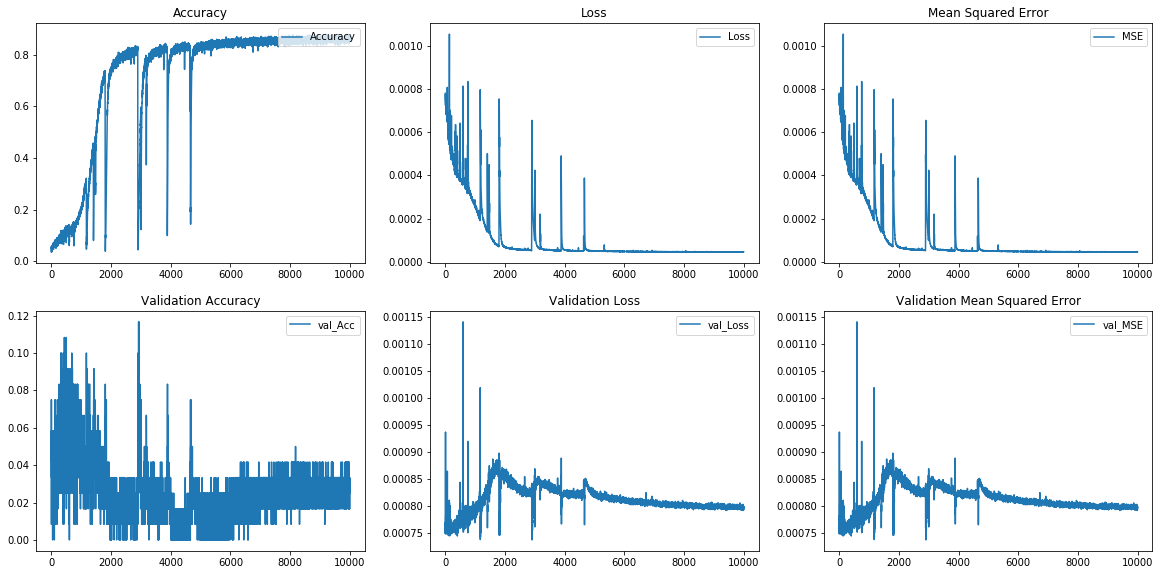

In [66]:
plt.figure(figsize=(20,15))
plt.subplot(331)
plt.plot(model_history.history['acc'] , label = 'Accuracy')
plt.legend(loc = 'upper right')
plt.title("Accuracy")

plt.subplot(332)
plt.plot(model_history.history['loss'] , label = 'Loss')
plt.legend(loc = 'upper right')
plt.title("Loss")

plt.subplot(333)
plt.plot(model_history.history['mean_squared_error'] , label = 'MSE')
plt.legend(loc = 'upper right')
plt.title("Mean Squared Error")

plt.subplot(334)
plt.plot(model_history.history['val_acc'] , label = 'val_Acc')
plt.legend(loc = 'upper right')
plt.title("Validation Accuracy")

plt.subplot(335)
plt.plot(model_history.history['val_loss'] , label = 'val_Loss')
plt.legend(loc = 'upper right')
plt.title("Validation Loss")

plt.subplot(336)
plt.plot(model_history.history['val_mean_squared_error'] , label = 'val_MSE')
plt.legend(loc = 'upper right')
plt.title("Validation Mean Squared Error")

plt.show()

In [86]:
testPredict = model.predict(x_test , verbose = 1)

484/484 [==============================] - 28s 57ms/step


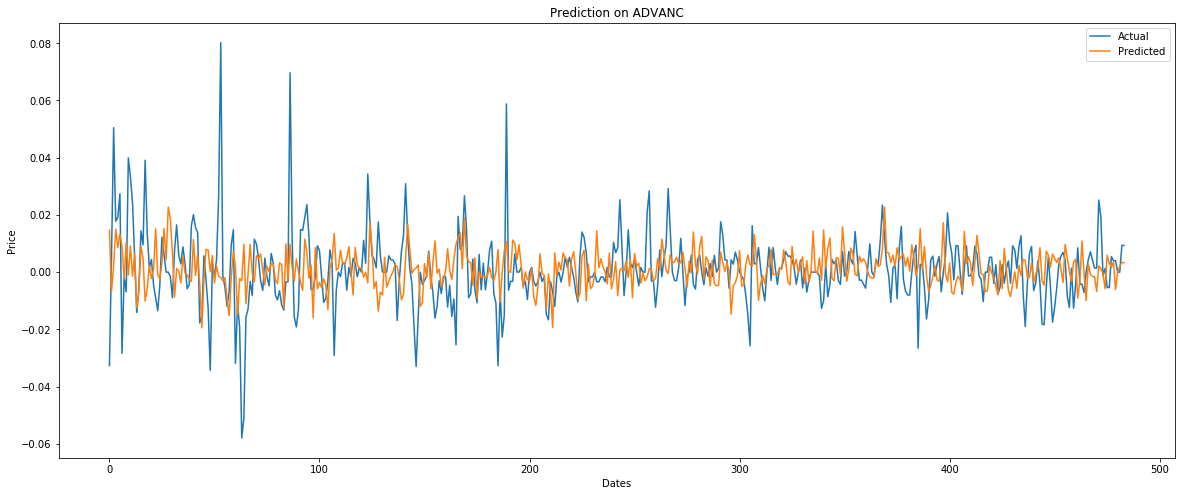

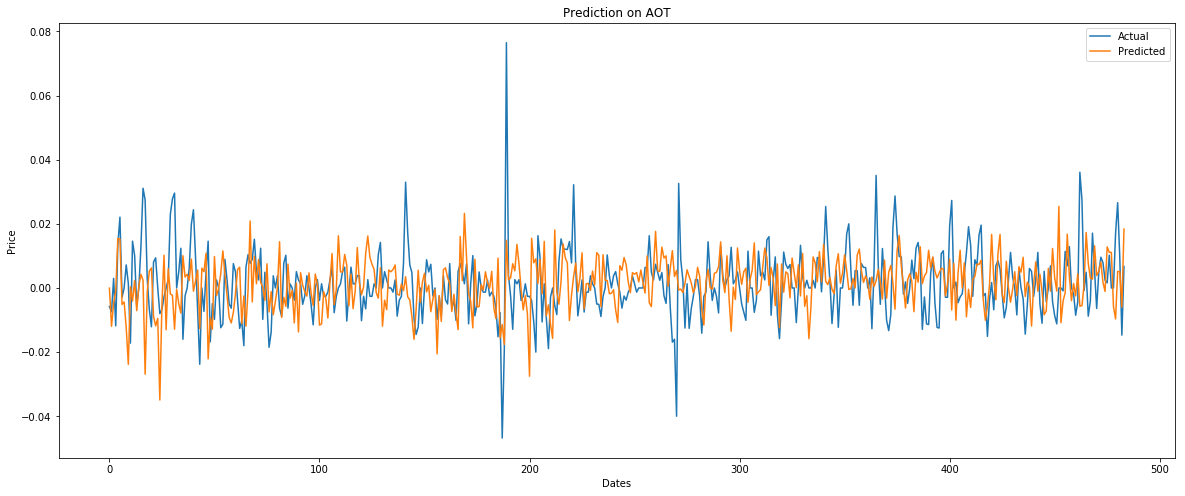

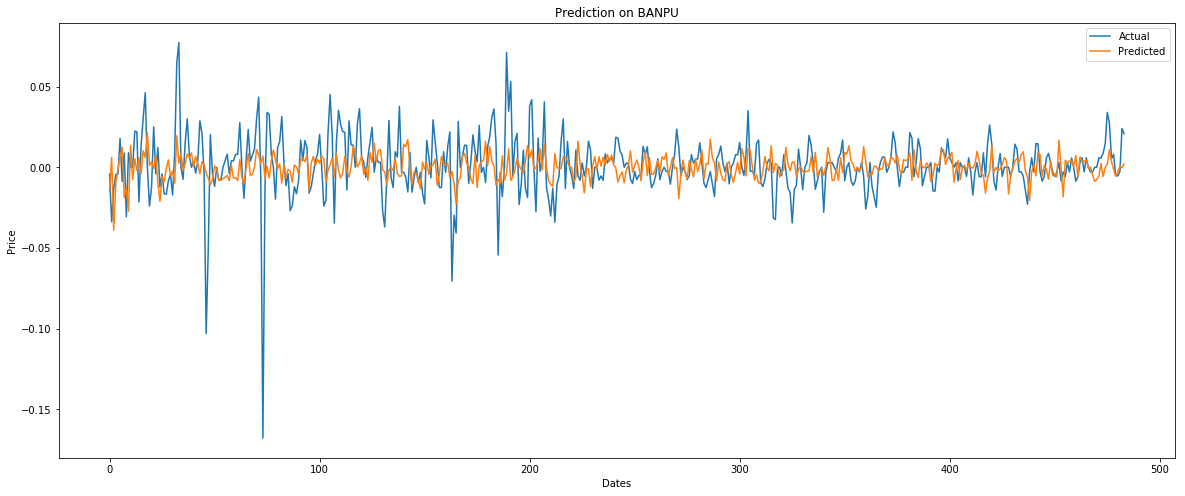

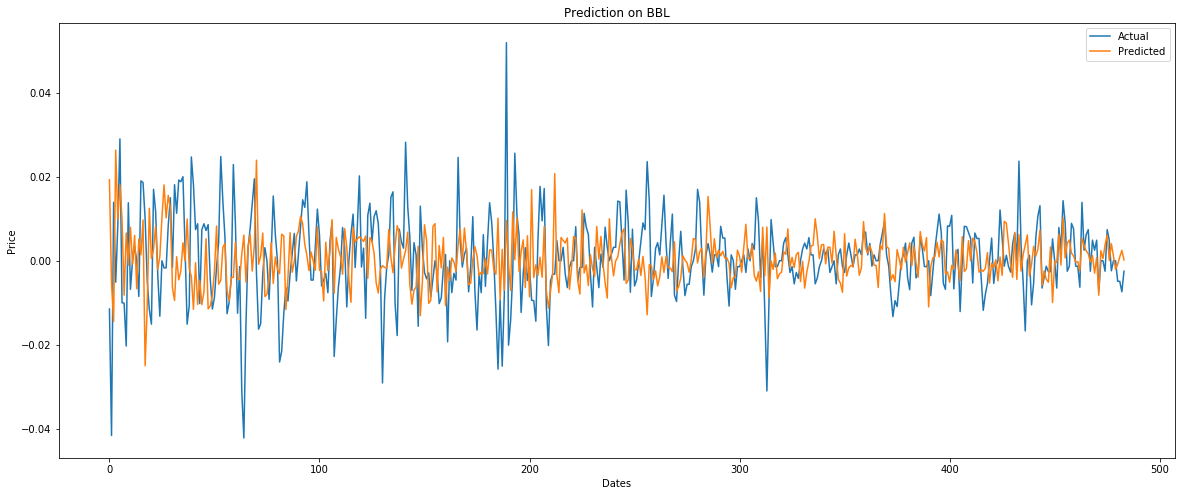

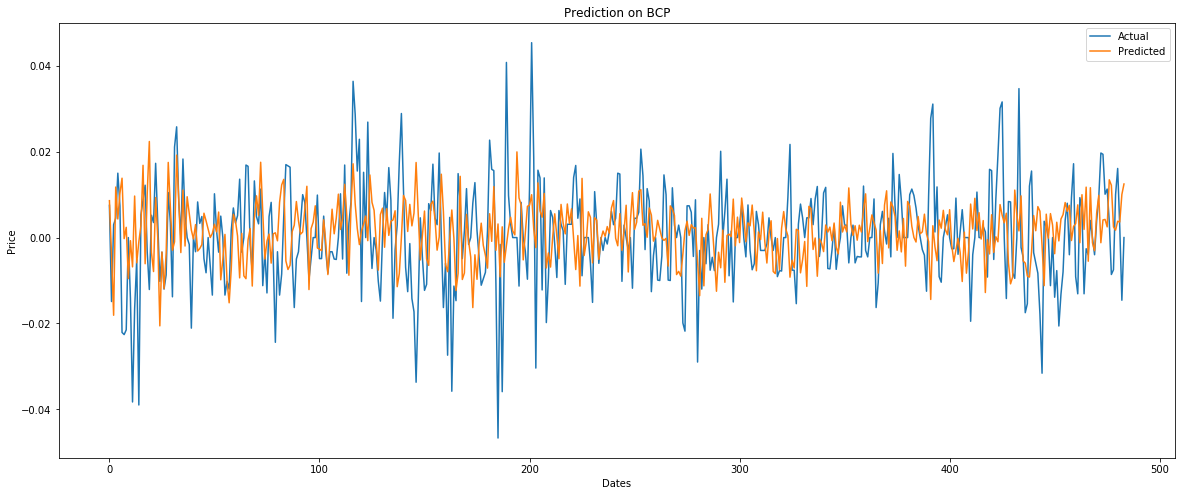

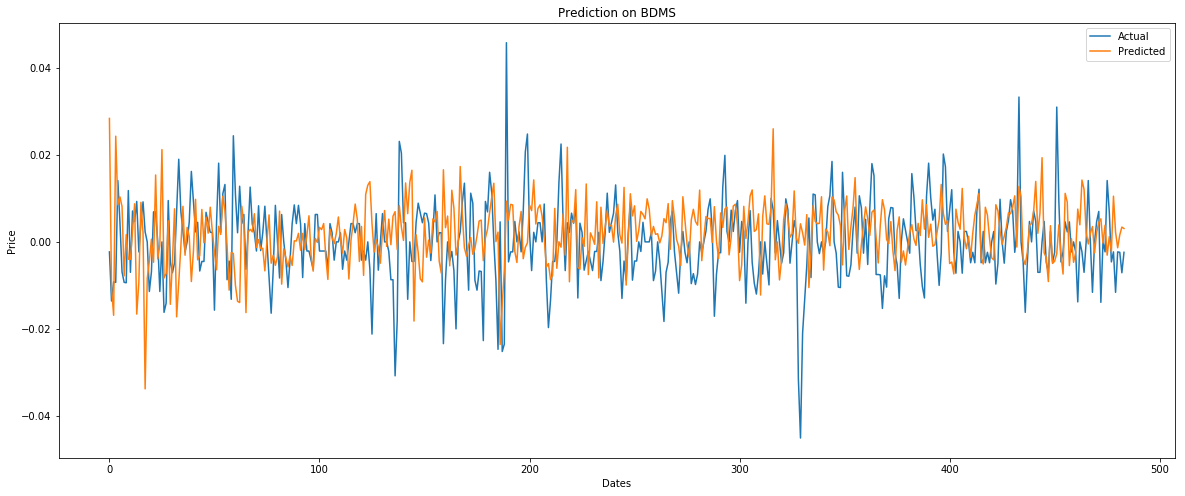

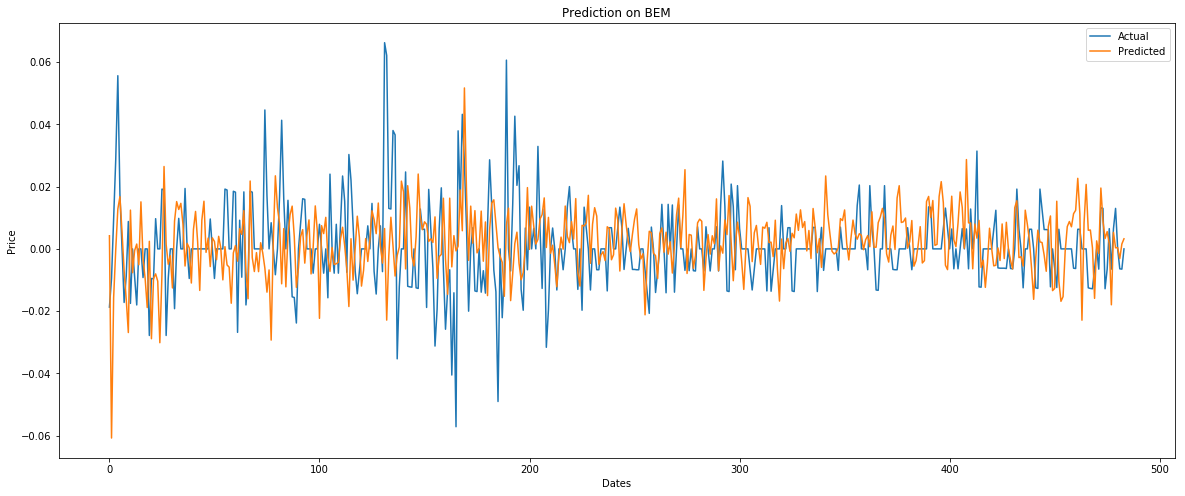

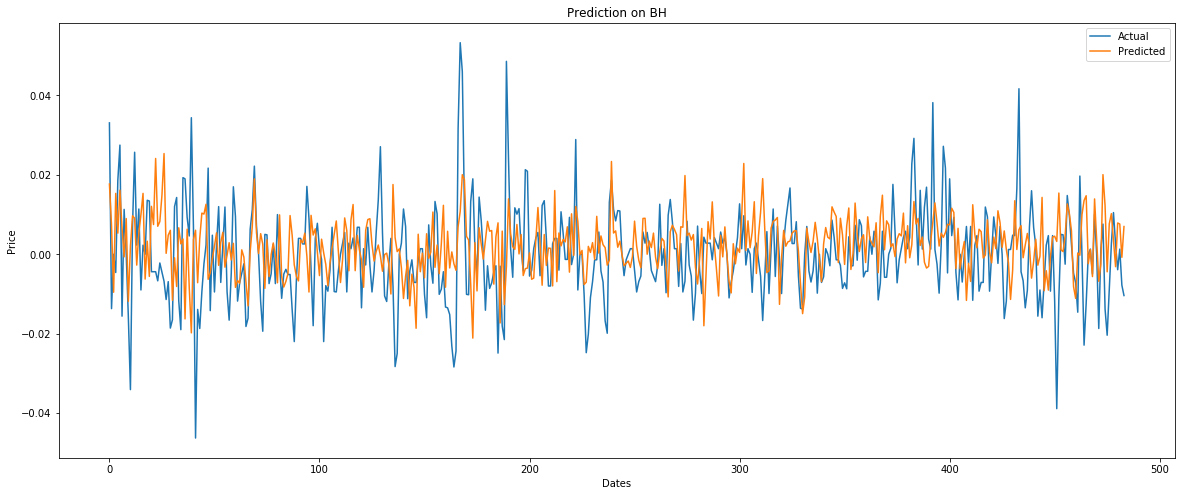

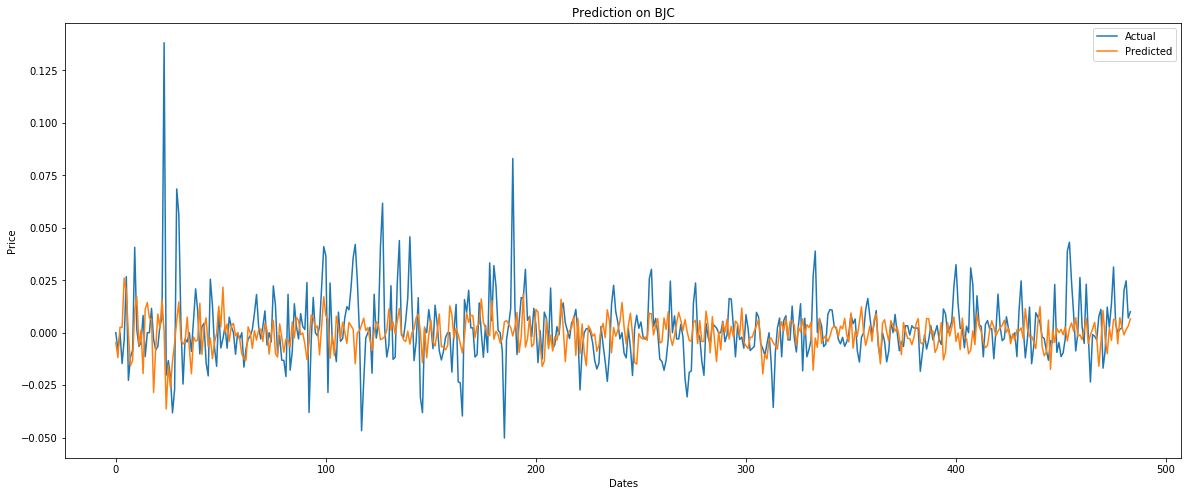

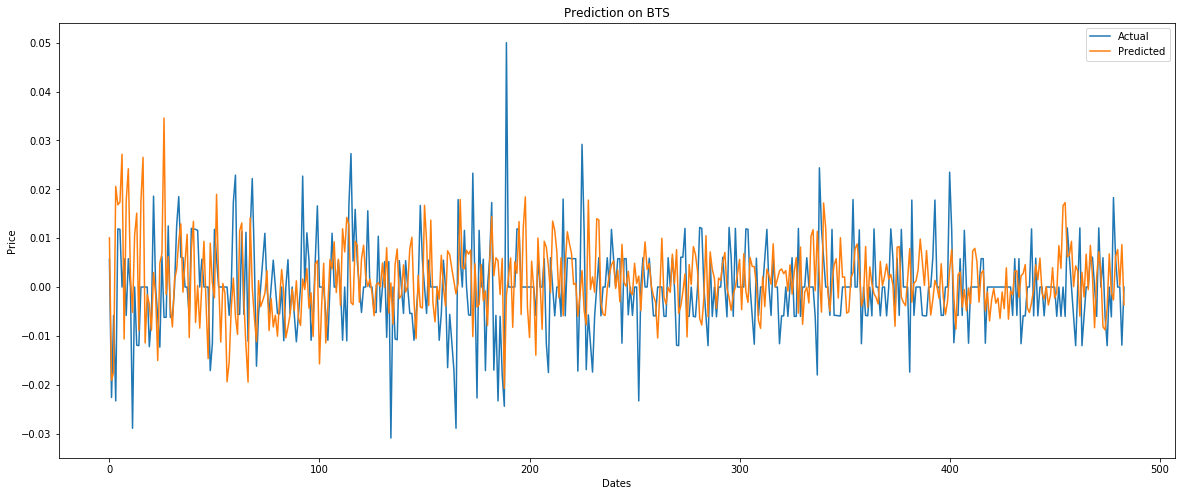

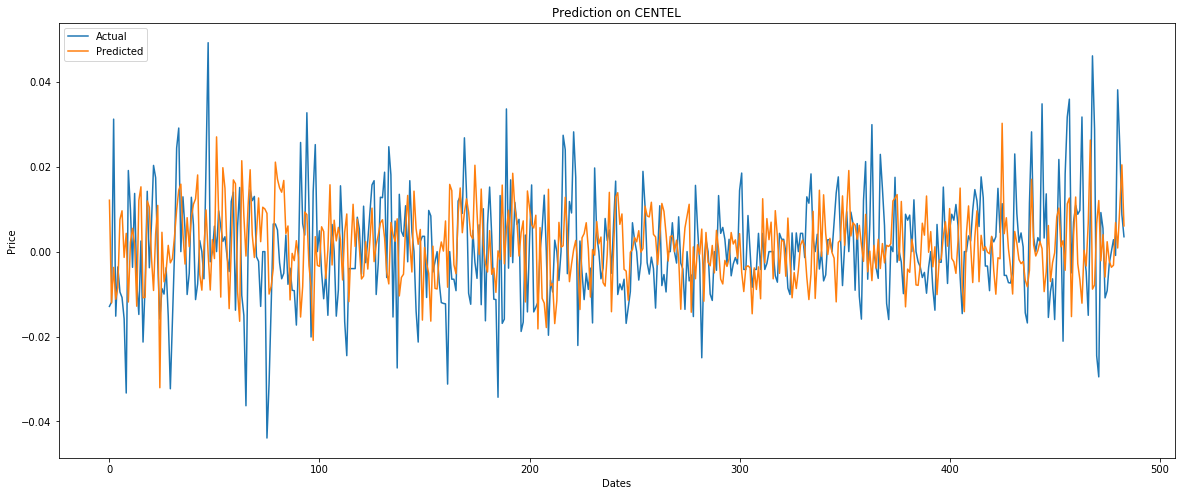

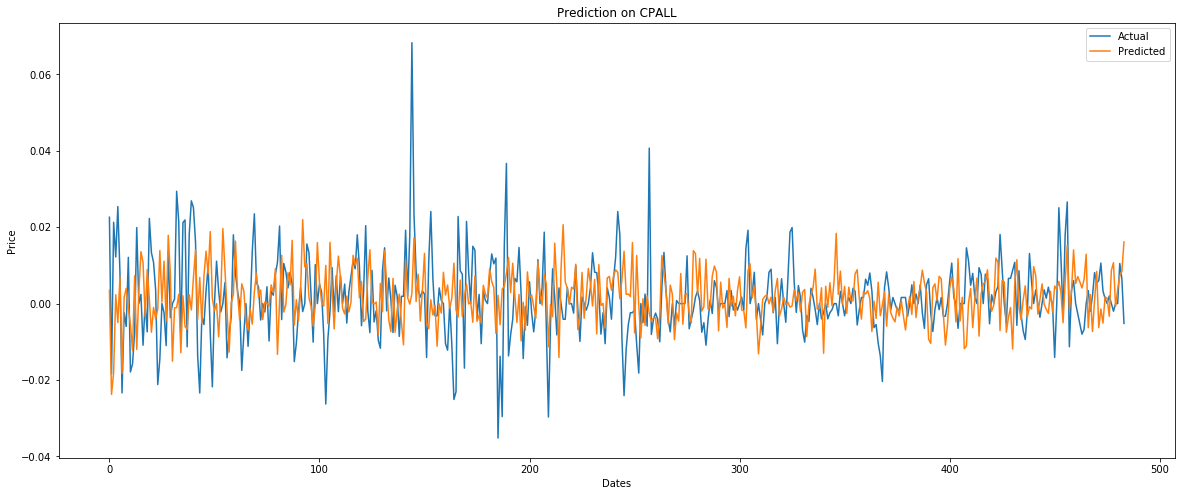

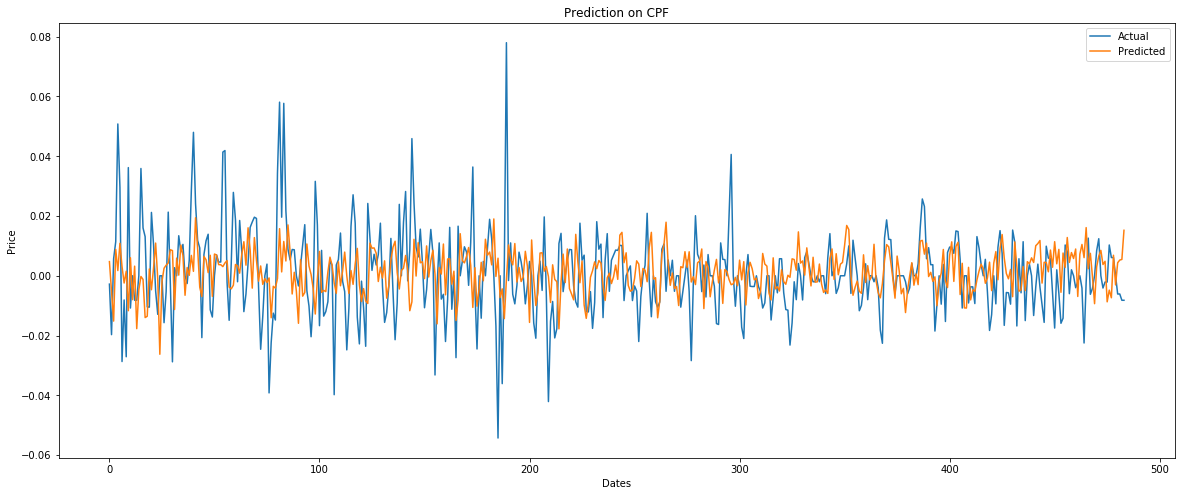

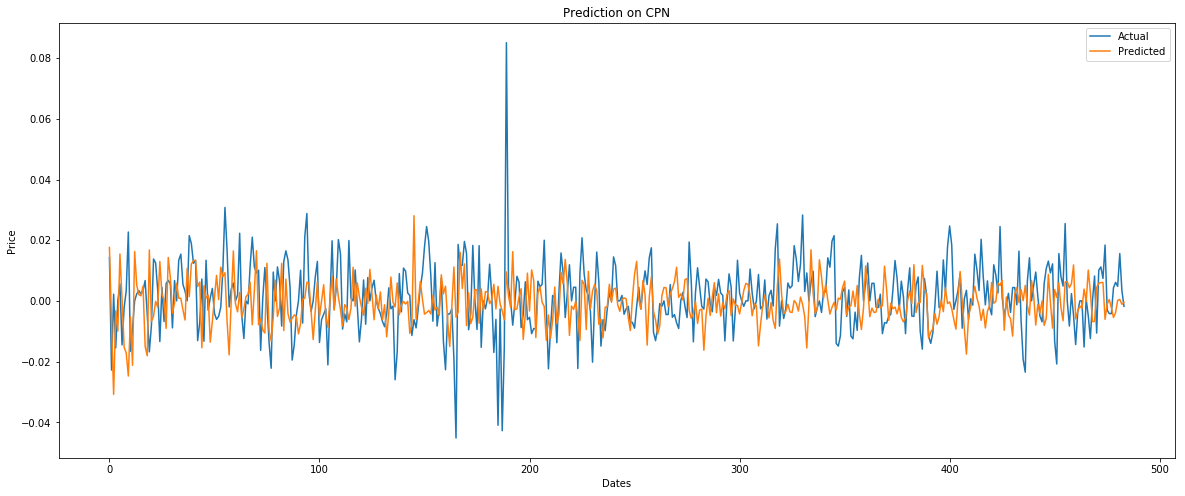

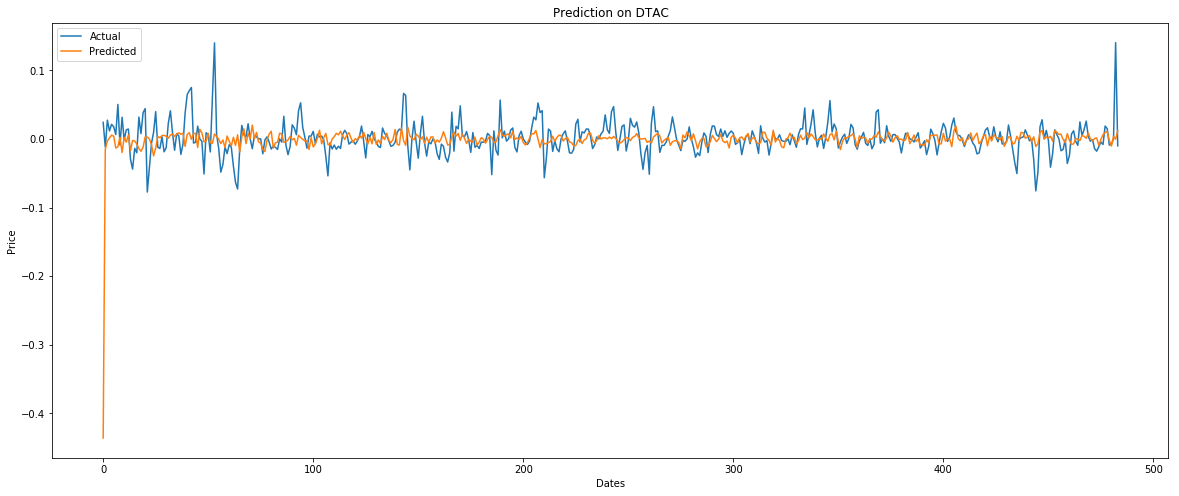

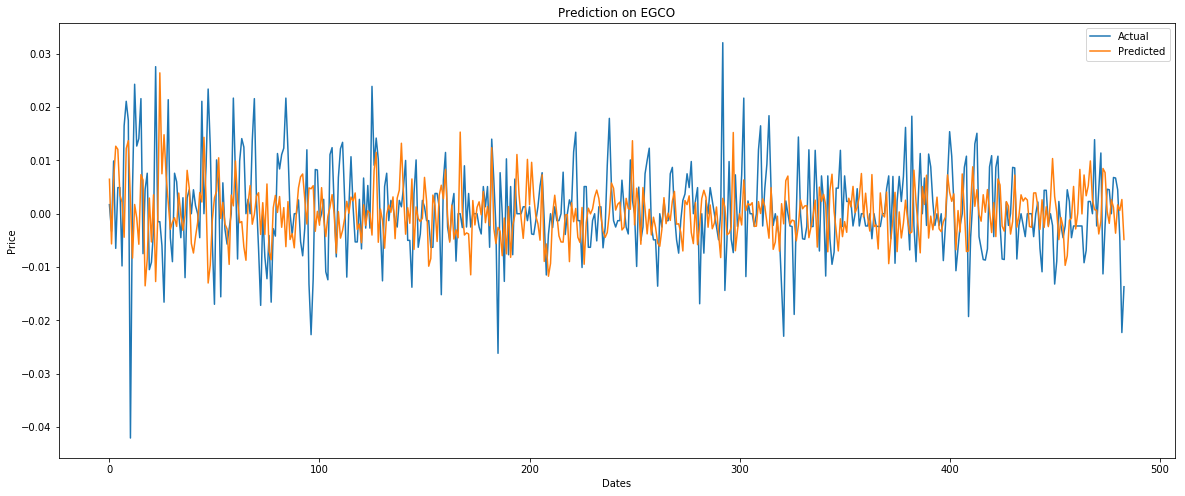

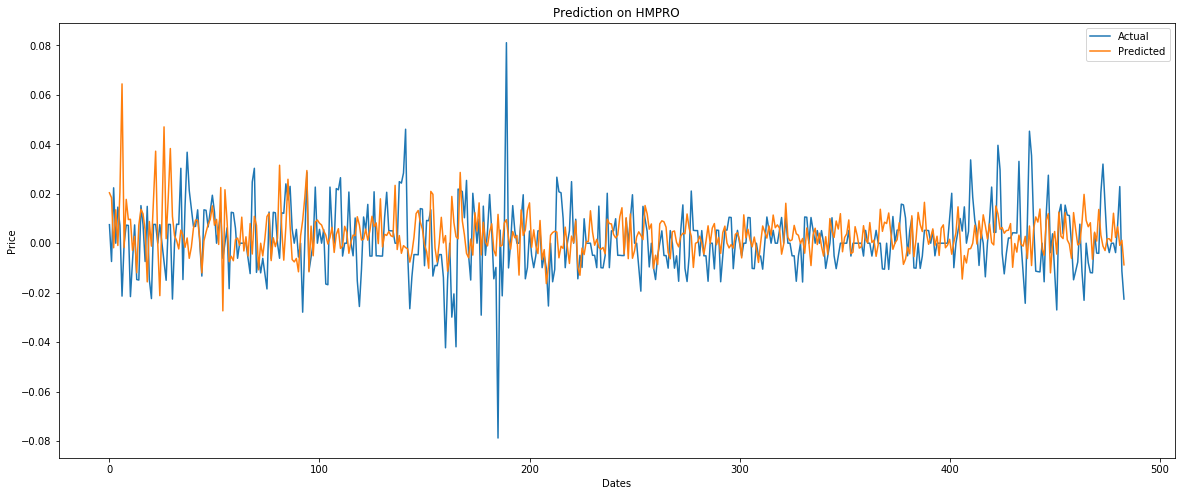

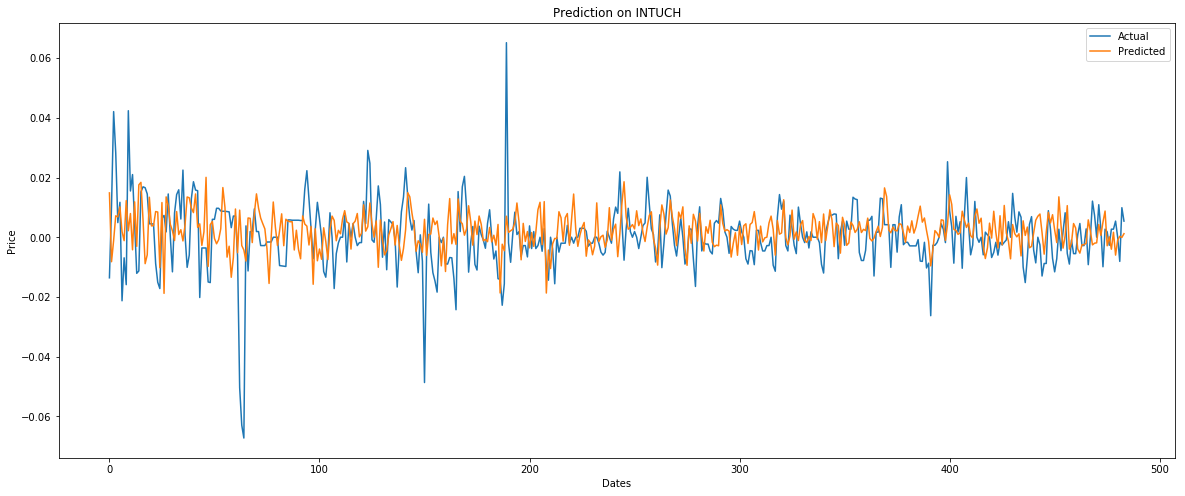

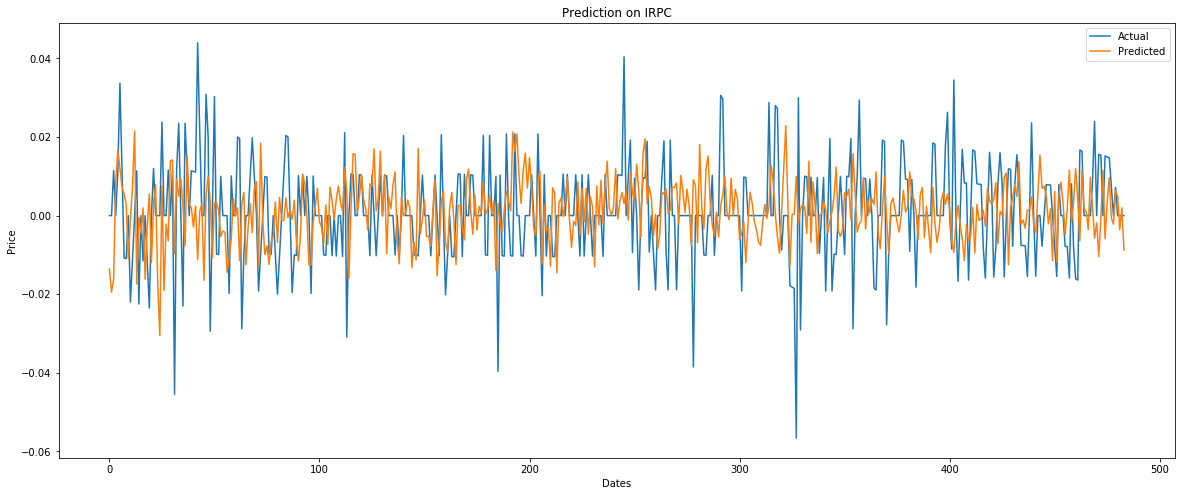

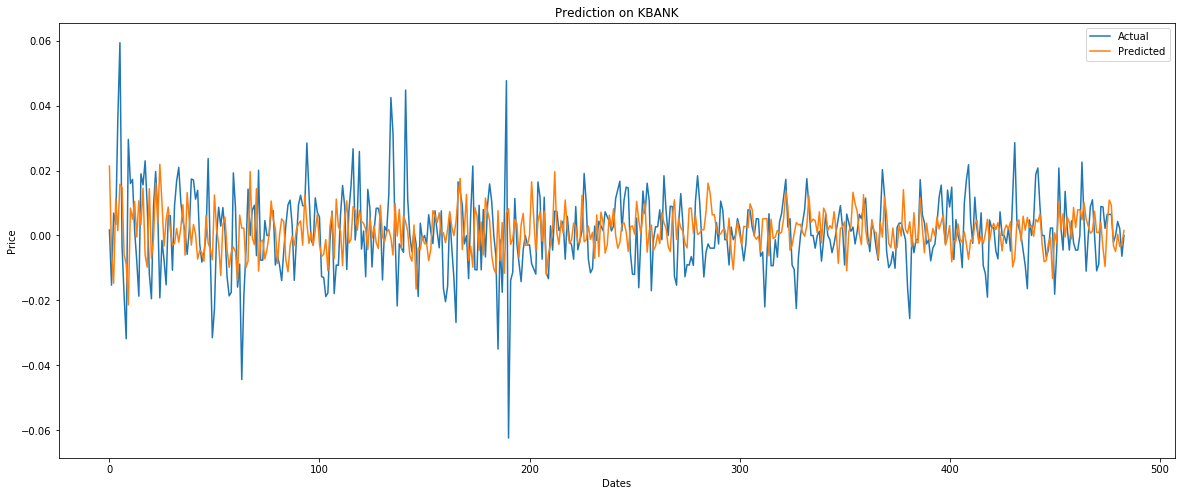

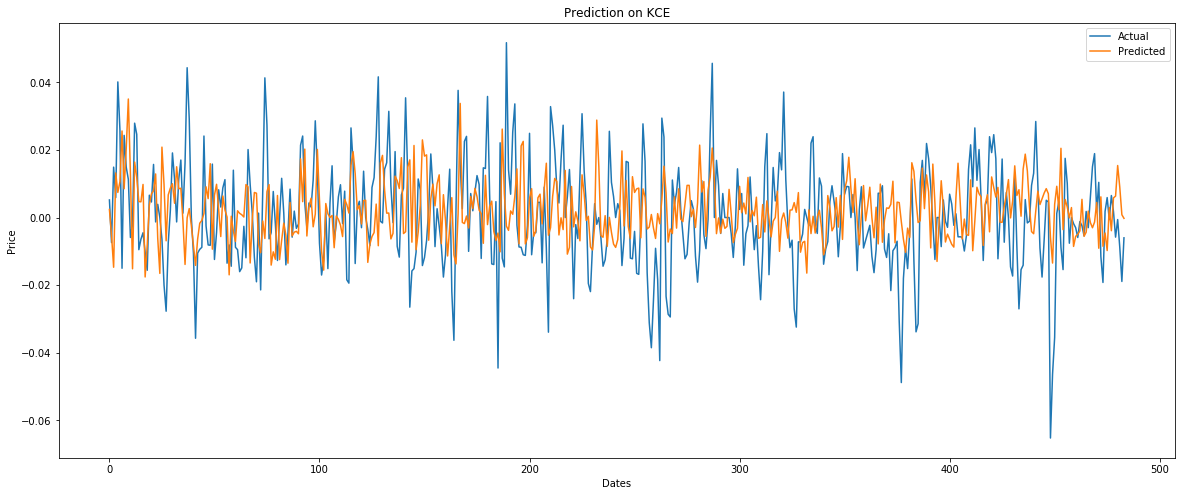

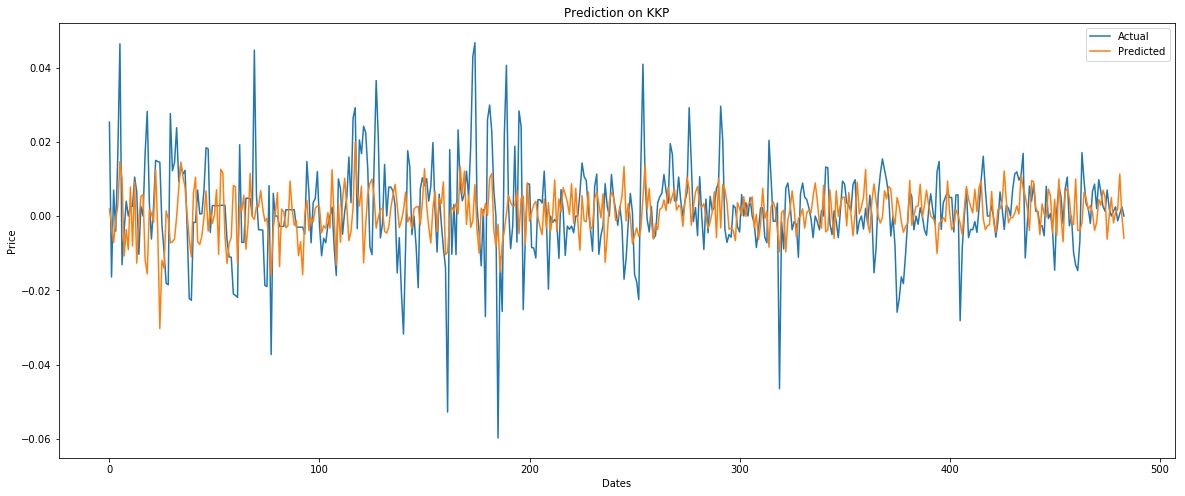

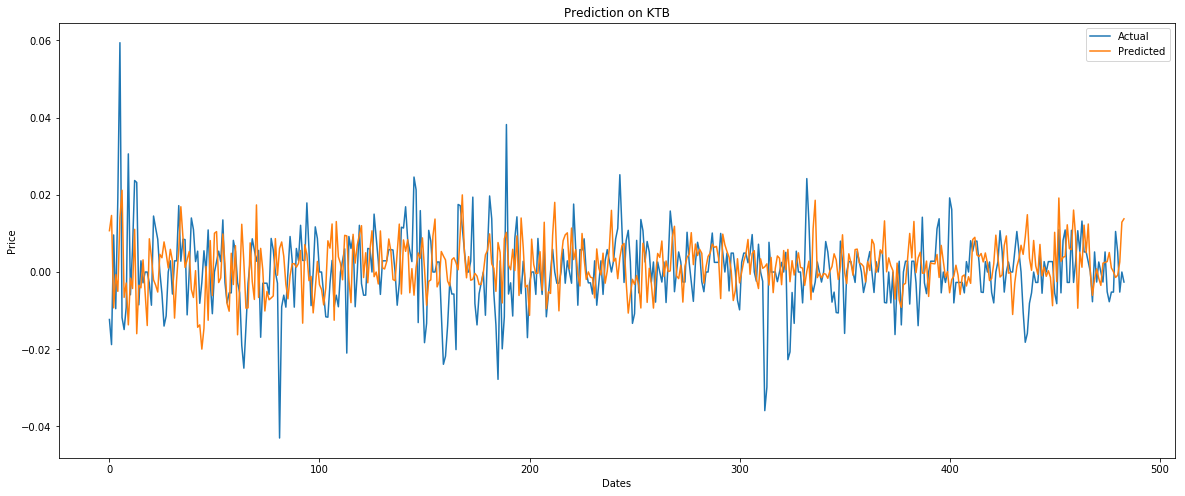

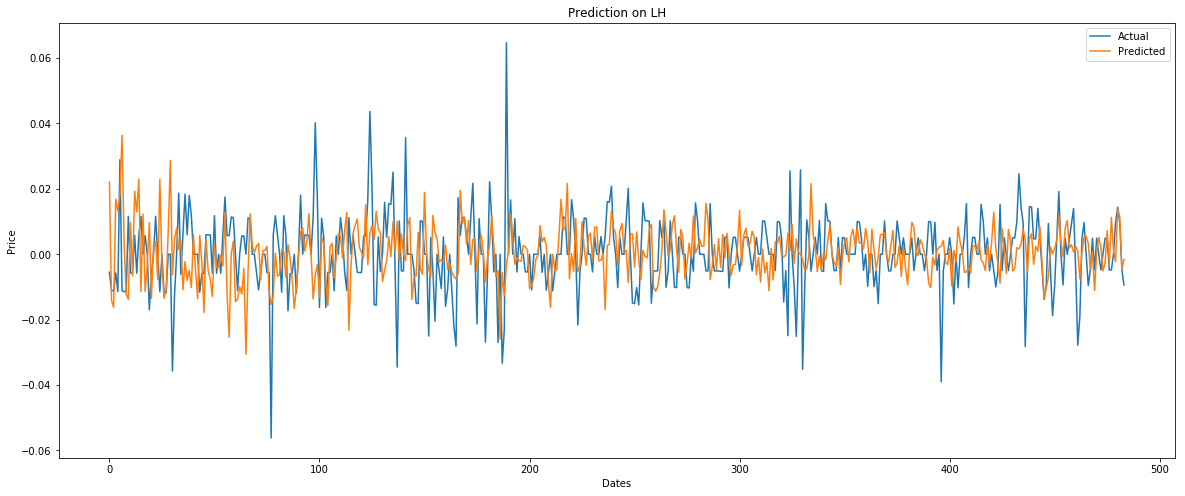

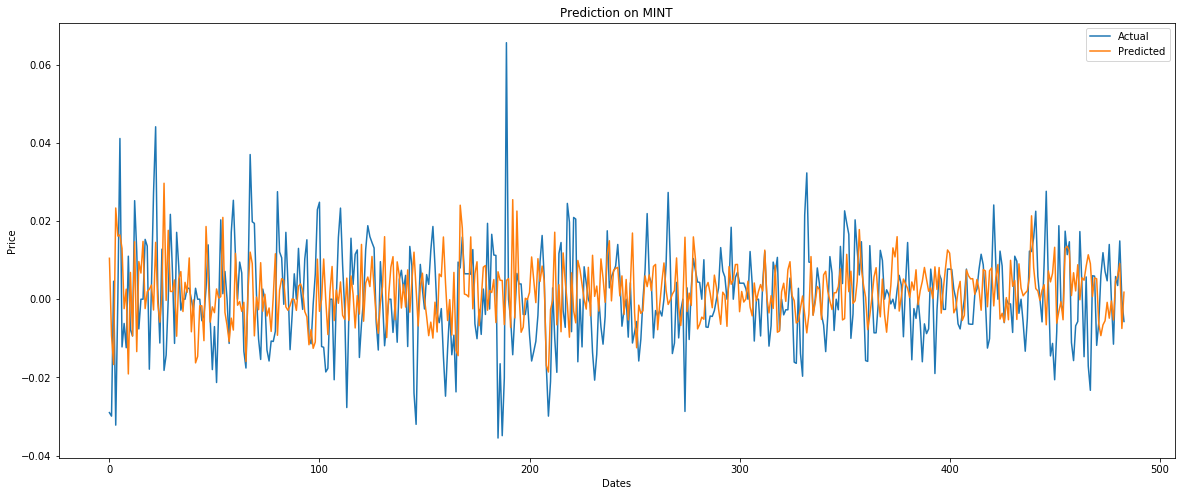

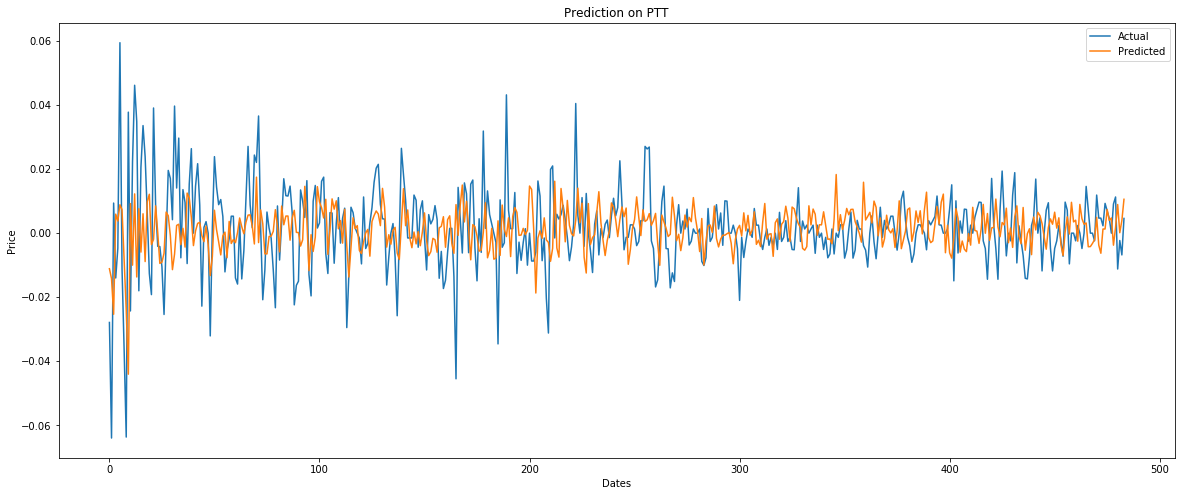

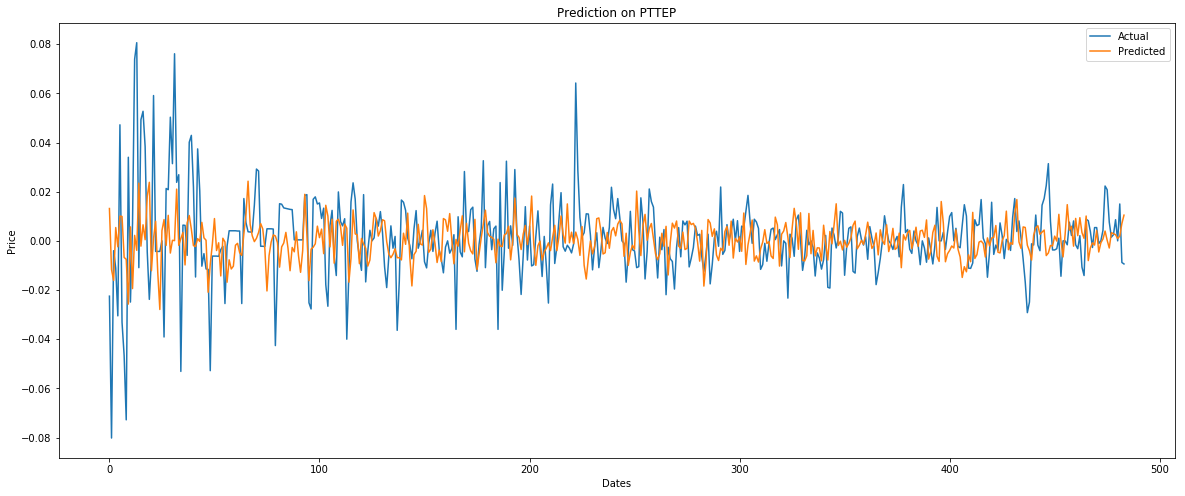

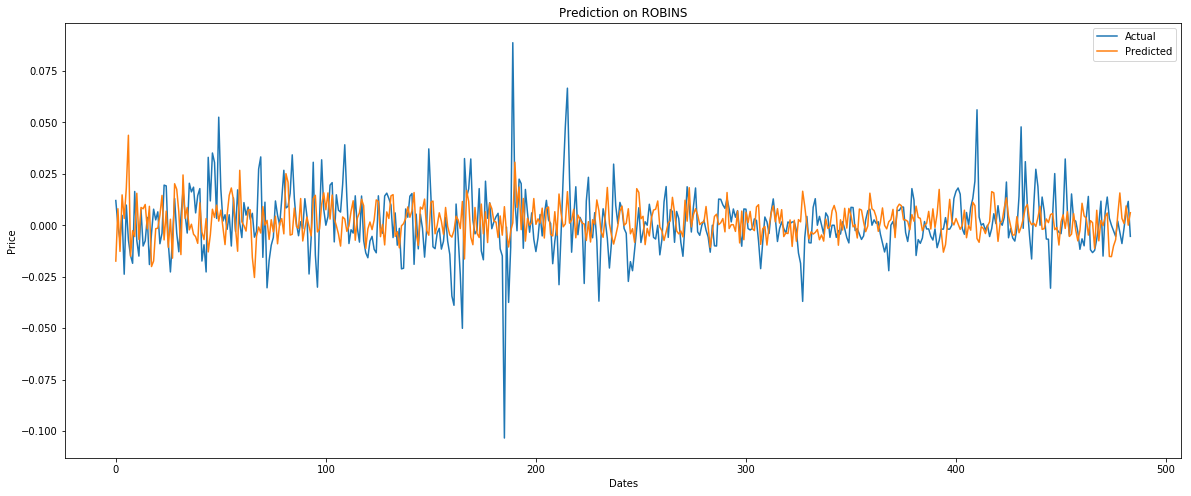

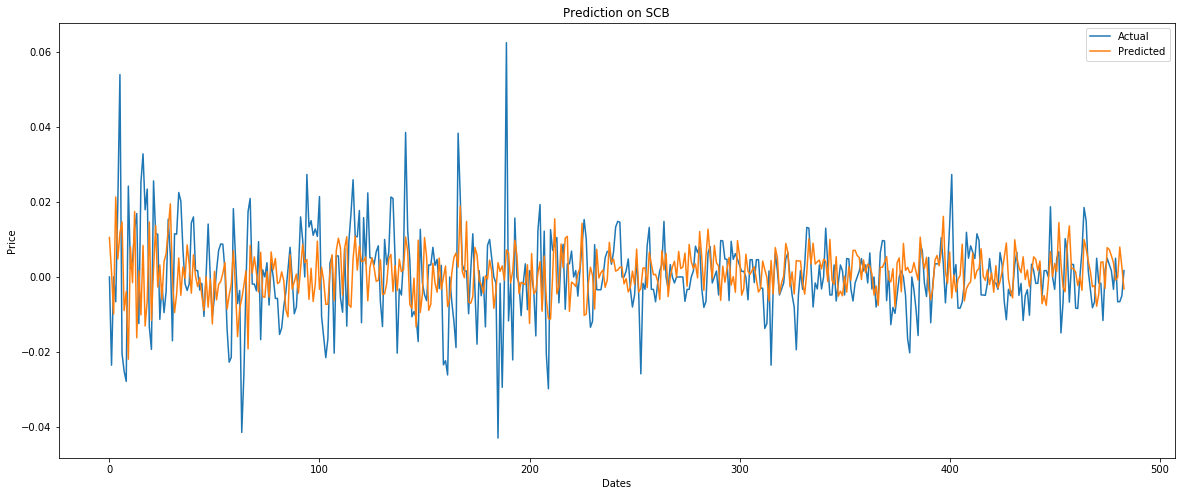

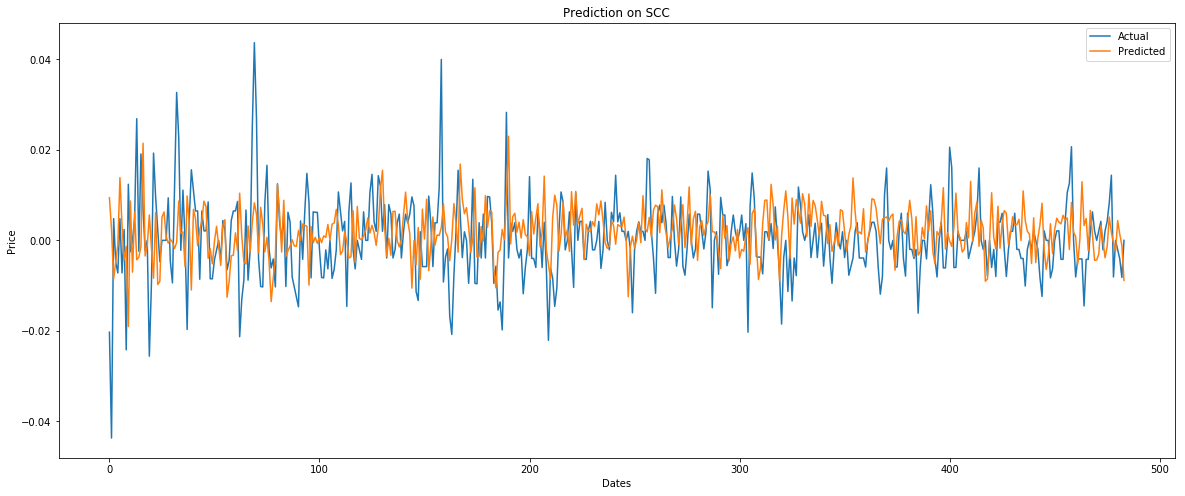

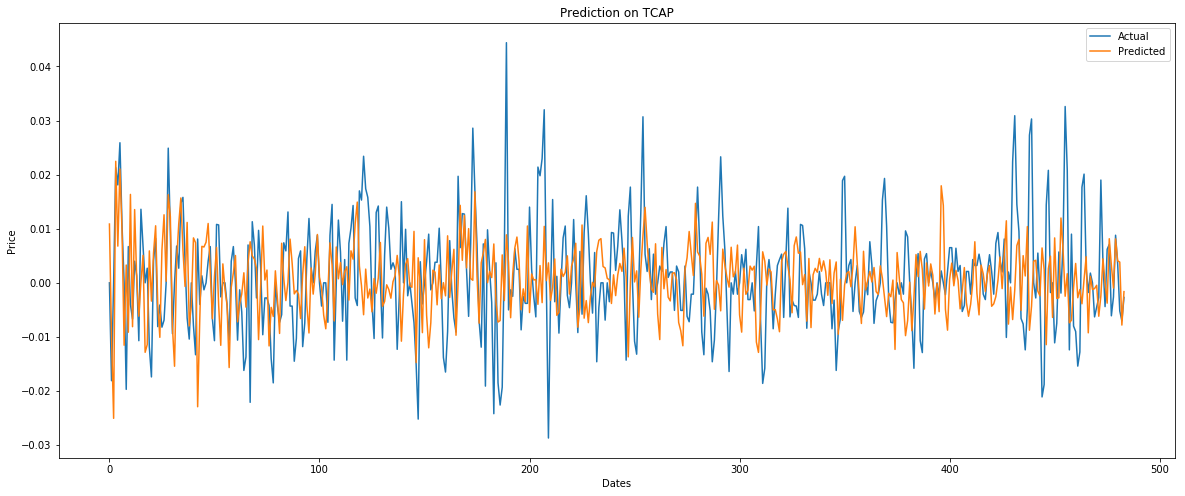

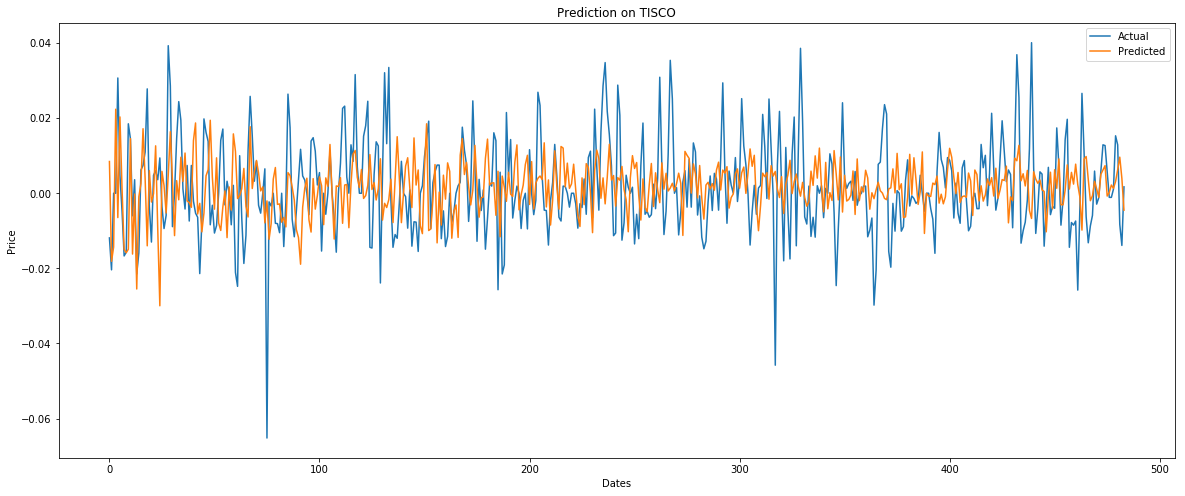

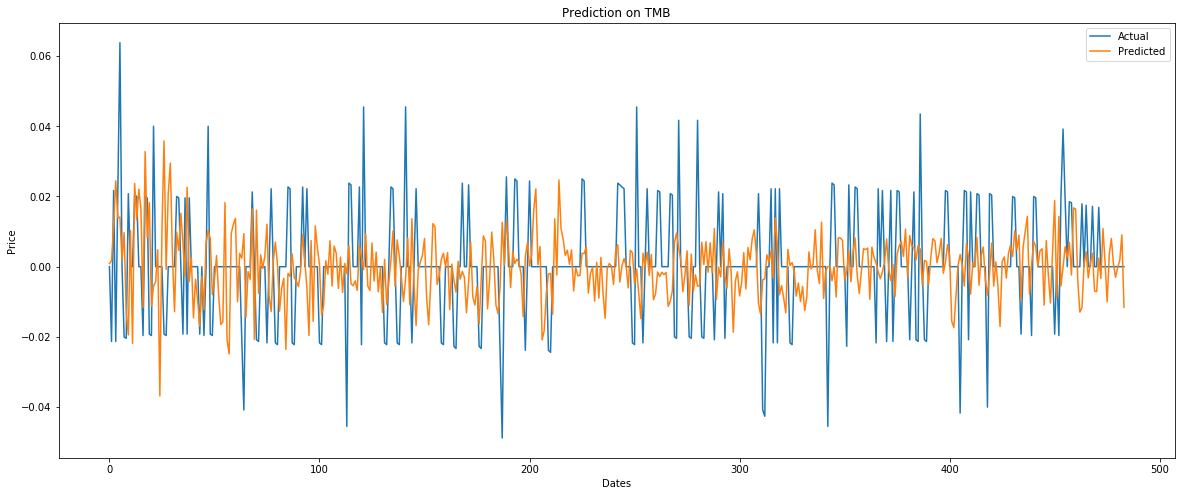

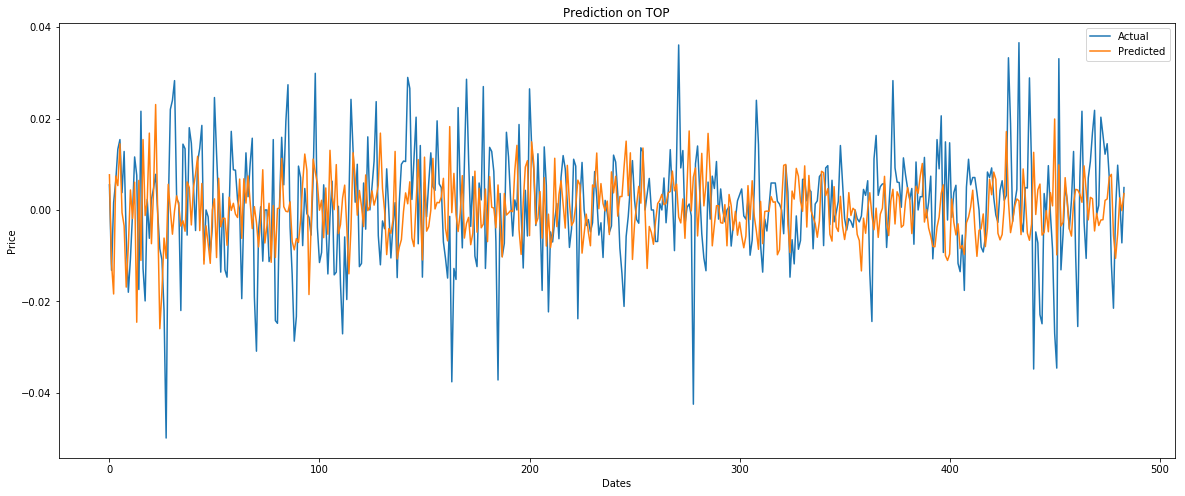

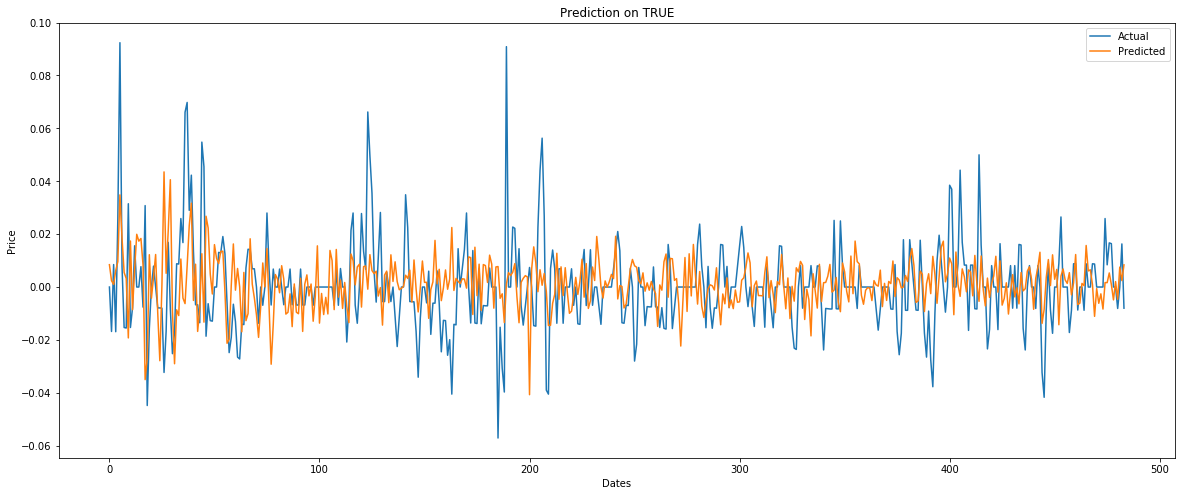

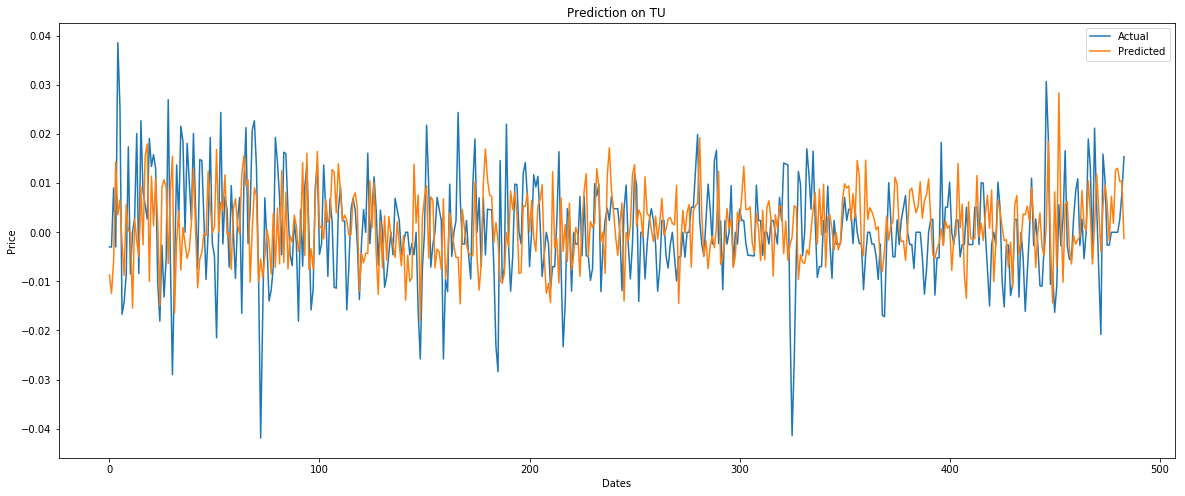

In [102]:
for index, value in enumerate(SET50):
    plt.figure(figsize=(20, 8))
    plt.plot(y_test[:,index])
    plt.plot(testPredict[:,index])
    plt.xlabel('Dates')
    plt.ylabel('Price')
    plt.title('Prediction on ' + value)
    plt.legend(['Actual','Predicted'])
    plt.show()